# 🎯 Combined Pipeline Full Test System

Bu notebook, 3-stage pipeline'ı kullanarak kapsamlı test, görselleştirme ve analiz yapar:

1. **Stage 0**: Real/Fake sınıflandırması
2. **Stage 1** (Fake ise): Domain tespiti
3. **Stage 2** (Fake ise): Spesifik mask türü tespiti

## Workflow
```
Görüntü → Stage 0 (Real/Fake)? 
    ├─ REAL → Bitir ✅
    └─ FAKE → Stage 1 (Domain)?
           → Stage 2 (Mask)?
           → Sonuç Döndür 🎯
```

## Özellikler
- ✅ Multi-Expert Routing (Stage 1 için)
- ✅ Kapsamlı görselleştirmeler (tüm stage'ler için)
- ✅ Gelişmiş hata analizi
- ✅ Performans metrikleri (ROC, PR curves, F1 scores)
- ✅ İleri düzey analizler
- ✅ Esnek veri seti kullanım oranı/miktarı ayarları


## 1️⃣ Setup & Imports


In [26]:
"""
🔧 SETUP VE IMPORTS
Her iki notebook'tan gerekli tüm importlar
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import glob
import random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import json
from pathlib import Path
from typing import Dict, Tuple, List, Optional
from collections import defaultdict
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score
)
import warnings
warnings.filterwarnings('ignore')

# GPU Optimizasyonları
cudnn.benchmark = True
cudnn.deterministic = False
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.cuda.empty_cache()

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# GPU warm-up
if device.type == 'cuda':
    print("🔥 GPU ısındırılıyor...")
    dummy = torch.randn(2000, 2000).cuda()
    for _ in range(20):
        _ = torch.matmul(dummy, dummy)
    torch.cuda.synchronize()
    del dummy
    torch.cuda.empty_cache()
    print("✅ GPU hazır!")

print("\n✅ Tüm kütüphaneler yüklendi!")


✅ Device: cuda
   GPU: NVIDIA GeForce RTX 4060 Laptop GPU
   VRAM: 8.0 GB
🔥 GPU ısındırılıyor...
✅ GPU hazır!

✅ Tüm kütüphaneler yüklendi!


## 2️⃣ Configuration

Tüm test ayarları, model path'leri, domain tanımları ve veri seti kullanım oranı/miktarı ayarları.

**NOT: Tüm değişkenler varsayılan değerlere sahiptir. Sadece değiştirmek istediğiniz değişkenleri ayarlayın!**


In [27]:
"""
⚙️ CONFIGURATION
Tüm ayarlar detaylı açıklamalarla
"""

# =============================================
# 📂 MODEL PATH'LERİ
# =============================================

# Stage 0: Real/Fake Model
REAL_FAKE_MODEL = r"C:\Users\emrec\OneDrive\Masaüstü\Bilgisayar_Ders\Sinif3\Yapay_Sinir_Aglari\yeni_modeller\eğitim_sonuçları\real_fake_detection\models\best_model.pth"

# Stage 1: Domain Classifier
DOMAIN_CLASSIFIER_MODEL = r"C:\Users\emrec\OneDrive\Masaüstü\Bilgisayar_Ders\Sinif3\Yapay_Sinir_Aglari\yeni_modeller\eğitim_sonuçları\hierarchical_mask_detection\stage1_domain\models\best_model.pth"

# Stage 2: Domain-specific Mask Detectors (klasör yolu)
STAGE2_MODELS_DIR = r"C:\Users\emrec\OneDrive\Masaüstü\Bilgisayar_Ders\Sinif3\Yapay_Sinir_Aglari\yeni_modeller\eğitim_sonuçları\hierarchical_mask_detection"

# Hierarchical Config (Stage 2 mappings için)
NOTEBOOK_NAME = "hierarchical_mask_detection"
HIERARCHICAL_CONFIG_PATH = os.path.join("eğitim_sonuçları", NOTEBOOK_NAME, "veriler", "hierarchical_config.json")

# =============================================
# 📊 VERİ KONUMLARI
# =============================================

# CSV dosyalarının konumu (meta.csv dosyaları)
CSV_BASE = r"C:\AI_DATA\SEMI_TRUTHS\inpainting"

# Extract edilmiş görsellerin konumu
EXTRACTED_BASE = r"C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting"

# =============================================
# 🎯 DOMAIN TANIMLARI
# =============================================

DOMAIN_CATEGORIES = {
    'URBAN': [
        'building', 'car', 'road', 'sidewalk', 'vegetation', 'sky', 
        'wall', 'window', 'door', 'tree', 'trees', 'pole', 'fence', 
        'parking', 'terrain'
    ],
    'HUMAN_BODY': [
        'hair', 'face', 'skin', 'neck', 'nose', 'Right-arm', 'Left-arm',
        'Right-leg', 'Left-leg', 'left_ear', 'right_ear', 'mouth', 
        'upper_lip', 'lower_lip'
    ],
    'CLOTHING': [
        'Upper-clothes', 'Pants', 'skirt', 'dress', 'hat', 'bag', 'cloth'
    ],
    'INDOOR': [
        'floor', 'ceiling', 'chair', 'table', 'seat', 'column', 'ground', 'grass'
    ],
    'BACKGROUND': [
        'background', 'out of roi', 'ego vehicle', 'rectification border', 'static'
    ]
}

DOMAIN_NAMES = list(DOMAIN_CATEGORIES.keys())
NUM_DOMAINS = len(DOMAIN_NAMES)

print(f"✅ {NUM_DOMAINS} Domain tanımlandı:")
total_masks = 0
for domain, masks in DOMAIN_CATEGORIES.items():
    print(f"   • {domain}: {len(masks)} masks")
    total_masks += len(masks)
print(f"   TOPLAM: {total_masks} mask türü")

# =============================================
# ⚙️ PERFORMANS AYARLARI
# =============================================

# Batch size (GPU VRAM'e göre ayarlayın)
BATCH_SIZE = 64  # RTX 4060 için uygun

# DataLoader worker sayısı (Windows'ta 0 önerilir)
NUM_WORKERS = 0

# Image size
IMG_SIZE = 224

# Mixed Precision (AMP) - VRAM tasarrufu için
USE_AMP = True  # True önerilir (%40 VRAM tasarrufu)

# Mixed Precision Scaler
scaler = GradScaler(enabled=USE_AMP)

# =============================================
# 🔄 MULTI-EXPERT ROUTING AYARLARI
# =============================================

# Multi-expert routing aktif mi? (URBAN/INDOOR/BACKGROUND karışıklığını çözmek için)
USE_MULTI_EXPERT_ROUTING = True

# Karışan domain'ler (multi-expert routing için)
CONFUSING_DOMAINS = ['URBAN', 'INDOOR', 'BACKGROUND']

# Routing threshold (bu threshold'un altında multi-expert devreye girer)
ROUTING_THRESHOLD = 0.90

# Hybrid scoring parametreleri
USE_DYNAMIC_ALPHA = True  # Domain'e göre dinamik alpha kullan
HYBRID_ALPHA = 0.3  # USE_DYNAMIC_ALPHA=False ise kullanılır (Stage1 ağırlığı)

# =============================================
# 📊 VERİ SETİ KULLANIM ORANI/MİKTARI AYARLARI
# =============================================

# NOT: Tüm değişkenler varsayılan değerlere sahiptir. 
# Sadece değiştirmek istediğiniz değişkenleri ayarlayın!

# Genel kullanım oranı (0.0-1.0 arası)
# Varsayılan: 0.25 (tüm verinin %25'i kullanılır)
TEST_DATA_RATIO = 0.10

# Real/Fake bazında oran
# Varsayılan: None → TEST_DATA_RATIO değerini kullanır
# Örnek: REAL_DATA_RATIO = 0.5  # Real görüntülerin %50'sini kullan
REAL_DATA_RATIO = None  # None ise TEST_DATA_RATIO kullanılır
FAKE_DATA_RATIO = None  # None ise TEST_DATA_RATIO kullanılır

# Domain bazında oran (dictionary formatında)
# Varsayılan: None → Tüm domain'ler için TEST_DATA_RATIO kullanılır
# Örnek: DOMAIN_RATIOS = {'URBAN': 0.3, 'HUMAN_BODY': 0.5, ...}
DOMAIN_RATIOS = None  # None ise tüm domain'ler için TEST_DATA_RATIO kullanılır

# Minimum/Maksimum örnek sayıları
MIN_SAMPLES_PER_DOMAIN = None  # None ise limit yok
MAX_SAMPLES_PER_DOMAIN = None  # None ise sınırsız
MIN_SAMPLES_TOTAL = 100  # Minimum 1000 örnek garanti edilir
MAX_SAMPLES_TOTAL = 1000  # None ise sınırsız

# Sampling stratejisi
# 'random': Rastgele örnekleme
# 'stratified': Real/Fake ve Domain bazında stratifiye örnekleme (dengeli dağılım) - ÖNERİLEN
# 'balanced': Her domain ve Real/Fake için eşit sayıda örnek (mümkünse)
SAMPLING_STRATEGY = 'stratified'  # Varsayılan: 'stratified'

# Öncelikli domain/mask seçimi
PRIORITY_DOMAINS = None  # None ise öncelik yok, örnek: ['URBAN', 'HUMAN_BODY']
PRIORITY_MASKS = None  # None ise öncelik yok

# Kullanım modu
USE_RATIO_MODE = True  # True ise oran bazlı, False ise miktar bazlı
TARGET_SAMPLE_COUNT = None  # USE_RATIO_MODE=False ise hedef örnek sayısı

# =============================================
# 📁 ÇIKTI KLASÖRÜ
# =============================================

# Ana output klasörü
BASE_OUTPUT_FOLDER = "combined_pipeline_test_results"

# Timestamp oluştur (her test için ayrı klasör)
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')

# Zaman damgalı test klasörü oluştur
OUTPUT_FOLDER = os.path.join(BASE_OUTPUT_FOLDER, TIMESTAMP)
VIZ_FOLDER = os.path.join(OUTPUT_FOLDER, "visualizations")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(VIZ_FOLDER, exist_ok=True)

print(f"\n✅ Configuration yüklendi!")
print(f"   Model path'leri: ✅")
print(f"   Veri konumları: ✅")
print(f"   Domain sayısı: {NUM_DOMAINS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Test data ratio: {TEST_DATA_RATIO*100:.0f}%")
print(f"   Multi-Expert Routing: {'✅ Aktif' if USE_MULTI_EXPERT_ROUTING else '❌ Kapalı'}")
print(f"   Sampling strategy: {SAMPLING_STRATEGY}")
print(f"   Output folder: {OUTPUT_FOLDER}")


✅ 5 Domain tanımlandı:
   • URBAN: 15 masks
   • HUMAN_BODY: 14 masks
   • CLOTHING: 7 masks
   • INDOOR: 8 masks
   • BACKGROUND: 5 masks
   TOPLAM: 49 mask türü

✅ Configuration yüklendi!
   Model path'leri: ✅
   Veri konumları: ✅
   Domain sayısı: 5
   Batch size: 64
   Test data ratio: 10%
   Multi-Expert Routing: ✅ Aktif
   Sampling strategy: stratified
   Output folder: combined_pipeline_test_results\20251224_140610


## 3️⃣ Model Mimarileri


In [28]:
"""
🏗️ MODEL MİMARİLERİ
Stage 0, Stage 1 ve Stage 2 için model sınıfları
"""

class RealFakeModel(nn.Module):
    """Stage 0: Real/Fake Classification"""
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        return self.backbone(x)


class DomainClassifier(nn.Module):
    """Stage 1: Domain Classification (5 domain)"""
    def __init__(self, num_domains=5, dropout_rate=0.3):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        backbone_out = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.head = nn.Sequential(
            nn.Linear(backbone_out, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_domains)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)


class DomainMaskDetector(nn.Module):
    """Stage 2: Domain-specific Mask Detection"""
    def __init__(self, num_masks, dropout_rate=0.3):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        backbone_out = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.head = nn.Sequential(
            nn.Linear(backbone_out, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_masks)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

print("✅ Model mimarileri tanımlandı")
print("   • RealFakeModel (Stage 0)")
print("   • DomainClassifier (Stage 1)")
print("   • DomainMaskDetector (Stage 2)")


✅ Model mimarileri tanımlandı
   • RealFakeModel (Stage 0)
   • DomainClassifier (Stage 1)
   • DomainMaskDetector (Stage 2)


## 4️⃣ Model Yükleme


In [29]:
"""
📦 MODEL YÜKLEME
Tüm stage'lerin modellerini yükleme
"""

print("\n" + "="*70)
print("🔄 MODELLER YÜKLENİYOR...")
print("="*70)

# =============================================
# STAGE 0: Real/Fake Model
# =============================================

print("\n[1/7] Real/Fake model yükleniyor...")
model_real_fake = RealFakeModel(num_classes=2).to(device)
checkpoint = torch.load(REAL_FAKE_MODEL, map_location=device, weights_only=False)

if 'model_state_dict' in checkpoint:
    model_real_fake.load_state_dict(checkpoint['model_state_dict'])
else:
    model_real_fake.load_state_dict(checkpoint)

model_real_fake.eval()
print("✅ Real/Fake model yüklendi")

# =============================================
# STAGE 1: Domain Classifier
# =============================================

print("\n[2/7] Domain Classifier yükleniyor...")
model_domain = DomainClassifier(num_domains=NUM_DOMAINS).to(device)
checkpoint_domain = torch.load(DOMAIN_CLASSIFIER_MODEL, map_location=device, weights_only=False)

if 'model_state_dict' in checkpoint_domain:
    model_domain.load_state_dict(checkpoint_domain['model_state_dict'])
    domain_to_label = checkpoint_domain.get('domain_to_label', {})
    label_to_domain = checkpoint_domain.get('label_to_domain', {})
else:
    model_domain.load_state_dict(checkpoint_domain)
    domain_to_label = {domain: idx for idx, domain in enumerate(DOMAIN_NAMES)}
    label_to_domain = {idx: domain for domain, idx in domain_to_label.items()}

model_domain.eval()
print("✅ Domain Classifier yüklendi")

# =============================================
# STAGE 2: Domain-specific Mask Detectors
# =============================================

print("\n[3-7/7] Stage 2 Mask Detectors yükleniyor...")

models_stage2 = {}
mask_to_label = {}
label_to_mask = {}

stage2_dir = Path(STAGE2_MODELS_DIR)

for idx, domain in enumerate(DOMAIN_NAMES):
    domain_lower = domain.lower()
    model_path = stage2_dir / f"stage2_{domain_lower}" / "models" / "best_model.pth"
    
    print(f"\n[{idx+3}/7] {domain} modeli yükleniyor...")
    
    if model_path.exists():
        checkpoint_s2 = torch.load(model_path, map_location=device, weights_only=False)
        
        # Get masks
        masks = DOMAIN_CATEGORIES[domain]
        num_masks = len(masks)
        
        # Create and load model
        model_s2 = DomainMaskDetector(num_masks=num_masks).to(device)
        
        if 'model_state_dict' in checkpoint_s2:
            model_s2.load_state_dict(checkpoint_s2['model_state_dict'])
        else:
            model_s2.load_state_dict(checkpoint_s2)
        
        model_s2.eval()
        models_stage2[domain] = model_s2
        
        # Create mappings
        mask_to_label[domain] = {mask: idx for idx, mask in enumerate(masks)}
        label_to_mask[domain] = {idx: mask for mask, idx in mask_to_label[domain].items()}
        
        print(f"   ✅ {domain} ({num_masks} masks)")
    else:
        print(f"   ⚠️  Model bulunamadı: {model_path}")

print(f"\n✅ Tüm modeller yüklendi! ({len(models_stage2)}/{len(DOMAIN_NAMES)} Stage 2 models)")

# GPU memory kontrolü
if device.type == 'cuda':
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"\n📊 GPU Memory:")
    print(f"   Allocated: {allocated:.2f} GB")
    print(f"   Reserved: {reserved:.2f} GB")



🔄 MODELLER YÜKLENİYOR...

[1/7] Real/Fake model yükleniyor...
✅ Real/Fake model yüklendi

[2/7] Domain Classifier yükleniyor...
✅ Domain Classifier yüklendi

[3-7/7] Stage 2 Mask Detectors yükleniyor...

[3/7] URBAN modeli yükleniyor...
   ✅ URBAN (15 masks)

[4/7] HUMAN_BODY modeli yükleniyor...
   ✅ HUMAN_BODY (14 masks)

[5/7] CLOTHING modeli yükleniyor...
   ✅ CLOTHING (7 masks)

[6/7] INDOOR modeli yükleniyor...
   ✅ INDOOR (8 masks)

[7/7] BACKGROUND modeli yükleniyor...
   ✅ BACKGROUND (5 masks)

✅ Tüm modeller yüklendi! (5/5 Stage 2 models)

📊 GPU Memory:
   Allocated: 1.50 GB
   Reserved: 1.72 GB


## 5️⃣ Dataset Hazırlama

HierarchicalValidationDataset (Stage 0 label'ı da içerecek şekilde genişletilmiş) + Veri seti sampling fonksiyonları


In [30]:
"""
📂 DATASET HAZIRLAMA - BÖLÜM 1
CSV yükleme, domain etiketleme ve helper fonksiyonlar
"""

print("\n" + "="*70)
print("📂 DATASET HAZIRLAMA")
print("="*70)

# =============================================
# HELPER FUNCTIONS
# =============================================

def get_domain(mask_name):
    """Mask name'den domain'i bul"""
    for domain, masks in DOMAIN_CATEGORIES.items():
        if mask_name in masks:
            return domain
    return None

# =============================================
# CSV YÜKLEME VE DOMAIN ETİKETLEME
# =============================================

print("\n📊 CSV yükleniyor...")

csv_files = glob.glob(os.path.join(CSV_BASE, "**", "*_meta.csv"), recursive=True)
print(f"✅ Bulunan CSV: {len(csv_files)} dosya")

if len(csv_files) == 0:
    raise FileNotFoundError(f"❌ CSV dosyası bulunamadı: {CSV_BASE}")

all_dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    csv_dir = os.path.dirname(csv_file)
    parent_folder = os.path.basename(os.path.dirname(csv_dir))
    model_name = os.path.basename(csv_dir)
    df['parent_dataset'] = parent_folder
    df['model'] = model_name
    df['dataset'] = f"{parent_folder}_{model_name}"
    all_dfs.append(df)
    print(f"   ✅ {parent_folder}/{model_name}: {len(df):,} satır")

df_combined = pd.concat(all_dfs, ignore_index=True)
print(f"\n✅ Toplam: {len(df_combined):,} görsel")

# Domain etiketleme
df_combined['domain'] = df_combined['mask_name'].apply(get_domain)
df_with_domain = df_combined[df_combined['domain'].notna()].copy()

print(f"\n📊 Domain Dağılımı:")
domain_counts = df_with_domain['domain'].value_counts()
for domain in DOMAIN_NAMES:
    count = domain_counts.get(domain, 0)
    ratio = (count / len(df_with_domain)) * 100
    print(f"   {domain:<15}: {count:>6,} ({ratio:>5.1f}%)")

print(f"\n✅ Domain etiketlendi: {len(df_with_domain):,} / {len(df_combined):,} görsel")

# =============================================
# REAL/FAKE LABEL EKLEME (Stage 0 için)
# =============================================

# NOT: Bu aşamada real/fake label'ları eklemek için CSV'de bir kolon olması gerekir
# Veya görüntü path'inden çıkarılabilir. Şimdilik tüm görüntüleri "fake" olarak işaretliyoruz
# çünkü inpainting dataset'i fake görüntüler içeriyor.
# Gerçek uygulamada, real görüntüler için ayrı bir dataset veya CSV kolonu olmalı.

print("\n🔍 Real/Fake label'ları hazırlanıyor...")
# Şimdilik tüm görüntüler fake olarak işaretleniyor
# Gerçek uygulamada bu kısım CSV'den veya ayrı bir kaynaktan alınmalı
df_with_domain['real_fake'] = 'fake'  # Varsayılan: fake
df_with_domain['real_fake_label'] = 1  # 0=real, 1=fake

print(f"   ✅ Real/Fake label'ları eklendi")
print(f"   Varsayılan: Tüm görüntüler 'fake' olarak işaretlendi")
print(f"   💡 Gerçek uygulamada CSV'den veya ayrı kaynaktan alınmalı")



📂 DATASET HAZIRLAMA

📊 CSV yükleniyor...
✅ Bulunan CSV: 6 dosya
   ✅ ADE20K/StableDiffusion_v5: 48,196 satır
   ✅ ADE20K/StableDiffusion_XL: 48,468 satır
   ✅ CelebAHQ/Kandinsky_2_2: 14,730 satır
   ✅ CityScapes/Kandinsky_2_2: 44,649 satır
   ✅ HumanParsing/OpenJourney: 29,061 satır
   ✅ OpenImages/StableDiffusion_XL: 7,332 satır

✅ Toplam: 192,436 görsel

📊 Domain Dağılımı:
   URBAN          : 67,523 ( 55.7%)
   HUMAN_BODY     : 20,840 ( 17.2%)
   CLOTHING       :  6,417 (  5.3%)
   INDOOR         : 16,920 ( 13.9%)
   BACKGROUND     :  9,614 (  7.9%)

✅ Domain etiketlendi: 121,314 / 192,436 görsel

🔍 Real/Fake label'ları hazırlanıyor...
   ✅ Real/Fake label'ları eklendi
   Varsayılan: Tüm görüntüler 'fake' olarak işaretlendi
   💡 Gerçek uygulamada CSV'den veya ayrı kaynaktan alınmalı


In [31]:
"""
📂 DATASET HAZIRLAMA - BÖLÜM 2
Recursive dosya tarama ve image path → label mapping
"""

# Domain label mapping
domain_to_label = {domain: idx for idx, domain in enumerate(DOMAIN_NAMES)}
label_to_domain = {idx: domain for domain, idx in domain_to_label.items()}

# Real/Fake label mapping
real_fake_to_label = {'real': 0, 'fake': 1}
label_to_real_fake = {0: 'real', 1: 'fake'}

print("\n📂 Extract edilmiş dosyalar taranıyor (recursive)...")

# Etiket sözlükleri (domain ve real/fake için)
labels_dict_by_dataset = {}
real_fake_dict_by_dataset = {}
mask_dict_by_dataset = {}

for _, row in df_with_domain.iterrows():
    img_id = str(row['perturbed_img_id'])
    domain = row['domain']
    domain_label = domain_to_label[domain]
    real_fake = row['real_fake']
    real_fake_label = row['real_fake_label']
    mask_name = row['mask_name']
    dataset_key = row['dataset']
    
    if dataset_key not in labels_dict_by_dataset:
        labels_dict_by_dataset[dataset_key] = {}
        real_fake_dict_by_dataset[dataset_key] = {}
        mask_dict_by_dataset[dataset_key] = {}
    
    for ext in ['', '.png', '.jpg', '.jpeg']:
        labels_dict_by_dataset[dataset_key][img_id + ext] = domain_label
        real_fake_dict_by_dataset[dataset_key][img_id + ext] = real_fake_label
        mask_dict_by_dataset[dataset_key][img_id + ext] = mask_name

print(f"✅ Etiket dictionary'leri oluşturuldu: {len(labels_dict_by_dataset)} dataset")

# Recursive dosya tarama
all_image_paths = []
all_domain_labels = []
all_real_fake_labels = []
all_mask_names = []
found_by_dataset = {}

for parent_dataset in os.listdir(EXTRACTED_BASE):
    parent_path = os.path.join(EXTRACTED_BASE, parent_dataset)
    if not os.path.isdir(parent_path):
        continue
    
    for model_name in os.listdir(parent_path):
        model_path = os.path.join(parent_path, model_name)
        if not os.path.isdir(model_path):
            continue
        
        dataset_key = f"{parent_dataset}_{model_name}"
        
        if dataset_key not in labels_dict_by_dataset:
            continue
        
        labels_dict = labels_dict_by_dataset[dataset_key]
        rf_dict = real_fake_dict_by_dataset[dataset_key]
        mask_dict = mask_dict_by_dataset[dataset_key]
        found_by_dataset[dataset_key] = 0
        
        # Recursive tara
        for root, dirs, files in os.walk(model_path):
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    base_name = file
                    name_without_ext = os.path.splitext(file)[0]
                    
                    domain_label = None
                    real_fake_label = None
                    mask_name = None
                    
                    for name in [base_name, name_without_ext,
                               name_without_ext + '.png',
                               name_without_ext + '.jpg',
                               name_without_ext + '.jpeg']:
                        if name in labels_dict:
                            domain_label = labels_dict[name]
                            real_fake_label = rf_dict[name]
                            mask_name = mask_dict[name]
                            break
                    
                    if domain_label is not None:
                        full_path = os.path.join(root, file)
                        all_image_paths.append(full_path)
                        all_domain_labels.append(domain_label)
                        all_real_fake_labels.append(real_fake_label)
                        all_mask_names.append(mask_name)
                        found_by_dataset[dataset_key] += 1

print(f"\n✅ TOPLAM: {len(all_image_paths):,} görüntü bulundu")

if len(all_image_paths) == 0:
    raise FileNotFoundError("Görüntü dosyaları bulunamadı!")

# Dataset bazında istatistik
print(f"\n📊 Dataset Bazında Bulunan:")
for dataset_key in sorted(found_by_dataset.keys()):
    found = found_by_dataset[dataset_key]
    print(f"   {dataset_key:<35}: {found:>6,} görüntü")

# Real/Fake dağılımı
real_count = sum(1 for label in all_real_fake_labels if label == 0)
fake_count = sum(1 for label in all_real_fake_labels if label == 1)
print(f"\n📊 Real/Fake Dağılımı:")
print(f"   Real: {real_count:,} ({real_count/len(all_real_fake_labels)*100:.1f}%)")
print(f"   Fake: {fake_count:,} ({fake_count/len(all_real_fake_labels)*100:.1f}%)")



📂 Extract edilmiş dosyalar taranıyor (recursive)...
✅ Etiket dictionary'leri oluşturuldu: 6 dataset

✅ TOPLAM: 81,102 görüntü bulundu

📊 Dataset Bazında Bulunan:
   ADE20K_StableDiffusion_XL          : 26,657 görüntü
   CelebAHQ_Kandinsky_2_2             : 13,727 görüntü
   CityScapes_Kandinsky_2_2           : 27,293 görüntü
   HumanParsing_OpenJourney           : 13,215 görüntü
   OpenImages_StableDiffusion_XL      :    210 görüntü

📊 Real/Fake Dağılımı:
   Real: 0 (0.0%)
   Fake: 81,102 (100.0%)


In [32]:
"""
📂 DATASET HAZIRLAMA - BÖLÜM 3
HierarchicalValidationDataset (Stage 0 label'ı da içeren genişletilmiş versiyon)
"""

class HierarchicalValidationDataset(Dataset):
    """
    Hem domain hem mask hem de real/fake label'ını içeren dataset.
    Stage 0, Stage 1 ve Stage 2 testleri için gerekli tüm bilgileri içerir.
    """
    
    def __init__(self, image_paths, real_fake_labels, domain_labels, mask_names, mask_labels, 
                 domain_names_list, transform=None):
        """
        Args:
            image_paths: List of image file paths
            real_fake_labels: List of real/fake label indices (0=real, 1=fake)
            domain_labels: List of domain label indices (0-4)
            mask_names: List of actual mask names (string)
            mask_labels: List of mask label indices (domain-specific)
            domain_names_list: List of domain name strings (for reference)
            transform: Image transforms
        """
        self.image_paths = image_paths
        self.real_fake_labels = real_fake_labels
        self.domain_labels = domain_labels
        self.mask_names = mask_names
        self.mask_labels = mask_labels
        self.domain_names_list = domain_names_list
        self.transform = transform
        
        # Validate lengths
        assert len(image_paths) == len(real_fake_labels) == len(domain_labels) == len(mask_names) == len(mask_labels), \
            f"Length mismatch! paths:{len(image_paths)}, rf:{len(real_fake_labels)}, " \
            f"domains:{len(domain_labels)}, mask_names:{len(mask_names)}, mask_labels:{len(mask_labels)}"
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
            
            real_fake_label = self.real_fake_labels[idx]
            domain_label = self.domain_labels[idx]
            mask_name = self.mask_names[idx]
            mask_label = self.mask_labels[idx]
            
            return img, real_fake_label, domain_label, mask_label, idx  # idx for tracking
            
        except Exception as e:
            print(f"Error loading {self.image_paths[idx]}: {e}")
            # Fallback to random valid sample
            return self.__getitem__(random.randint(0, len(self) - 1))

print("✅ HierarchicalValidationDataset sınıfı tanımlandı (Stage 0 label'ı dahil)")


✅ HierarchicalValidationDataset sınıfı tanımlandı (Stage 0 label'ı dahil)


In [33]:
"""
📂 DATASET HAZIRLAMA - BÖLÜM 4
Veri seti sampling fonksiyonları (tüm ayarlara göre)
"""

def sample_dataset_stratified(image_paths, real_fake_labels, domain_labels, mask_names, 
                              target_count, real_ratio=None, fake_ratio=None, 
                              domain_ratios=None, min_per_domain=None, max_per_domain=None,
                              min_total=None, max_total=None, priority_domains=None):
    """
    Stratified sampling: Real/Fake ve Domain bazında dengeli dağılım
    
    Returns:
        sampled_indices: Seçilen örneklerin index'leri
    """
    # Oranları belirle
    if real_ratio is None:
        real_ratio = TEST_DATA_RATIO
    if fake_ratio is None:
        fake_ratio = TEST_DATA_RATIO
    
    # Tüm örnekleri kategorilere ayır
    samples_by_category = defaultdict(list)
    for idx, (rf_label, dom_label) in enumerate(zip(real_fake_labels, domain_labels)):
        rf_name = 'real' if rf_label == 0 else 'fake'
        dom_name = label_to_domain.get(dom_label, 'UNKNOWN')
        key = (rf_name, dom_name)
        samples_by_category[key].append(idx)
    
    # Her kategori için hedef sayıyı hesapla
    sampled_indices = []
    
    for (rf_name, dom_name), indices in samples_by_category.items():
        # Domain oranını belirle
        if domain_ratios and dom_name in domain_ratios:
            dom_ratio = domain_ratios[dom_name]
        else:
            dom_ratio = TEST_DATA_RATIO
        
        # Real/Fake oranını belirle
        if rf_name == 'real':
            rf_ratio = real_ratio
        else:
            rf_ratio = fake_ratio
        
        # Hedef sayıyı hesapla
        category_count = len(indices)
        target = int(category_count * min(dom_ratio, rf_ratio))
        
        # Minimum/maksimum limitleri uygula
        if min_per_domain:
            target = max(target, min_per_domain)
        if max_per_domain:
            target = min(target, max_per_domain)
        
        # Öncelik kontrolü
        if priority_domains and dom_name in priority_domains:
            target = int(target * 1.5)  # Öncelikli domain'lerden %50 daha fazla
        
        target = min(target, category_count)
        
        # Random sample
        if target > 0:
            random.seed(42)
            sampled = random.sample(indices, target)
            sampled_indices.extend(sampled)
    
    # Toplam limitleri uygula
    if min_total and len(sampled_indices) < min_total:
        # Eksik örnekleri rastgele ekle
        remaining = [i for i in range(len(image_paths)) if i not in sampled_indices]
        needed = min_total - len(sampled_indices)
        if needed > 0 and remaining:
            random.seed(42)
            additional = random.sample(remaining, min(needed, len(remaining)))
            sampled_indices.extend(additional)
    
    if max_total and len(sampled_indices) > max_total:
        random.seed(42)
        sampled_indices = random.sample(sampled_indices, max_total)
    
    return sampled_indices

def sample_dataset_balanced(image_paths, real_fake_labels, domain_labels, mask_names,
                           target_count, min_per_domain=None, max_per_domain=None):
    """
    Balanced sampling: Her kategori için eşit sayıda örnek (mümkünse)
    """
    # Kategorilere ayır
    samples_by_category = defaultdict(list)
    for idx, (rf_label, dom_label) in enumerate(zip(real_fake_labels, domain_labels)):
        rf_name = 'real' if rf_label == 0 else 'fake'
        dom_name = label_to_domain.get(dom_label, 'UNKNOWN')
        key = (rf_name, dom_name)
        samples_by_category[key].append(idx)
    
    # Her kategori için eşit sayı hesapla
    num_categories = len(samples_by_category)
    samples_per_category = target_count // num_categories if num_categories > 0 else 0
    
    sampled_indices = []
    for (rf_name, dom_name), indices in samples_by_category.items():
        target = samples_per_category
        
        # Domain limitleri
        if min_per_domain:
            target = max(target, min_per_domain)
        if max_per_domain:
            target = min(target, max_per_domain)
        
        target = min(target, len(indices))
        
        if target > 0:
            random.seed(42)
            sampled = random.sample(indices, target)
            sampled_indices.extend(sampled)
    
    return sampled_indices

def sample_dataset_random(image_paths, target_count):
    """
    Random sampling: Rastgele örnekleme
    """
    random.seed(42)
    indices = list(range(len(image_paths)))
    sampled = random.sample(indices, min(target_count, len(indices)))
    return sampled

print("✅ Sampling fonksiyonları tanımlandı")
print("   • sample_dataset_stratified: Dengeli dağılım (önerilen)")
print("   • sample_dataset_balanced: Eşit sayıda örnek")
print("   • sample_dataset_random: Rastgele örnekleme")


✅ Sampling fonksiyonları tanımlandı
   • sample_dataset_stratified: Dengeli dağılım (önerilen)
   • sample_dataset_balanced: Eşit sayıda örnek
   • sample_dataset_random: Rastgele örnekleme


In [34]:
"""
📂 DATASET HAZIRLAMA - BÖLÜM 5
Stage 2 mask label'larını hazırlama ve final dataset oluşturma
"""

# Stage 2 mappings yükle (hierarchical config'den)
print("\n📦 Stage 2 mappings yükleniyor...")

if os.path.exists(HIERARCHICAL_CONFIG_PATH):
    with open(HIERARCHICAL_CONFIG_PATH, 'r', encoding='utf-8') as f:
        hierarchical_config = json.load(f)
    
    stage2_mappings = {}
    for domain_name, domain_info in hierarchical_config.get('stage2', {}).items():
        stage2_mappings[domain_name] = {
            'mask_to_label': domain_info.get('mask_to_label', {}),
            'label_to_mask': {int(k): v for k, v in domain_info.get('label_to_mask', {}).items()},
            'num_masks': domain_info.get('num_masks', 0)
        }
    print(f"   ✅ Config yüklendi: {len(stage2_mappings)} domain")
else:
    # Fallback: DOMAIN_CATEGORIES'den oluştur
    print(f"   ⚠️  Config bulunamadı, DOMAIN_CATEGORIES'den oluşturuluyor...")
    stage2_mappings = {}
    for domain_name, masks in DOMAIN_CATEGORIES.items():
        stage2_mappings[domain_name] = {
            'mask_to_label': {mask: idx for idx, mask in enumerate(masks)},
            'label_to_mask': {idx: mask for idx, mask in enumerate(masks)},
            'num_masks': len(masks)
        }

def get_mask_label_for_domain(mask_name, domain_name, stage2_mappings):
    """Belirli bir domain için mask label'ı döndür"""
    if domain_name not in stage2_mappings:
        return None
    mapping = stage2_mappings[domain_name]
    if mask_name in mapping['mask_to_label']:
        return mapping['mask_to_label'][mask_name]
    return None

# Mask label'larını hazırla
print("\n🔍 Mask label'ları hazırlanıyor...")
all_mask_labels = []

for idx, (mask_name, domain_label) in enumerate(zip(all_mask_names, all_domain_labels)):
    domain_name = label_to_domain.get(domain_label, 'UNKNOWN')
    mask_label = get_mask_label_for_domain(mask_name, domain_name, stage2_mappings)
    
    if mask_label is None:
        # Fallback: 0
        mask_label = 0
    
    all_mask_labels.append(mask_label)

print(f"   ✅ {len(all_mask_labels):,} mask label hazırlandı")

# Sampling uygula
print(f"\n📊 Sampling uygulanıyor...")
print(f"   Strateji: {SAMPLING_STRATEGY}")
print(f"   Hedef oran: {TEST_DATA_RATIO*100:.0f}%")

if USE_RATIO_MODE:
    target_count = int(len(all_image_paths) * TEST_DATA_RATIO)
    target_count = max(MIN_SAMPLES_TOTAL if MIN_SAMPLES_TOTAL else 1000, target_count)
else:
    target_count = TARGET_SAMPLE_COUNT if TARGET_SAMPLE_COUNT else int(len(all_image_paths) * TEST_DATA_RATIO)

print(f"   Hedef örnek sayısı: {target_count:,}")

# Sampling stratejisine göre örnekle
if SAMPLING_STRATEGY == 'stratified':
    sampled_indices = sample_dataset_stratified(
        all_image_paths, all_real_fake_labels, all_domain_labels, all_mask_names,
        target_count,
        real_ratio=REAL_DATA_RATIO,
        fake_ratio=FAKE_DATA_RATIO,
        domain_ratios=DOMAIN_RATIOS,
        min_per_domain=MIN_SAMPLES_PER_DOMAIN,
        max_per_domain=MAX_SAMPLES_PER_DOMAIN,
        min_total=MIN_SAMPLES_TOTAL,
        max_total=MAX_SAMPLES_TOTAL,
        priority_domains=PRIORITY_DOMAINS
    )
elif SAMPLING_STRATEGY == 'balanced':
    sampled_indices = sample_dataset_balanced(
        all_image_paths, all_real_fake_labels, all_domain_labels, all_mask_names,
        target_count,
        min_per_domain=MIN_SAMPLES_PER_DOMAIN,
        max_per_domain=MAX_SAMPLES_PER_DOMAIN
    )
else:  # random
    sampled_indices = sample_dataset_random(all_image_paths, target_count)

# Sampled data
val_image_paths = [all_image_paths[i] for i in sampled_indices]
val_real_fake_labels = [all_real_fake_labels[i] for i in sampled_indices]
val_domain_labels = [all_domain_labels[i] for i in sampled_indices]
val_mask_names = [all_mask_names[i] for i in sampled_indices]
val_mask_labels = [all_mask_labels[i] for i in sampled_indices]

print(f"\n✅ Sampling tamamlandı: {len(val_image_paths):,} örnek seçildi")

# İstatistikler
print(f"\n📊 Seçilen Örneklerin Dağılımı:")
real_count = sum(1 for label in val_real_fake_labels if label == 0)
fake_count = sum(1 for label in val_real_fake_labels if label == 1)
print(f"   Real: {real_count:,} ({real_count/len(val_real_fake_labels)*100:.1f}%)")
print(f"   Fake: {fake_count:,} ({fake_count/len(val_real_fake_labels)*100:.1f}%)")

domain_dist = defaultdict(int)
for dom_label in val_domain_labels:
    dom_name = label_to_domain.get(dom_label, 'UNKNOWN')
    domain_dist[dom_name] += 1

print(f"\n   Domain Dağılımı:")
for domain in DOMAIN_NAMES:
    count = domain_dist.get(domain, 0)
    pct = (count / len(val_domain_labels)) * 100 if len(val_domain_labels) > 0 else 0
    print(f"      {domain:<15}: {count:>6,} ({pct:>5.1f}%)")

# Final dataset oluştur
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

hierarchical_val_dataset = HierarchicalValidationDataset(
    image_paths=val_image_paths,
    real_fake_labels=val_real_fake_labels,
    domain_labels=val_domain_labels,
    mask_names=val_mask_names,
    mask_labels=val_mask_labels,
    domain_names_list=DOMAIN_NAMES,
    transform=val_transform
)

# DataLoader
hierarchical_val_loader = DataLoader(
    hierarchical_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    prefetch_factor=2 if NUM_WORKERS > 0 else None
)

print(f"\n✅ Dataset ve DataLoader hazır!")
print(f"   Dataset size: {len(hierarchical_val_dataset):,}")
print(f"   Batch count: {len(hierarchical_val_loader)}")



📦 Stage 2 mappings yükleniyor...
   ✅ Config yüklendi: 5 domain

🔍 Mask label'ları hazırlanıyor...
   ✅ 81,102 mask label hazırlandı

📊 Sampling uygulanıyor...
   Strateji: stratified
   Hedef oran: 10%
   Hedef örnek sayısı: 8,110

✅ Sampling tamamlandı: 1,000 örnek seçildi

📊 Seçilen Örneklerin Dağılımı:
   Real: 0 (0.0%)
   Fake: 1,000 (100.0%)

   Domain Dağılımı:
      URBAN          :    489 ( 48.9%)
      HUMAN_BODY     :    247 ( 24.7%)
      CLOTHING       :     91 (  9.1%)
      INDOOR         :     93 (  9.3%)
      BACKGROUND     :     80 (  8.0%)

✅ Dataset ve DataLoader hazır!
   Dataset size: 1,000
   Batch count: 16


In [35]:
"""
🔧 THRESHOLD POOL CONFIGURATION
Configuration'dan ROUTING_THRESHOLDS listesini oluştur
"""

# Eğer ROUTING_THRESHOLDS tanımlı değilse, ROUTING_THRESHOLD'dan oluştur
if 'ROUTING_THRESHOLDS' not in locals() or 'ROUTING_THRESHOLDS' not in globals():
    # Varsayılan threshold listesi
    ROUTING_THRESHOLDS = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    print(f"✅ ROUTING_THRESHOLDS tanımlandı: {ROUTING_THRESHOLDS}")
else:
    print(f"✅ ROUTING_THRESHOLDS zaten tanımlı: {ROUTING_THRESHOLDS}")

print(f"📊 Toplam {len(ROUTING_THRESHOLDS)} threshold değeri test edilecek")


✅ ROUTING_THRESHOLDS zaten tanımlı: [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
📊 Toplam 6 threshold değeri test edilecek


## 6️⃣ Test Pipeline

Stage 0 → Stage 1 → Stage 2 pipeline (Multi-Expert Routing ile)


In [36]:
"""
🔄 TEST PIPELINE - HELPER FUNCTIONS
Hybrid scoring, entropy, dynamic alpha fonksiyonları
"""

def calculate_entropy(probs):
    """Probability dağılımının entropy'sini hesapla"""
    probs = np.clip(probs, 1e-10, 1.0)
    entropy = -np.sum(probs * np.log(probs))
    return entropy

def calculate_hybrid_score(domain_prob, mask_probs, alpha=0.3):
    """
    Hybrid scoring: Stage1 + Stage2 + Entropy kombinasyonu
    
    Args:
        domain_prob: Stage1'den gelen bu domain'in olasılığı
        mask_probs: Stage2'den gelen mask olasılıkları (numpy array)
        alpha: Stage1 ağırlığı (0-1 arası)
    
    Returns:
        hybrid_score, mask_confidence, mask_pred, confidence_factor
    """
    mask_confidence = np.max(mask_probs)
    mask_pred = np.argmax(mask_probs)
    
    entropy = calculate_entropy(mask_probs)
    max_entropy = np.log(len(mask_probs))
    confidence_factor = 1 - (entropy / max_entropy) if max_entropy > 0 else 1.0
    
    hybrid_score = alpha * domain_prob + (1 - alpha) * mask_confidence * confidence_factor
    
    return hybrid_score, mask_confidence, mask_pred, confidence_factor

def get_dynamic_alpha(domain_name, stage2_models):
    """
    Domain'in Stage1 ve Stage2 accuracy'sine göre dinamik alpha belirle
    """
    if domain_name in stage2_models:
        stage2_acc = stage2_models[domain_name].get('val_acc', 0.7)
    else:
        stage2_acc = 0.7
    
    # Domain'e göre strateji
    if domain_name == 'INDOOR':
        return 0.2  # Stage2'ye çok güven
    elif domain_name == 'URBAN':
        return 0.6  # Stage1'e güven
    elif domain_name == 'CLOTHING':
        return 0.1  # Stage2'ye çok güven
    elif domain_name == 'HUMAN_BODY':
        return 0.4  # Dengeli
    elif domain_name == 'BACKGROUND':
        return 0.7  # Stage1'e güven
    else:
        if stage2_acc > 0.85:
            return 0.2
        elif stage2_acc > 0.70:
            return 0.4
        else:
            return 0.6

print("✅ Helper fonksiyonlar tanımlandı")


✅ Helper fonksiyonlar tanımlandı


In [ ]:
"""
🔄 THRESHOLD POOL TEST - ANA DÖNGÜ
Her threshold değeri için aynı veri seti üzerinde test yapılacak
"""

print("\n" + "="*70)
print("🔄 THRESHOLD POOL TEST BAŞLATILIYOR...")
print("="*70)
print(f"   Toplam örnek: {len(hierarchical_val_dataset):,}")
print(f"   Batch sayısı: {len(hierarchical_val_loader)}")
print(f"   Multi-Expert Routing: {'✅ Aktif' if USE_MULTI_EXPERT_ROUTING else '❌ Kapalı'}")
print(f"   Test edilecek threshold'lar: {ROUTING_THRESHOLDS}")
print(f"   Toplam threshold sayısı: {len(ROUTING_THRESHOLDS)}")

# Tüm threshold'lar için sonuçları saklamak için
all_threshold_results = {}  # {threshold: [results]}
all_threshold_stats = {}  # {threshold: stats}
all_threshold_dfs = {}  # {threshold: df_results}

# Her threshold için test yap
for threshold_idx, current_threshold in enumerate(ROUTING_THRESHOLDS):
    print(f"\n{'='*70}")
    print(f"🔍 THRESHOLD {threshold_idx+1}/{len(ROUTING_THRESHOLDS)}: {current_threshold}")
    print(f"{'='*70}")
    
    # Sonuçları saklamak için
    all_results = []
    
    # İstatistikler
    stats = {
        'stage0_real': 0,
        'stage0_fake': 0,
        'stage0_correct': 0,
        'stage0_wrong': 0,
        'normal_routing': 0,
        'multi_expert_routing': 0,
        'multi_expert_changed': 0,
        'multi_expert_same': 0
    }
    
    # Stage 2 models dict (val_acc bilgisi için)
    stage2_models_dict = {}
    for domain_name in DOMAIN_NAMES:
        if domain_name in models_stage2:
            stage2_models_dict[domain_name] = {'val_acc': 0.7}  # Varsayılan, gerçek değer config'den alınabilir
    
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    with torch.no_grad():
        for batch_idx, (images, true_rf_labels, true_domain_labels, true_mask_labels, sample_indices) in enumerate(
            tqdm(hierarchical_val_loader, 
                 desc=f"🔄 Testing Threshold={current_threshold:.2f}",
                 total=len(hierarchical_val_loader),
                 ncols=100,
                 leave=True,
                 unit="batch")
        ):
            images = images.to(device, non_blocking=True)
            batch_size = images.size(0)
            
            # ============================================
            # STAGE 0: Real/Fake Classification
            # ============================================
            
            with autocast(enabled=USE_AMP):
                rf_outputs = model_real_fake(images)
            
            rf_probs = torch.softmax(rf_outputs, dim=1)
            rf_confidences, pred_rf = torch.max(rf_probs, 1)
            
            # CPU'ya taşı
            rf_probs_np = rf_probs.cpu().numpy()
            pred_rf_np = pred_rf.cpu().numpy()
            rf_confidences_np = rf_confidences.cpu().numpy()
            true_rf_np = true_rf_labels.numpy()
            true_domain_np = true_domain_labels.numpy()
            true_mask_np = true_mask_labels.numpy()
            sample_indices_np = sample_indices.numpy()
            
            # ============================================
            # STAGE 1: Domain Classification (sadece fake olanlar için)
            # ============================================
            
            with autocast(enabled=USE_AMP):
                domain_outputs = model_domain(images)
            
            domain_probs = torch.softmax(domain_outputs, dim=1)
            domain_confidences, pred_domains = torch.max(domain_probs, 1)
            
            domain_probs_np = domain_probs.cpu().numpy()
            pred_domains_np = pred_domains.cpu().numpy()
            domain_confidences_np = domain_confidences.cpu().numpy()
            
            # ============================================
            # Her örnek için işle
            # ============================================
            
            for i in range(batch_size):
                img = images[i:i+1]
                
                # True labels
                true_rf_label = true_rf_np[i]
                true_domain_label = true_domain_np[i]
                true_mask_label = true_mask_np[i]
                sample_idx = sample_indices_np[i]
                
                # Stage 0 predictions
                pred_rf_label = pred_rf_np[i]
                rf_confidence = rf_confidences_np[i]
                
                # Stage 0 doğruluğu
                stage0_correct = (pred_rf_label == true_rf_label)
                if stage0_correct:
                    stats['stage0_correct'] += 1
                else:
                    stats['stage0_wrong'] += 1
                
                if pred_rf_label == 0:  # real
                    stats['stage0_real'] += 1
                else:  # fake
                    stats['stage0_fake'] += 1
                
                # Real/Fake names
                true_rf_name = 'real' if true_rf_label == 0 else 'fake'
                pred_rf_name = 'real' if pred_rf_label == 0 else 'fake'
                
                # Domain names (Stage 1 tahminleri)
                pred_domain_label = pred_domains_np[i]
                domain_conf = domain_confidences_np[i]
                all_domain_probs = domain_probs_np[i]
                
                true_domain_name = label_to_domain.get(true_domain_label) or label_to_domain.get(str(true_domain_label))
                original_pred_domain_name = label_to_domain.get(pred_domain_label) or label_to_domain.get(str(pred_domain_label))
                
                # True mask name
                true_mask_name = hierarchical_val_dataset.mask_names[sample_idx]
                
                # Eğer REAL tahmin edildiyse, Stage 1 ve Stage 2'ye geçme
                if pred_rf_label == 0:  # real
                    # Real görüntüler için Stage 1 ve Stage 2 yok
                    result = {
                        'threshold': current_threshold,
                        'sample_idx': sample_idx,
                        'image_path': hierarchical_val_dataset.image_paths[sample_idx],
                        'true_rf_label': true_rf_label,
                        'pred_rf_label': pred_rf_label,
                        'true_rf_name': true_rf_name,
                        'pred_rf_name': pred_rf_name,
                        'rf_confidence': rf_confidence,
                        'stage0_correct': stage0_correct,
                        'stage1_domain': None,  # Real için yok
                        'stage2_mask': None,    # Real için yok
                        'pipeline_correct': stage0_correct  # Sadece Stage 0 doğruysa pipeline doğru
                    }
                    all_results.append(result)
                    continue
                
                # FAKE ise Stage 1 ve Stage 2 devam eder
                
                # ============================================
                # MULTI-EXPERT ROUTING (Stage 1 için)
                # ============================================
                
                use_multi_expert = False
                final_pred_domain_name = original_pred_domain_name
                routing_method = "normal"
                
                if USE_MULTI_EXPERT_ROUTING:
                    if domain_conf < current_threshold and original_pred_domain_name in CONFUSING_DOMAINS:
                        use_multi_expert = True
                
                if use_multi_expert:
                    # Multi-expert: Tüm karışan domain'lere sor
                    candidates = []
                    
                    for domain_name in CONFUSING_DOMAINS:
                        if domain_name not in models_stage2:
                            continue
                        
                        s2_model = models_stage2[domain_name]
                        with autocast(enabled=USE_AMP):
                            s2_outputs = s2_model(img)
                        s2_probs = torch.softmax(s2_outputs, dim=1).cpu().numpy()[0]
                        
                        domain_idx = domain_to_label[domain_name]
                        domain_prob = all_domain_probs[domain_idx]
                        
                        # Hybrid score
                        if USE_DYNAMIC_ALPHA:
                            dynamic_alpha = get_dynamic_alpha(domain_name, stage2_models_dict)
                        else:
                            dynamic_alpha = HYBRID_ALPHA
                        
                        hybrid_score, mask_conf, mask_pred, conf_factor = calculate_hybrid_score(
                            domain_prob, s2_probs, alpha=dynamic_alpha
                        )
                        
                        l2m = label_to_mask[domain_name]
                        mask_name = l2m.get(int(mask_pred)) or l2m.get(str(mask_pred), "UNKNOWN")
                        
                        candidates.append({
                            'domain': domain_name,
                            'domain_prob': domain_prob,
                            'mask_pred': int(mask_pred),
                            'mask_name': mask_name,
                            'mask_confidence': mask_conf,
                            'hybrid_score': hybrid_score
                        })
                    
                    if candidates:
                        best = max(candidates, key=lambda x: x['hybrid_score'])
                        final_pred_domain_name = best['domain']
                        pred_mask_label = best['mask_pred']
                        pred_mask_name = best['mask_name']
                        mask_confidence = best['mask_confidence']
                        routing_method = "multi_expert"
                        
                        stats['multi_expert_routing'] += 1
                        if final_pred_domain_name != original_pred_domain_name:
                            stats['multi_expert_changed'] += 1
                        else:
                            stats['multi_expert_same'] += 1
                    else:
                        use_multi_expert = False
                
                if not use_multi_expert:
                    # Normal routing: Sadece tahmin edilen domain'e sor
                    pred_mask_label = -1
                    pred_mask_name = "UNKNOWN"
                    mask_confidence = 0.0
                    
                    if original_pred_domain_name in models_stage2:
                        s2_model = models_stage2[original_pred_domain_name]
                        with autocast(enabled=USE_AMP):
                            s2_outputs = s2_model(img)
                        s2_probs = torch.softmax(s2_outputs, dim=1)
                        mask_conf, mask_pred = torch.max(s2_probs, 1)
                        
                        pred_mask_label = mask_pred.item()
                        mask_confidence = mask_conf.item()
                        
                        l2m = label_to_mask[original_pred_domain_name]
                        pred_mask_name = l2m.get(pred_mask_label) or l2m.get(str(pred_mask_label), "UNKNOWN")
                    
                    final_pred_domain_name = original_pred_domain_name
                    routing_method = "normal"
                    stats['normal_routing'] += 1
                
                # Final domain label
                # Eğer final_pred_domain_name geçerli bir domain ise, label'ını al
                if final_pred_domain_name and final_pred_domain_name in domain_to_label:
                    final_pred_domain_label = domain_to_label[final_pred_domain_name]
                elif original_pred_domain_name and original_pred_domain_name in domain_to_label:
                    # Fallback: original prediction domain name'ini kullan
                    final_pred_domain_label = domain_to_label[original_pred_domain_name]
                else:
                    # Son fallback: original prediction label'ını kullan
                    final_pred_domain_label = int(pred_domain_label)
                
                # Doğruluk kontrolleri - label'ları integer'a çevirerek karşılaştır
                # true_domain_label zaten integer olmalı ama güvenli olması için int() kullanıyoruz
                domain_correct = (int(final_pred_domain_label) == int(true_domain_label))
                
                if domain_correct:
                    expected_mask_label = get_mask_label_for_domain(true_mask_name, true_domain_name, stage2_mappings)
                    mask_correct = (pred_mask_label == expected_mask_label) if expected_mask_label is not None else False
                else:
                    mask_correct = False
                
                # Sonuç
                result = {
                    'threshold': current_threshold,
                    'sample_idx': sample_idx,
                    'image_path': hierarchical_val_dataset.image_paths[sample_idx],
                    'true_rf_label': true_rf_label,
                    'pred_rf_label': pred_rf_label,
                    'true_rf_name': true_rf_name,
                    'pred_rf_name': pred_rf_name,
                    'rf_confidence': rf_confidence,
                    'stage0_correct': stage0_correct,
                    'true_domain_label': true_domain_label,
                    'original_pred_domain_label': pred_domain_label,
                    'final_pred_domain_label': final_pred_domain_label,
                    'true_domain_name': true_domain_name,
                    'original_pred_domain_name': original_pred_domain_name,
                    'final_pred_domain_name': final_pred_domain_name,
                    'domain_confidence': domain_conf,
                    'domain_correct': domain_correct,
                    'true_mask_label': true_mask_label,
                    'pred_mask_label': pred_mask_label,
                    'true_mask_name': true_mask_name,
                    'pred_mask_name': pred_mask_name,
                    'mask_confidence': mask_confidence,
                    'mask_correct': mask_correct,
                    'pipeline_correct': stage0_correct and domain_correct and mask_correct,
                    'routing_method': routing_method
                }
                
                all_results.append(result)
    
    # DataFrame oluştur
    df_results = pd.DataFrame(all_results)
    
    # Sonuçları sakla
    all_threshold_results[current_threshold] = all_results
    all_threshold_stats[current_threshold] = stats
    all_threshold_dfs[current_threshold] = df_results
    
    print(f"\n✅ Threshold {current_threshold:.2f} test tamamlandı: {len(df_results):,} örnek")
    
    # ============================================
    # DETAYLI İSTATİSTİKLER
    # ============================================
    
    print(f"\n{'='*70}")
    print(f"📊 DETAYLI İSTATİSTİKLER (Threshold={current_threshold:.2f})")
    print(f"{'='*70}")
    
    total_samples = len(df_results)
    
    # Stage 0 metrikleri
    stage0_correct = df_results['stage0_correct'].sum()
    stage0_accuracy = stage0_correct / total_samples if total_samples > 0 else 0.0
    
    print(f"\n🎯 STAGE 0 - Real/Fake Classification:")
    print(f"   Accuracy: {stage0_accuracy*100:.2f}%")
    print(f"   Correct: {stats['stage0_correct']:,} / {total_samples:,}")
    print(f"   Real: {stats['stage0_real']:,} | Fake: {stats['stage0_fake']:,}")
    
    # Stage 1 metrikleri (sadece fake olanlar için)
    df_fake = df_results[df_results['pred_rf_name'] == 'fake'].copy()
    if len(df_fake) > 0:
        stage1_correct = df_fake['domain_correct'].sum()
        stage1_accuracy = stage1_correct / len(df_fake)
        
        print(f"\n🎯 STAGE 1 - Domain Classification (Fake görüntüler için):")
        print(f"   Accuracy: {stage1_accuracy*100:.2f}%")
        print(f"   Correct: {stage1_correct:,} / {len(df_fake):,}")
        
        # Stage 2 metrikleri (sadece domain doğru olanlar için)
        df_domain_correct = df_fake[df_fake['domain_correct'] == True].copy()
        if len(df_domain_correct) > 0:
            stage2_correct = df_domain_correct['mask_correct'].sum()
            stage2_accuracy = stage2_correct / len(df_domain_correct)
            
            print(f"\n🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):")
            print(f"   Accuracy: {stage2_accuracy*100:.2f}%")
            print(f"   Correct: {stage2_correct:,} / {len(df_domain_correct):,}")
        else:
            stage2_accuracy = 0.0
            print(f"\n🎯 STAGE 2 - Mask Detection:")
            print(f"   ⚠️  Domain doğru örnek yok, Stage 2 test edilemedi")
    else:
        stage1_accuracy = 0.0
        stage2_accuracy = 0.0
        print(f"\n🎯 STAGE 1 & 2:")
        print(f"   ⚠️  Fake görüntü yok, Stage 1 ve Stage 2 test edilemedi")
    
    # Full pipeline accuracy
    pipeline_correct = df_results['pipeline_correct'].sum() if 'pipeline_correct' in df_results.columns else 0
    pipeline_accuracy = pipeline_correct / total_samples if total_samples > 0 else 0.0
    
    print(f"\n🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):")
    print(f"   Accuracy: {pipeline_accuracy*100:.2f}%")
    print(f"   Correct: {pipeline_correct:,} / {total_samples:,}")
    
    # Multi-Expert Routing detaylı analizi
    if USE_MULTI_EXPERT_ROUTING and len(df_fake) > 0:
        print(f"\n🔄 MULTI-EXPERT ROUTING ANALİZİ:")
        print(f"   Toplam kullanım: {stats['multi_expert_routing']:,} / {len(df_fake):,} ({stats['multi_expert_routing']/len(df_fake)*100:.1f}%)")
        print(f"   Domain değişti: {stats['multi_expert_changed']:,}")
        print(f"   Domain aynı kaldı: {stats['multi_expert_same']:,}")
        print(f"   Normal routing: {stats['normal_routing']:,}")
        
        # Multi-expert ile değişen domain'lerin doğruluğu
        if stats['multi_expert_changed'] > 0:
            df_multi_expert_changed = df_fake[
                (df_fake['routing_method'] == 'multi_expert') & 
                (df_fake['original_pred_domain_name'] != df_fake['final_pred_domain_name'])
            ]
            if len(df_multi_expert_changed) > 0:
                # Multi-expert sonrası doğruluk
                changed_correct_after = df_multi_expert_changed['domain_correct'].sum()
                changed_accuracy_after = changed_correct_after / len(df_multi_expert_changed)
                
                # Normal routing ile doğruluk (eğer multi-expert kullanılmasaydı)
                # original_pred_domain_label ile true_domain_label karşılaştırması
                original_domain_correct = (df_multi_expert_changed['original_pred_domain_label'] == df_multi_expert_changed['true_domain_label'])
                changed_correct_before = original_domain_correct.sum()
                changed_accuracy_before = changed_correct_before / len(df_multi_expert_changed)
                
                print(f"\n   📈 Domain Değişiklik Analizi (Normal vs Multi-Expert):")
                print(f"      Değişen domain'ler: {len(df_multi_expert_changed):,}")
                print(f"\n      🔹 Normal Routing (Multi-expert olmasaydı):")
                print(f"         Doğru: {changed_correct_before:,} ({changed_accuracy_before*100:.2f}%)")
                print(f"         Yanlış: {len(df_multi_expert_changed) - changed_correct_before:,} ({(1-changed_accuracy_before)*100:.2f}%)")
                print(f"\n      🔹 Multi-Expert Routing (Şu anki):")
                print(f"         Doğru: {changed_correct_after:,} ({changed_accuracy_after*100:.2f}%)")
                print(f"         Yanlış: {len(df_multi_expert_changed) - changed_correct_after:,} ({(1-changed_accuracy_after)*100:.2f}%)")
                
                # Karşılaştırma: İyileştirme/Kötüleşme analizi
                improvement = changed_correct_after - changed_correct_before
                if improvement > 0:
                    print(f"\n      ✅ İYİLEŞTİRME: {improvement:,} örnek yanlıştan doğruya çevrildi")
                elif improvement < 0:
                    print(f"\n      ❌ KÖTÜLEŞME: {abs(improvement):,} örnek doğrudan yanlışa çevrildi")
                else:
                    print(f"\n      ➡️  DEĞİŞMEDİ: Doğru/yanlış sayısı aynı kaldı")
                
                # Detaylı kategoriler
                wrong_to_correct = ((~original_domain_correct) & (df_multi_expert_changed['domain_correct'] == True)).sum()
                correct_to_wrong = (original_domain_correct & (df_multi_expert_changed['domain_correct'] == False)).sum()
                correct_to_correct = (original_domain_correct & (df_multi_expert_changed['domain_correct'] == True)).sum()
                wrong_to_wrong = ((~original_domain_correct) & (df_multi_expert_changed['domain_correct'] == False)).sum()
                
                print(f"\n      📊 Detaylı Kategoriler:")
                print(f"         Yanlış → Doğru: {wrong_to_correct:,} ✅ (İyileştirme)")
                print(f"         Doğru → Doğru: {correct_to_correct:,} ✅ (Koruma)")
                print(f"         Doğru → Yanlış: {correct_to_wrong:,} ❌ (Kötüleşme)")
                print(f"         Yanlış → Yanlış: {wrong_to_wrong:,} ➡️  (Değişmedi)")
                
                # Net etki
                net_improvement = wrong_to_correct - correct_to_wrong
                if net_improvement > 0:
                    print(f"\n      🎯 NET ETKİ: +{net_improvement:,} örnek iyileştirildi (Multi-expert routing faydalı)")
                elif net_improvement < 0:
                    print(f"\n      ⚠️  NET ETKİ: {net_improvement:,} örnek kötüleşti (Multi-expert routing zararlı)")
                else:
                    print(f"\n      ➡️  NET ETKİ: Değişiklik yok")
        
        # Multi-expert ile aynı kalan domain'lerin doğruluğu
        if stats['multi_expert_same'] > 0:
            df_multi_expert_same = df_fake[
                (df_fake['routing_method'] == 'multi_expert') & 
                (df_fake['original_pred_domain_name'] == df_fake['final_pred_domain_name'])
            ]
            if len(df_multi_expert_same) > 0:
                same_correct = df_multi_expert_same['domain_correct'].sum()
                same_accuracy = same_correct / len(df_multi_expert_same)
                print(f"\n   📊 Domain Aynı Kalan Doğruluğu:")
                print(f"      Aynı kalan domain'ler: {len(df_multi_expert_same):,}")
                print(f"      Doğru: {same_correct:,} ({same_accuracy*100:.2f}%)")
                print(f"      Yanlış: {len(df_multi_expert_same) - same_correct:,} ({(1-same_accuracy)*100:.2f}%)")
        
        # Normal routing doğruluğu
        if stats['normal_routing'] > 0:
            df_normal_routing = df_fake[df_fake['routing_method'] == 'normal']
            if len(df_normal_routing) > 0:
                normal_correct = df_normal_routing['domain_correct'].sum()
                normal_accuracy = normal_correct / len(df_normal_routing)
                print(f"\n   🔹 Normal Routing Doğruluğu:")
                print(f"      Normal routing: {len(df_normal_routing):,}")
                print(f"      Doğru: {normal_correct:,} ({normal_accuracy*100:.2f}%)")
                print(f"      Yanlış: {len(df_normal_routing) - normal_correct:,} ({(1-normal_accuracy)*100:.2f}%)")
    
    # Domain bazında doğruluk analizi
    if len(df_fake) > 0:
        print(f"\n🌐 DOMAIN BAZINDA DOĞRULUK ANALİZİ:")
        domain_accuracy_list = []
        for domain in DOMAIN_NAMES:
            df_dom = df_fake[df_fake['true_domain_name'] == domain]
            if len(df_dom) > 0:
                dom_acc = df_dom['domain_correct'].mean()
                domain_accuracy_list.append({
                    'domain': domain,
                    'count': len(df_dom),
                    'accuracy': dom_acc
                })
                print(f"   {domain:<15}: {dom_acc*100:>6.2f}% ({len(df_dom):,} örnek)")
        
        if domain_accuracy_list:
            best_domain = max(domain_accuracy_list, key=lambda x: x['accuracy'])
            worst_domain = min(domain_accuracy_list, key=lambda x: x['accuracy'])
            print(f"\n   🏆 En iyi domain: {best_domain['domain']} ({best_domain['accuracy']*100:.2f}%)")
            print(f"   ⚠️  En zor domain: {worst_domain['domain']} ({worst_domain['accuracy']*100:.2f}%)")
    
    print(f"\n{'='*70}")

print(f"\n{'='*70}")
print(f"✅ TÜM THRESHOLD TESTLERİ TAMAMLANDI!")
print(f"{'='*70}")
print(f"   Toplam {len(ROUTING_THRESHOLDS)} threshold test edildi")



🔄 THRESHOLD POOL TEST BAŞLATILIYOR...
   Toplam örnek: 1,000
   Batch sayısı: 16
   Multi-Expert Routing: ✅ Aktif
   Test edilecek threshold'lar: [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
   Toplam threshold sayısı: 6

🔍 THRESHOLD 1/6: 0.7


🔄 Testing Threshold=0.70:   0%|                                          | 0/16 [00:00<?, ?batch/s]


✅ Threshold 0.70 test tamamlandı: 1,000 örnek

📊 DETAYLI İSTATİSTİKLER (Threshold=0.70)

🎯 STAGE 0 - Real/Fake Classification:
   Accuracy: 99.20%
   Correct: 992 / 1,000
   Real: 8 | Fake: 992

🎯 STAGE 1 - Domain Classification (Fake görüntüler için):
   Accuracy: 90.22%
   Correct: 895 / 992

🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):
   Accuracy: 76.54%
   Correct: 685 / 895

🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):
   Accuracy: 68.50%
   Correct: 685 / 1,000

🔄 MULTI-EXPERT ROUTING ANALİZİ:
   Toplam kullanım: 120 / 992 (12.1%)
   Domain değişti: 54
   Domain aynı kaldı: 66
   Normal routing: 872

   📈 Domain Değişiklik Doğruluğu:
      Değişen domain'ler: 54
      Doğru değişiklik: 21 (38.89%)
      Yanlış değişiklik: 33 (61.11%)

   📊 Domain Aynı Kalan Doğruluğu:
      Aynı kalan domain'ler: 66
      Doğru: 46 (69.70%)
      Yanlış: 20 (30.30%)

   🔹 Normal Routing Doğruluğu:
      Normal routing: 872
      Doğru: 828 (94.95%)
      Yanlış: 44 (5.05%)

🌐 DOMAI

🔄 Testing Threshold=0.75:   0%|                                          | 0/16 [00:00<?, ?batch/s]


✅ Threshold 0.75 test tamamlandı: 1,000 örnek

📊 DETAYLI İSTATİSTİKLER (Threshold=0.75)

🎯 STAGE 0 - Real/Fake Classification:
   Accuracy: 99.20%
   Correct: 992 / 1,000
   Real: 8 | Fake: 992

🎯 STAGE 1 - Domain Classification (Fake görüntüler için):
   Accuracy: 89.42%
   Correct: 887 / 992

🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):
   Accuracy: 77.11%
   Correct: 684 / 887

🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):
   Accuracy: 68.40%
   Correct: 684 / 1,000

🔄 MULTI-EXPERT ROUTING ANALİZİ:
   Toplam kullanım: 150 / 992 (15.1%)
   Domain değişti: 66
   Domain aynı kaldı: 84
   Normal routing: 842

   📈 Domain Değişiklik Doğruluğu:
      Değişen domain'ler: 66
      Doğru değişiklik: 23 (34.85%)
      Yanlış değişiklik: 43 (65.15%)

   📊 Domain Aynı Kalan Doğruluğu:
      Aynı kalan domain'ler: 84
      Doğru: 61 (72.62%)
      Yanlış: 23 (27.38%)

   🔹 Normal Routing Doğruluğu:
      Normal routing: 842
      Doğru: 803 (95.37%)
      Yanlış: 39 (4.63%)

🌐 DOMAI

🔄 Testing Threshold=0.80:   0%|                                          | 0/16 [00:00<?, ?batch/s]


✅ Threshold 0.80 test tamamlandı: 1,000 örnek

📊 DETAYLI İSTATİSTİKLER (Threshold=0.80)

🎯 STAGE 0 - Real/Fake Classification:
   Accuracy: 99.20%
   Correct: 992 / 1,000
   Real: 8 | Fake: 992

🎯 STAGE 1 - Domain Classification (Fake görüntüler için):
   Accuracy: 88.51%
   Correct: 878 / 992

🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):
   Accuracy: 77.33%
   Correct: 679 / 878

🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):
   Accuracy: 67.90%
   Correct: 679 / 1,000

🔄 MULTI-EXPERT ROUTING ANALİZİ:
   Toplam kullanım: 173 / 992 (17.4%)
   Domain değişti: 75
   Domain aynı kaldı: 98
   Normal routing: 819

   📈 Domain Değişiklik Doğruluğu:
      Değişen domain'ler: 75
      Doğru değişiklik: 23 (30.67%)
      Yanlış değişiklik: 52 (69.33%)

   📊 Domain Aynı Kalan Doğruluğu:
      Aynı kalan domain'ler: 98
      Doğru: 74 (75.51%)
      Yanlış: 24 (24.49%)

   🔹 Normal Routing Doğruluğu:
      Normal routing: 819
      Doğru: 781 (95.36%)
      Yanlış: 38 (4.64%)

🌐 DOMAI

🔄 Testing Threshold=0.85:   0%|                                          | 0/16 [00:00<?, ?batch/s]


✅ Threshold 0.85 test tamamlandı: 1,000 örnek

📊 DETAYLI İSTATİSTİKLER (Threshold=0.85)

🎯 STAGE 0 - Real/Fake Classification:
   Accuracy: 99.20%
   Correct: 992 / 1,000
   Real: 8 | Fake: 992

🎯 STAGE 1 - Domain Classification (Fake görüntüler için):
   Accuracy: 87.00%
   Correct: 863 / 992

🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):
   Accuracy: 78.33%
   Correct: 676 / 863

🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):
   Accuracy: 67.60%
   Correct: 676 / 1,000

🔄 MULTI-EXPERT ROUTING ANALİZİ:
   Toplam kullanım: 216 / 992 (21.8%)
   Domain değişti: 98
   Domain aynı kaldı: 118
   Normal routing: 776

   📈 Domain Değişiklik Doğruluğu:
      Değişen domain'ler: 98
      Doğru değişiklik: 26 (26.53%)
      Yanlış değişiklik: 72 (73.47%)

   📊 Domain Aynı Kalan Doğruluğu:
      Aynı kalan domain'ler: 118
      Doğru: 90 (76.27%)
      Yanlış: 28 (23.73%)

   🔹 Normal Routing Doğruluğu:
      Normal routing: 776
      Doğru: 747 (96.26%)
      Yanlış: 29 (3.74%)

🌐 DOM

🔄 Testing Threshold=0.90:   0%|                                          | 0/16 [00:00<?, ?batch/s]


✅ Threshold 0.90 test tamamlandı: 1,000 örnek

📊 DETAYLI İSTATİSTİKLER (Threshold=0.90)

🎯 STAGE 0 - Real/Fake Classification:
   Accuracy: 99.20%
   Correct: 992 / 1,000
   Real: 8 | Fake: 992

🎯 STAGE 1 - Domain Classification (Fake görüntüler için):
   Accuracy: 85.89%
   Correct: 852 / 992

🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):
   Accuracy: 79.34%
   Correct: 676 / 852

🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):
   Accuracy: 67.60%
   Correct: 676 / 1,000

🔄 MULTI-EXPERT ROUTING ANALİZİ:
   Toplam kullanım: 259 / 992 (26.1%)
   Domain değişti: 117
   Domain aynı kaldı: 142
   Normal routing: 733

   📈 Domain Değişiklik Doğruluğu:
      Değişen domain'ler: 117
      Doğru değişiklik: 30 (25.64%)
      Yanlış değişiklik: 87 (74.36%)

   📊 Domain Aynı Kalan Doğruluğu:
      Aynı kalan domain'ler: 142
      Doğru: 112 (78.87%)
      Yanlış: 30 (21.13%)

   🔹 Normal Routing Doğruluğu:
      Normal routing: 733
      Doğru: 710 (96.86%)
      Yanlış: 23 (3.14%)

🌐 

🔄 Testing Threshold=0.95:   0%|                                          | 0/16 [00:00<?, ?batch/s]


✅ Threshold 0.95 test tamamlandı: 1,000 örnek

📊 DETAYLI İSTATİSTİKLER (Threshold=0.95)

🎯 STAGE 0 - Real/Fake Classification:
   Accuracy: 99.20%
   Correct: 992 / 1,000
   Real: 8 | Fake: 992

🎯 STAGE 1 - Domain Classification (Fake görüntüler için):
   Accuracy: 83.27%
   Correct: 826 / 992

🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):
   Accuracy: 80.63%
   Correct: 666 / 826

🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):
   Accuracy: 66.60%
   Correct: 666 / 1,000

🔄 MULTI-EXPERT ROUTING ANALİZİ:
   Toplam kullanım: 339 / 992 (34.2%)
   Domain değişti: 145
   Domain aynı kaldı: 194
   Normal routing: 653

   📈 Domain Değişiklik Doğruluğu:
      Değişen domain'ler: 145
      Doğru değişiklik: 31 (21.38%)
      Yanlış değişiklik: 114 (78.62%)

   📊 Domain Aynı Kalan Doğruluğu:
      Aynı kalan domain'ler: 194
      Doğru: 160 (82.47%)
      Yanlış: 34 (17.53%)

   🔹 Normal Routing Doğruluğu:
      Normal routing: 653
      Doğru: 635 (97.24%)
      Yanlış: 18 (2.76%)

🌐

In [38]:
"""
🔄 TEST PIPELINE - ANA TEST DÖNGÜSÜ
Stage 0 → Stage 1 → Stage 2 pipeline (Multi-Expert Routing ile)
"""

print("\n" + "="*70)
print("🔄 COMBINED PIPELINE TEST BAŞLATILIYOR...")
print("="*70)
print(f"   Toplam örnek: {len(hierarchical_val_dataset):,}")
print(f"   Batch sayısı: {len(hierarchical_val_loader)}")
print(f"   Multi-Expert Routing: {'✅ Aktif' if USE_MULTI_EXPERT_ROUTING else '❌ Kapalı'}")

# Sonuçları saklamak için
all_results = []

# İstatistikler
stats = {
    'stage0_real': 0,
    'stage0_fake': 0,
    'stage0_correct': 0,
    'stage0_wrong': 0,
    'normal_routing': 0,
    'multi_expert_routing': 0,
    'multi_expert_changed': 0,
    'multi_expert_same': 0
}

# Stage 2 models dict (val_acc bilgisi için)
stage2_models_dict = {}
for domain_name in DOMAIN_NAMES:
    if domain_name in models_stage2:
        stage2_models_dict[domain_name] = {'val_acc': 0.7}  # Varsayılan, gerçek değer config'den alınabilir

torch.cuda.empty_cache()
torch.cuda.synchronize()

with torch.no_grad():
    for batch_idx, (images, true_rf_labels, true_domain_labels, true_mask_labels, sample_indices) in enumerate(
        tqdm(hierarchical_val_loader, 
             desc="🔄 Combined Pipeline Testing",
             total=len(hierarchical_val_loader),
             ncols=100,
             leave=True,
             unit="batch")
    ):
        images = images.to(device, non_blocking=True)
        batch_size = images.size(0)
        
        # ============================================
        # STAGE 0: Real/Fake Classification
        # ============================================
        
        with autocast(enabled=USE_AMP):
            rf_outputs = model_real_fake(images)
        
        rf_probs = torch.softmax(rf_outputs, dim=1)
        rf_confidences, pred_rf = torch.max(rf_probs, 1)
        
        # CPU'ya taşı
        rf_probs_np = rf_probs.cpu().numpy()
        pred_rf_np = pred_rf.cpu().numpy()
        rf_confidences_np = rf_confidences.cpu().numpy()
        true_rf_np = true_rf_labels.numpy()
        true_domain_np = true_domain_labels.numpy()
        true_mask_np = true_mask_labels.numpy()
        sample_indices_np = sample_indices.numpy()
        
        # ============================================
        # STAGE 1: Domain Classification (sadece fake olanlar için)
        # ============================================
        
        with autocast(enabled=USE_AMP):
            domain_outputs = model_domain(images)
        
        domain_probs = torch.softmax(domain_outputs, dim=1)
        domain_confidences, pred_domains = torch.max(domain_probs, 1)
        
        domain_probs_np = domain_probs.cpu().numpy()
        pred_domains_np = pred_domains.cpu().numpy()
        domain_confidences_np = domain_confidences.cpu().numpy()
        
        # ============================================
        # Her örnek için işle
        # ============================================
        
        for i in range(batch_size):
            img = images[i:i+1]
            
            # True labels
            true_rf_label = true_rf_np[i]
            true_domain_label = true_domain_np[i]
            true_mask_label = true_mask_np[i]
            sample_idx = sample_indices_np[i]
            
            # Stage 0 predictions
            pred_rf_label = pred_rf_np[i]
            rf_confidence = rf_confidences_np[i]
            
            # Stage 0 doğruluğu
            stage0_correct = (pred_rf_label == true_rf_label)
            if stage0_correct:
                stats['stage0_correct'] += 1
            else:
                stats['stage0_wrong'] += 1
            
            if pred_rf_label == 0:  # real
                stats['stage0_real'] += 1
            else:  # fake
                stats['stage0_fake'] += 1
            
            # Real/Fake names
            true_rf_name = 'real' if true_rf_label == 0 else 'fake'
            pred_rf_name = 'real' if pred_rf_label == 0 else 'fake'
            
            # Domain names (Stage 1 tahminleri)
            pred_domain_label = pred_domains_np[i]
            domain_conf = domain_confidences_np[i]
            all_domain_probs = domain_probs_np[i]
            
            true_domain_name = label_to_domain.get(true_domain_label) or label_to_domain.get(str(true_domain_label))
            original_pred_domain_name = label_to_domain.get(pred_domain_label) or label_to_domain.get(str(pred_domain_label))
            
            # True mask name
            true_mask_name = hierarchical_val_dataset.mask_names[sample_idx]
            
            # Eğer REAL tahmin edildiyse, Stage 1 ve Stage 2'ye geçme
            if pred_rf_label == 0:  # real
                # Real görüntüler için Stage 1 ve Stage 2 yok
                result = {
                    'sample_idx': sample_idx,
                    'image_path': hierarchical_val_dataset.image_paths[sample_idx],
                    'true_rf_label': true_rf_label,
                    'pred_rf_label': pred_rf_label,
                    'true_rf_name': true_rf_name,
                    'pred_rf_name': pred_rf_name,
                    'rf_confidence': rf_confidence,
                    'stage0_correct': stage0_correct,
                    'stage1_domain': None,  # Real için yok
                    'stage2_mask': None,    # Real için yok
                    'pipeline_correct': stage0_correct  # Sadece Stage 0 doğruysa pipeline doğru
                }
                all_results.append(result)
                continue
            
            # FAKE ise Stage 1 ve Stage 2 devam eder
            
            # ============================================
            # MULTI-EXPERT ROUTING (Stage 1 için)
            # ============================================
            
            use_multi_expert = False
            final_pred_domain_name = original_pred_domain_name
            routing_method = "normal"
            
            if USE_MULTI_EXPERT_ROUTING:
                if domain_conf < ROUTING_THRESHOLD and original_pred_domain_name in CONFUSING_DOMAINS:
                    use_multi_expert = True
            
            if use_multi_expert:
                # Multi-expert: Tüm karışan domain'lere sor
                candidates = []
                
                for domain_name in CONFUSING_DOMAINS:
                    if domain_name not in models_stage2:
                        continue
                    
                    s2_model = models_stage2[domain_name]
                    with autocast(enabled=USE_AMP):
                        s2_outputs = s2_model(img)
                    s2_probs = torch.softmax(s2_outputs, dim=1).cpu().numpy()[0]
                    
                    domain_idx = domain_to_label[domain_name]
                    domain_prob = all_domain_probs[domain_idx]
                    
                    # Hybrid score
                    if USE_DYNAMIC_ALPHA:
                        dynamic_alpha = get_dynamic_alpha(domain_name, stage2_models_dict)
                    else:
                        dynamic_alpha = HYBRID_ALPHA
                    
                    hybrid_score, mask_conf, mask_pred, conf_factor = calculate_hybrid_score(
                        domain_prob, s2_probs, alpha=dynamic_alpha
                    )
                    
                    l2m = label_to_mask[domain_name]
                    mask_name = l2m.get(int(mask_pred)) or l2m.get(str(mask_pred), "UNKNOWN")
                    
                    candidates.append({
                        'domain': domain_name,
                        'domain_prob': domain_prob,
                        'mask_pred': int(mask_pred),
                        'mask_name': mask_name,
                        'mask_confidence': mask_conf,
                        'hybrid_score': hybrid_score
                    })
                
                if candidates:
                    best = max(candidates, key=lambda x: x['hybrid_score'])
                    final_pred_domain_name = best['domain']
                    pred_mask_label = best['mask_pred']
                    pred_mask_name = best['mask_name']
                    mask_confidence = best['mask_confidence']
                    routing_method = "multi_expert"
                    
                    stats['multi_expert_routing'] += 1
                    if final_pred_domain_name != original_pred_domain_name:
                        stats['multi_expert_changed'] += 1
                    else:
                        stats['multi_expert_same'] += 1
                else:
                    use_multi_expert = False
            
            if not use_multi_expert:
                # Normal routing: Sadece tahmin edilen domain'e sor
                pred_mask_label = -1
                pred_mask_name = "UNKNOWN"
                mask_confidence = 0.0
                
                if original_pred_domain_name in models_stage2:
                    s2_model = models_stage2[original_pred_domain_name]
                    with autocast(enabled=USE_AMP):
                        s2_outputs = s2_model(img)
                    s2_probs = torch.softmax(s2_outputs, dim=1)
                    mask_conf, mask_pred = torch.max(s2_probs, 1)
                    
                    pred_mask_label = mask_pred.item()
                    mask_confidence = mask_conf.item()
                    
                    l2m = label_to_mask[original_pred_domain_name]
                    pred_mask_name = l2m.get(pred_mask_label) or l2m.get(str(pred_mask_label), "UNKNOWN")
                
                final_pred_domain_name = original_pred_domain_name
                routing_method = "normal"
                stats['normal_routing'] += 1
            
            # Final domain label
            final_pred_domain_label = domain_to_label.get(final_pred_domain_name, pred_domain_label)
            
            # Doğruluk kontrolleri
            domain_correct = (final_pred_domain_label == true_domain_label)
            
            if domain_correct:
                expected_mask_label = get_mask_label_for_domain(true_mask_name, true_domain_name, stage2_mappings)
                mask_correct = (pred_mask_label == expected_mask_label) if expected_mask_label is not None else False
            else:
                mask_correct = False
            
            # Sonuç
            result = {
                'sample_idx': sample_idx,
                'image_path': hierarchical_val_dataset.image_paths[sample_idx],
                'true_rf_label': true_rf_label,
                'pred_rf_label': pred_rf_label,
                'true_rf_name': true_rf_name,
                'pred_rf_name': pred_rf_name,
                'rf_confidence': rf_confidence,
                'stage0_correct': stage0_correct,
                'true_domain_label': true_domain_label,
                'original_pred_domain_label': pred_domain_label,
                'final_pred_domain_label': final_pred_domain_label,
                'true_domain_name': true_domain_name,
                'original_pred_domain_name': original_pred_domain_name,
                'final_pred_domain_name': final_pred_domain_name,
                'domain_confidence': domain_conf,
                'domain_correct': domain_correct,
                'true_mask_label': true_mask_label,
                'pred_mask_label': pred_mask_label,
                'true_mask_name': true_mask_name,
                'pred_mask_name': pred_mask_name,
                'mask_confidence': mask_confidence,
                'mask_correct': mask_correct,
                'pipeline_correct': stage0_correct and domain_correct and mask_correct,
                'routing_method': routing_method
            }
            
            all_results.append(result)

# DataFrame oluştur
df_results = pd.DataFrame(all_results)

print(f"\n✅ Test tamamlandı: {len(df_results):,} örnek")

# İstatistikler
print(f"\n📊 İSTATİSTİKLER:")
print(f"   Stage 0 Real: {stats['stage0_real']:,}")
print(f"   Stage 0 Fake: {stats['stage0_fake']:,}")
print(f"   Stage 0 Correct: {stats['stage0_correct']:,}")
print(f"   Stage 0 Wrong: {stats['stage0_wrong']:,}")
if USE_MULTI_EXPERT_ROUTING:
    print(f"   Multi-Expert Routing: {stats['multi_expert_routing']:,}")
    print(f"      → Domain değişti: {stats['multi_expert_changed']:,}")
    print(f"      → Domain aynı: {stats['multi_expert_same']:,}")



🔄 COMBINED PIPELINE TEST BAŞLATILIYOR...
   Toplam örnek: 1,000
   Batch sayısı: 16
   Multi-Expert Routing: ✅ Aktif


🔄 Combined Pipeline Testing:   0%|                                       | 0/16 [00:00<?, ?batch/s]


✅ Test tamamlandı: 1,000 örnek

📊 İSTATİSTİKLER:
   Stage 0 Real: 8
   Stage 0 Fake: 992
   Stage 0 Correct: 992
   Stage 0 Wrong: 8
   Multi-Expert Routing: 259
      → Domain değişti: 117
      → Domain aynı: 142


In [39]:
"""
📊 THRESHOLD POOL KARŞILAŞTIRMA METRİKLERİ
Tüm threshold'lar için metrikleri hesapla ve karşılaştır
"""

print("\n" + "="*70)
print("📊 THRESHOLD POOL KARŞILAŞTIRMA METRİKLERİ")
print("="*70)

# Tüm threshold'lar için metrikleri hesapla
threshold_metrics = []

for threshold in ROUTING_THRESHOLDS:
    if threshold not in all_threshold_dfs:
        continue
    
    df_results = all_threshold_dfs[threshold]
    total_samples = len(df_results)
    
    # Stage 0 metrikleri
    stage0_correct = df_results['stage0_correct'].sum()
    stage0_accuracy = stage0_correct / total_samples if total_samples > 0 else 0.0
    
    # Stage 1 metrikleri (sadece fake olanlar için)
    df_fake = df_results[df_results['pred_rf_name'] == 'fake'].copy()
    if len(df_fake) > 0:
        stage1_correct = df_fake['domain_correct'].sum()
        stage1_accuracy = stage1_correct / len(df_fake)
        
        # Stage 2 metrikleri (sadece domain doğru olanlar için)
        df_domain_correct = df_fake[df_fake['domain_correct'] == True].copy()
        if len(df_domain_correct) > 0:
            stage2_correct = df_domain_correct['mask_correct'].sum()
            stage2_accuracy = stage2_correct / len(df_domain_correct)
        else:
            stage2_accuracy = 0.0
    else:
        stage1_accuracy = 0.0
        stage2_accuracy = 0.0
    
    # Full pipeline accuracy
    pipeline_correct = df_results['pipeline_correct'].sum() if 'pipeline_correct' in df_results.columns else 0
    pipeline_accuracy = pipeline_correct / total_samples if total_samples > 0 else 0.0
    
    # Multi-expert routing istatistikleri
    stats = all_threshold_stats[threshold]
    multi_expert_usage = stats.get('multi_expert_routing', 0)
    multi_expert_usage_pct = (multi_expert_usage / len(df_fake) * 100) if len(df_fake) > 0 else 0.0
    
    threshold_metrics.append({
        'threshold': threshold,
        'stage0_accuracy': stage0_accuracy,
        'stage1_accuracy': stage1_accuracy,
        'stage2_accuracy': stage2_accuracy,
        'pipeline_accuracy': pipeline_accuracy,
        'multi_expert_usage': multi_expert_usage,
        'multi_expert_usage_pct': multi_expert_usage_pct,
        'multi_expert_changed': stats.get('multi_expert_changed', 0),
        'normal_routing': stats.get('normal_routing', 0)
    })

# DataFrame oluştur
df_threshold_metrics = pd.DataFrame(threshold_metrics)

print(f"\n📊 THRESHOLD KARŞILAŞTIRMA TABLOSU:")
print("="*70)
print(df_threshold_metrics.to_string(index=False))
print("="*70)

# En iyi threshold'u bul
if len(df_threshold_metrics) > 0:
    best_pipeline = df_threshold_metrics.loc[df_threshold_metrics['pipeline_accuracy'].idxmax()]
    best_stage1 = df_threshold_metrics.loc[df_threshold_metrics['stage1_accuracy'].idxmax()]
    best_stage2 = df_threshold_metrics.loc[df_threshold_metrics['stage2_accuracy'].idxmax()]
    
    print(f"\n🏆 EN İYİ THRESHOLD'LAR:")
    print(f"   Pipeline Accuracy: {best_pipeline['threshold']:.2f} (Accuracy: {best_pipeline['pipeline_accuracy']*100:.2f}%)")
    print(f"   Stage 1 Accuracy: {best_stage1['threshold']:.2f} (Accuracy: {best_stage1['stage1_accuracy']*100:.2f}%)")
    print(f"   Stage 2 Accuracy: {best_stage2['threshold']:.2f} (Accuracy: {best_stage2['stage2_accuracy']*100:.2f}%)")

print(f"\n✅ Threshold karşılaştırma metrikleri hesaplandı!")



📊 THRESHOLD POOL KARŞILAŞTIRMA METRİKLERİ

📊 THRESHOLD KARŞILAŞTIRMA TABLOSU:
 threshold  stage0_accuracy  stage1_accuracy  stage2_accuracy  pipeline_accuracy  multi_expert_usage  multi_expert_usage_pct  multi_expert_changed  normal_routing
      0.70            0.992         0.902218         0.765363              0.685                 120               12.096774                    54             872
      0.75            0.992         0.894153         0.771139              0.684                 150               15.120968                    66             842
      0.80            0.992         0.885081         0.773349              0.679                 173               17.439516                    75             819
      0.85            0.992         0.869960         0.783314              0.676                 216               21.774194                    98             776
      0.90            0.992         0.858871         0.793427              0.676                 259      


📊 THRESHOLD POOL KARŞILAŞTIRMA GÖRSELLEŞTİRMELERİ

1️⃣ Threshold vs Accuracy Line Chart oluşturuluyor...


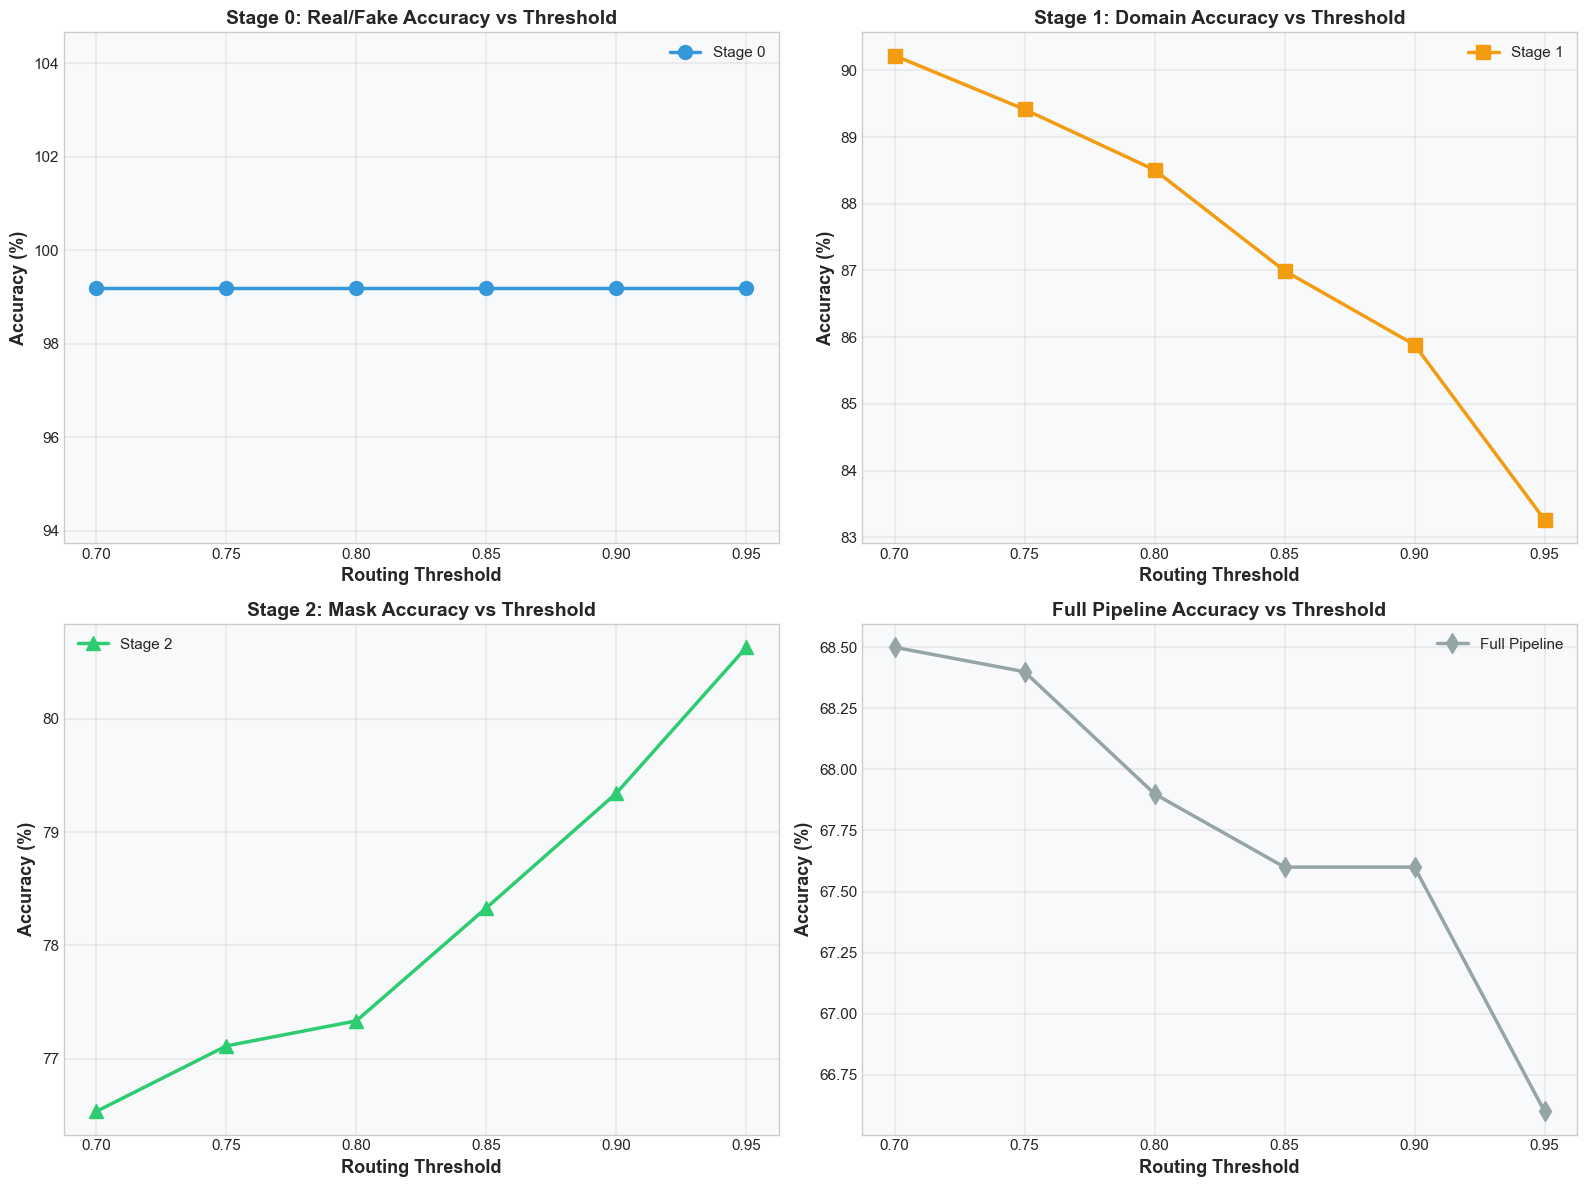

   ✅ Threshold vs Accuracy chart kaydedildi

2️⃣ Combined Accuracy Comparison oluşturuluyor...


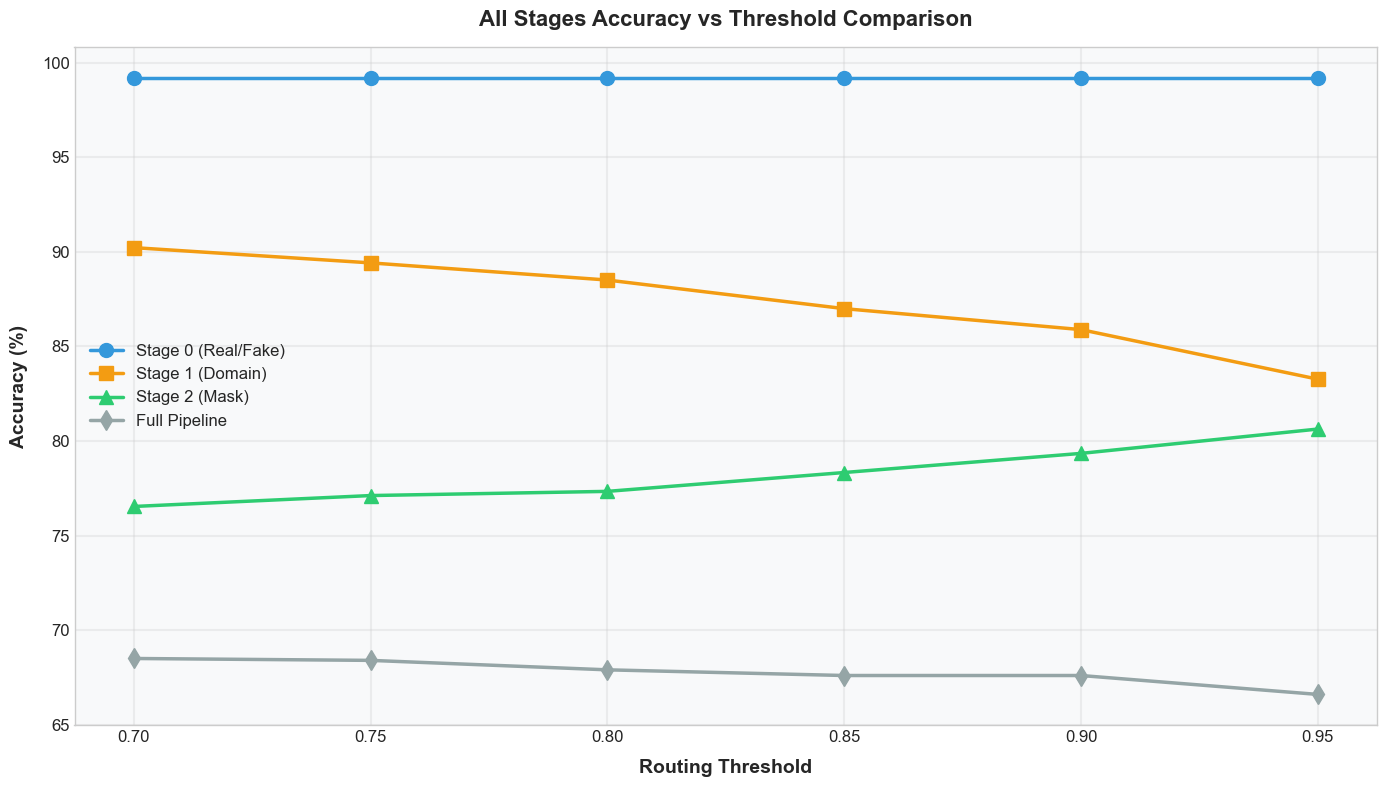

   ✅ Combined accuracy comparison kaydedildi

3️⃣ Multi-Expert Usage vs Threshold oluşturuluyor...


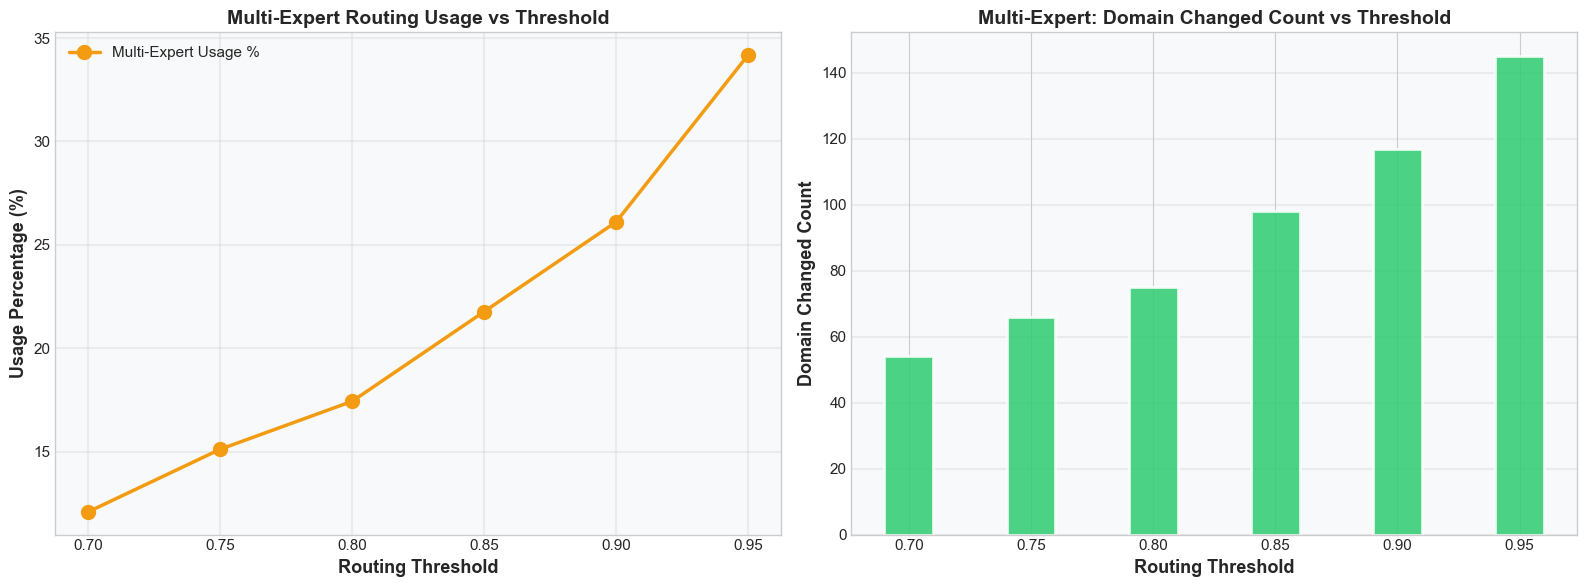

   ✅ Multi-expert usage comparison kaydedildi

✅ Threshold karşılaştırma görselleştirmeleri tamamlandı!


In [40]:
"""
📊 THRESHOLD POOL KARŞILAŞTIRMA GÖRSELLEŞTİRMELERİ
Tüm threshold'lar için accuracy karşılaştırmaları
"""

print("\n" + "="*70)
print("📊 THRESHOLD POOL KARŞILAŞTIRMA GÖRSELLEŞTİRMELERİ")
print("="*70)

if len(df_threshold_metrics) > 0:
    # Style ayarları
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.size'] = 11
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = '#f8f9fa'
    
    # Renk tanımları
    COLORS = {
        'correct': '#2ecc71',
        'wrong': '#e74c3c',
        'real': '#3498db',
        'fake': '#f39c12',
        'neutral': '#95a5a6'
    }
    
    # =============================================
    # 1. Threshold vs Accuracy Line Chart
    # =============================================
    
    print("\n1️⃣ Threshold vs Accuracy Line Chart oluşturuluyor...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Stage 0 Accuracy
    axes[0, 0].plot(df_threshold_metrics['threshold'], df_threshold_metrics['stage0_accuracy']*100, 
                    marker='o', linewidth=2.5, markersize=10, color=COLORS['real'], label='Stage 0')
    axes[0, 0].set_xlabel('Routing Threshold', fontsize=13, fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    axes[0, 0].set_title('Stage 0: Real/Fake Accuracy vs Threshold', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, linewidth=1.5)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].tick_params(labelsize=11)
    
    # Stage 1 Accuracy
    axes[0, 1].plot(df_threshold_metrics['threshold'], df_threshold_metrics['stage1_accuracy']*100, 
                    marker='s', linewidth=2.5, markersize=10, color=COLORS['fake'], label='Stage 1')
    axes[0, 1].set_xlabel('Routing Threshold', fontsize=13, fontweight='bold')
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    axes[0, 1].set_title('Stage 1: Domain Accuracy vs Threshold', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, linewidth=1.5)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].tick_params(labelsize=11)
    
    # Stage 2 Accuracy
    axes[1, 0].plot(df_threshold_metrics['threshold'], df_threshold_metrics['stage2_accuracy']*100, 
                    marker='^', linewidth=2.5, markersize=10, color=COLORS['correct'], label='Stage 2')
    axes[1, 0].set_xlabel('Routing Threshold', fontsize=13, fontweight='bold')
    axes[1, 0].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    axes[1, 0].set_title('Stage 2: Mask Accuracy vs Threshold', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, linewidth=1.5)
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].tick_params(labelsize=11)
    
    # Pipeline Accuracy
    axes[1, 1].plot(df_threshold_metrics['threshold'], df_threshold_metrics['pipeline_accuracy']*100, 
                    marker='d', linewidth=2.5, markersize=10, color=COLORS['neutral'], label='Full Pipeline')
    axes[1, 1].set_xlabel('Routing Threshold', fontsize=13, fontweight='bold')
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    axes[1, 1].set_title('Full Pipeline Accuracy vs Threshold', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, linewidth=1.5)
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'threshold_comparison_accuracy.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Threshold vs Accuracy chart kaydedildi")
    
    # =============================================
    # 2. Combined Accuracy Comparison
    # =============================================
    
    print("\n2️⃣ Combined Accuracy Comparison oluşturuluyor...")
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = df_threshold_metrics['threshold']
    ax.plot(x, df_threshold_metrics['stage0_accuracy']*100, marker='o', linewidth=2.5, 
           markersize=10, label='Stage 0 (Real/Fake)', color=COLORS['real'])
    ax.plot(x, df_threshold_metrics['stage1_accuracy']*100, marker='s', linewidth=2.5, 
           markersize=10, label='Stage 1 (Domain)', color=COLORS['fake'])
    ax.plot(x, df_threshold_metrics['stage2_accuracy']*100, marker='^', linewidth=2.5, 
           markersize=10, label='Stage 2 (Mask)', color=COLORS['correct'])
    ax.plot(x, df_threshold_metrics['pipeline_accuracy']*100, marker='d', linewidth=2.5, 
           markersize=10, label='Full Pipeline', color=COLORS['neutral'])
    
    ax.set_xlabel('Routing Threshold', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_title('All Stages Accuracy vs Threshold Comparison', fontsize=16, fontweight='bold', pad=15)
    ax.legend(fontsize=12, framealpha=0.9, loc='best')
    ax.grid(True, alpha=0.3, linewidth=1.5)
    ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'threshold_comparison_combined.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Combined accuracy comparison kaydedildi")
    
    # =============================================
    # 3. Multi-Expert Usage vs Threshold
    # =============================================
    
    print("\n3️⃣ Multi-Expert Usage vs Threshold oluşturuluyor...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Multi-expert usage percentage
    axes[0].plot(df_threshold_metrics['threshold'], df_threshold_metrics['multi_expert_usage_pct'], 
                marker='o', linewidth=2.5, markersize=10, color=COLORS['fake'], label='Multi-Expert Usage %')
    axes[0].set_xlabel('Routing Threshold', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Usage Percentage (%)', fontsize=13, fontweight='bold')
    axes[0].set_title('Multi-Expert Routing Usage vs Threshold', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, linewidth=1.5)
    axes[0].legend(fontsize=11)
    axes[0].tick_params(labelsize=11)
    
    # Multi-expert changed count
    axes[1].bar(df_threshold_metrics['threshold'], df_threshold_metrics['multi_expert_changed'], 
               width=0.02, color=COLORS['correct'], alpha=0.85, edgecolor='white', linewidth=2)
    axes[1].set_xlabel('Routing Threshold', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Domain Changed Count', fontsize=13, fontweight='bold')
    axes[1].set_title('Multi-Expert: Domain Changed Count vs Threshold', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y', linewidth=1.5)
    axes[1].tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'threshold_comparison_multi_expert.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Multi-expert usage comparison kaydedildi")
    
    print(f"\n✅ Threshold karşılaştırma görselleştirmeleri tamamlandı!")
else:
    print("⚠️  Threshold metrikleri bulunamadı, görselleştirme atlandı")


In [41]:
"""
📊 TEMEL METRİKLER
Tüm stage'ler için accuracy hesaplama
"""

print("\n" + "="*70)
print("📊 TEMEL METRİKLER")
print("="*70)

total_samples = len(df_results)

# Stage 0 metrikleri
stage0_correct = df_results['stage0_correct'].sum()
stage0_accuracy = stage0_correct / total_samples

print(f"\n🎯 STAGE 0 - Real/Fake Classification:")
print(f"   Accuracy: {stage0_accuracy*100:.2f}%")
print(f"   Correct: {stage0_correct:,} / {total_samples:,}")

# Stage 1 metrikleri (sadece fake olanlar için)
df_fake = df_results[df_results['pred_rf_name'] == 'fake'].copy()
if len(df_fake) > 0:
    stage1_correct = df_fake['domain_correct'].sum()
    stage1_accuracy = stage1_correct / len(df_fake)
    
    print(f"\n🎯 STAGE 1 - Domain Classification (Fake görüntüler için):")
    print(f"   Accuracy: {stage1_accuracy*100:.2f}%")
    print(f"   Correct: {stage1_correct:,} / {len(df_fake):,}")
    
    # Stage 2 metrikleri (sadece domain doğru olanlar için)
    df_domain_correct = df_fake[df_fake['domain_correct'] == True].copy()
    if len(df_domain_correct) > 0:
        stage2_correct = df_domain_correct['mask_correct'].sum()
        stage2_accuracy = stage2_correct / len(df_domain_correct)
        
        print(f"\n🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):")
        print(f"   Accuracy: {stage2_accuracy*100:.2f}%")
        print(f"   Correct: {stage2_correct:,} / {len(df_domain_correct):,}")
    else:
        stage2_accuracy = 0.0
        print(f"\n🎯 STAGE 2 - Mask Detection:")
        print(f"   ⚠️  Domain doğru örnek yok, Stage 2 test edilemedi")
else:
    stage1_accuracy = 0.0
    stage2_accuracy = 0.0
    print(f"\n🎯 STAGE 1 & 2:")
    print(f"   ⚠️  Fake görüntü yok, Stage 1 ve Stage 2 test edilemedi")

# Full pipeline accuracy
pipeline_correct = df_results['pipeline_correct'].sum()
pipeline_accuracy = pipeline_correct / total_samples

print(f"\n🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):")
print(f"   Accuracy: {pipeline_accuracy*100:.2f}%")
print(f"   Correct: {pipeline_correct:,} / {total_samples:,}")

# Özet dict
test_summary = {
    'total_samples': total_samples,
    'stage0_accuracy': stage0_accuracy,
    'stage0_correct': int(stage0_correct),
    'stage1_accuracy': stage1_accuracy if len(df_fake) > 0 else 0.0,
    'stage1_correct': int(stage1_correct) if len(df_fake) > 0 else 0,
    'stage2_accuracy': stage2_accuracy if len(df_fake) > 0 and len(df_domain_correct) > 0 else 0.0,
    'stage2_correct': int(stage2_correct) if len(df_fake) > 0 and len(df_domain_correct) > 0 else 0,
    'pipeline_accuracy': pipeline_accuracy,
    'pipeline_correct': int(pipeline_correct),
    'multi_expert_stats': stats
}

print(f"\n✅ Metrikler hesaplandı!")



📊 TEMEL METRİKLER

🎯 STAGE 0 - Real/Fake Classification:
   Accuracy: 99.20%
   Correct: 992 / 1,000

🎯 STAGE 1 - Domain Classification (Fake görüntüler için):
   Accuracy: 83.27%
   Correct: 826 / 992

🎯 STAGE 2 - Mask Detection (Domain doğru olanlar için):
   Accuracy: 80.63%
   Correct: 666 / 826

🔗 FULL PIPELINE (Stage 0 + Stage 1 + Stage 2):
   Accuracy: 66.60%
   Correct: 666 / 1,000

✅ Metrikler hesaplandı!


## 7️⃣ Stage 0 Görselleştirmeleri

Real/Fake analizleri: Confusion Matrix, Confidence Dağılımı, Domain bazında doğruluk



📊 STAGE 0 GÖRSELLEŞTİRMELERİ

1️⃣ Real/Fake Confusion Matrix oluşturuluyor...


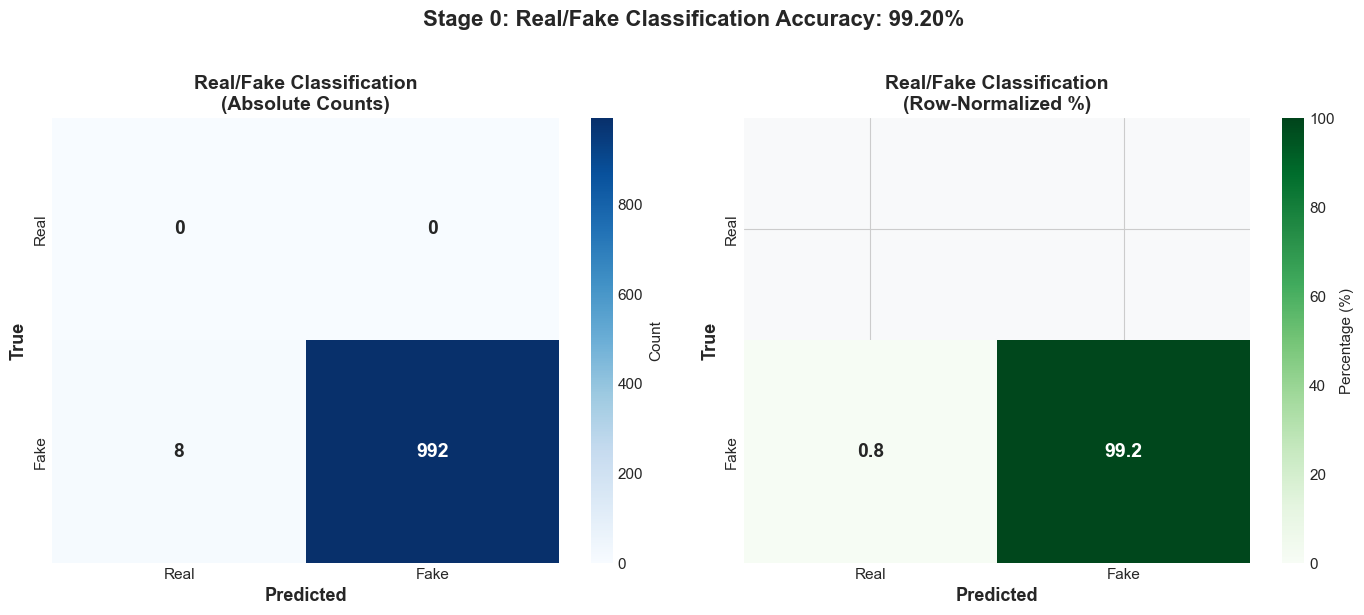

   ✅ Confusion matrix kaydedildi

2️⃣ Confidence dağılımı oluşturuluyor...


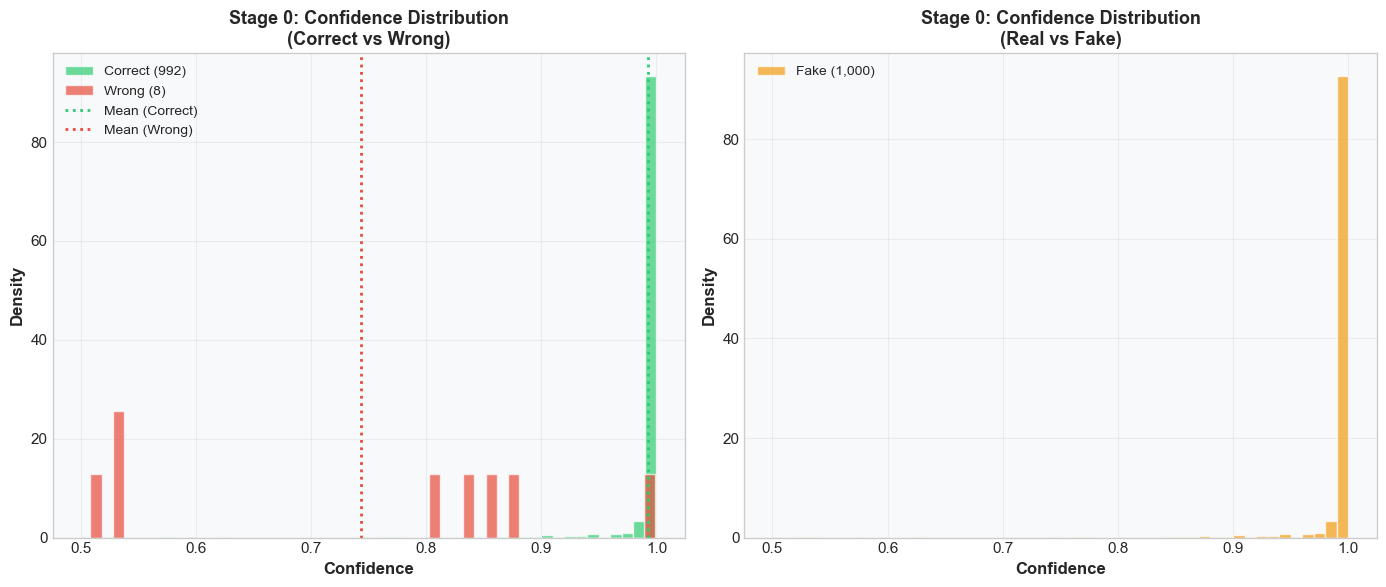

   ✅ Confidence dağılımı kaydedildi

3️⃣ Domain bazında Real/Fake analizi oluşturuluyor...


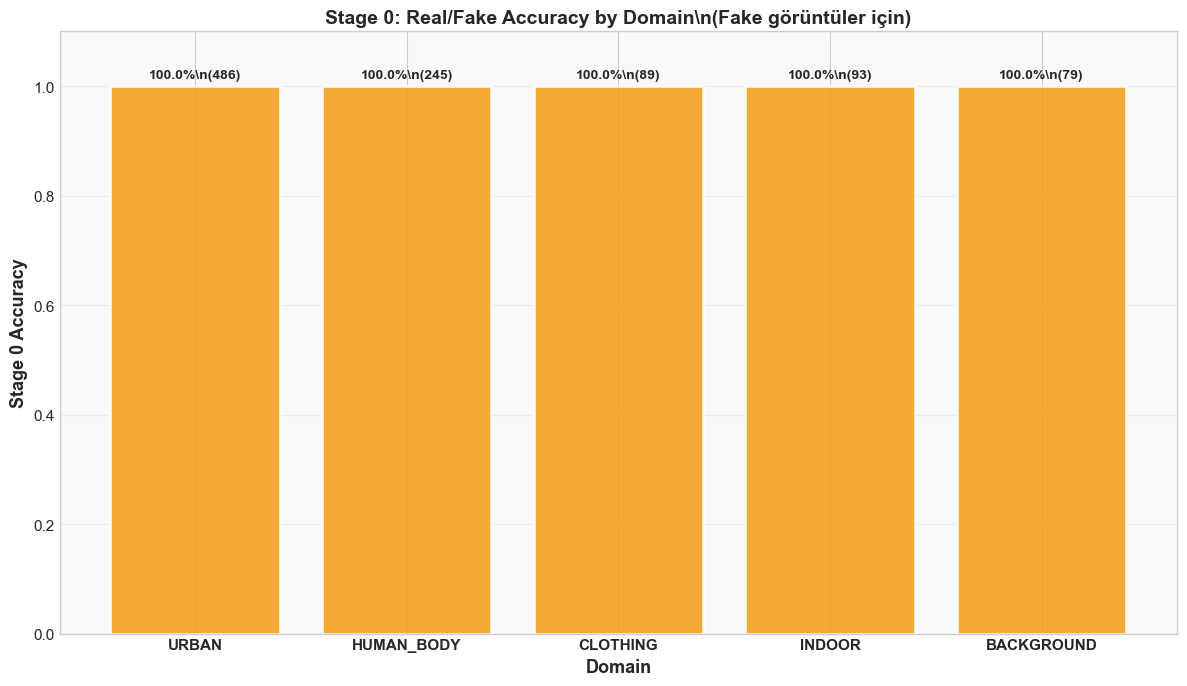

   ✅ Domain bazında analiz kaydedildi

✅ Stage 0 görselleştirmeleri tamamlandı!


In [42]:
"""
📊 STAGE 0 GÖRSELLEŞTİRMELERİ
Real/Fake Confusion Matrix, Confidence Dağılımı, Domain bazında analiz
"""

print("\n" + "="*70)
print("📊 STAGE 0 GÖRSELLEŞTİRMELERİ")
print("="*70)

# Style ayarları
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 11
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'

COLORS = {
    'correct': '#2ecc71',
    'wrong': '#e74c3c',
    'real': '#3498db',
    'fake': '#f39c12',
    'neutral': '#95a5a6'
}

# =============================================
# 1. Real/Fake Confusion Matrix
# =============================================

print("\n1️⃣ Real/Fake Confusion Matrix oluşturuluyor...")

true_rf = df_results['true_rf_label'].values
pred_rf = df_results['pred_rf_label'].values

cm_rf = confusion_matrix(true_rf, pred_rf, labels=[0, 1])
cm_rf_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sol: Raw counts
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            ax=axes[0], cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_xlabel('Predicted', fontsize=13, fontweight='bold')
axes[0].set_ylabel('True', fontsize=13, fontweight='bold')
axes[0].set_title('Real/Fake Classification\n(Absolute Counts)', fontsize=14, fontweight='bold')

# Sağ: Percentages
sns.heatmap(cm_rf_normalized, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'},
            annot_kws={'size': 14, 'weight': 'bold'}, vmin=0, vmax=100)
axes[1].set_xlabel('Predicted', fontsize=13, fontweight='bold')
axes[1].set_ylabel('True', fontsize=13, fontweight='bold')
axes[1].set_title('Real/Fake Classification\n(Row-Normalized %)', fontsize=14, fontweight='bold')

overall_acc = np.trace(cm_rf) / cm_rf.sum()
fig.suptitle(f'Stage 0: Real/Fake Classification Accuracy: {overall_acc*100:.2f}%', 
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'stage0_real_fake_confusion_matrix.png'), 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Confusion matrix kaydedildi")

# =============================================
# 2. Real/Fake Confidence Dağılımı
# =============================================

print("\n2️⃣ Confidence dağılımı oluşturuluyor...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sol: Histogram
correct_confs = df_results[df_results['stage0_correct'] == True]['rf_confidence'].values
wrong_confs = df_results[df_results['stage0_correct'] == False]['rf_confidence'].values

axes[0].hist(correct_confs, bins=50, alpha=0.7, color=COLORS['correct'], 
            label=f'Correct ({len(correct_confs):,})', density=True, edgecolor='white')
axes[0].hist(wrong_confs, bins=50, alpha=0.7, color=COLORS['wrong'], 
            label=f'Wrong ({len(wrong_confs):,})', density=True, edgecolor='white')
axes[0].axvline(x=correct_confs.mean(), color=COLORS['correct'], linestyle=':', linewidth=2, label='Mean (Correct)')
if len(wrong_confs) > 0:
    axes[0].axvline(x=wrong_confs.mean(), color=COLORS['wrong'], linestyle=':', linewidth=2, label='Mean (Wrong)')
axes[0].set_xlabel('Confidence', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[0].set_title('Stage 0: Confidence Distribution\n(Correct vs Wrong)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Sağ: Real vs Fake confidence
real_confs = df_results[df_results['true_rf_name'] == 'real']['rf_confidence'].values
fake_confs = df_results[df_results['true_rf_name'] == 'fake']['rf_confidence'].values

if len(real_confs) > 0:
    axes[1].hist(real_confs, bins=50, alpha=0.7, color=COLORS['real'], 
                label=f'Real ({len(real_confs):,})', density=True, edgecolor='white')
if len(fake_confs) > 0:
    axes[1].hist(fake_confs, bins=50, alpha=0.7, color=COLORS['fake'], 
                label=f'Fake ({len(fake_confs):,})', density=True, edgecolor='white')
axes[1].set_xlabel('Confidence', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[1].set_title('Stage 0: Confidence Distribution\n(Real vs Fake)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'stage0_confidence_distribution.png'), 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Confidence dağılımı kaydedildi")

# =============================================
# 3. Domain bazında Real/Fake doğruluğu
# =============================================

print("\n3️⃣ Domain bazında Real/Fake analizi oluşturuluyor...")

# Fake görüntülerin domain dağılımı
df_fake_only = df_results[df_results['true_rf_name'] == 'fake'].copy()
if len(df_fake_only) > 0:
    domain_rf_accuracy = []
    for domain in DOMAIN_NAMES:
        df_dom = df_fake_only[df_fake_only['true_domain_name'] == domain]
        if len(df_dom) > 0:
            acc = df_dom['stage0_correct'].mean()
            domain_rf_accuracy.append({
                'domain': domain,
                'accuracy': acc,
                'count': len(df_dom)
            })
    
    if domain_rf_accuracy:
        df_domain_rf = pd.DataFrame(domain_rf_accuracy)
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        x = np.arange(len(df_domain_rf))
        bars = ax.bar(x, df_domain_rf['accuracy'], color=COLORS['fake'], 
                     edgecolor='white', linewidth=2, alpha=0.85)
        
        # Bar labels
        for bar, acc, count in zip(bars, df_domain_rf['accuracy'], df_domain_rf['count']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc*100:.1f}%\\n({count:,})',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_xlabel('Domain', fontsize=13, fontweight='bold')
        ax.set_ylabel('Stage 0 Accuracy', fontsize=13, fontweight='bold')
        ax.set_title('Stage 0: Real/Fake Accuracy by Domain\\n(Fake görüntüler için)', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(df_domain_rf['domain'], fontsize=11, fontweight='bold')
        ax.set_ylim([0, 1.1])
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(os.path.join(VIZ_FOLDER, 'stage0_domain_accuracy.png'), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        print(f"   ✅ Domain bazında analiz kaydedildi")
    else:
        print(f"   ⚠️  Fake görüntü bulunamadı, analiz atlandı")
else:
    print(f"   ⚠️  Fake görüntü bulunamadı, analiz atlandı")

print(f"\n✅ Stage 0 görselleştirmeleri tamamlandı!")


## 8️⃣ Stage 1 & 2 Görselleştirmeleri

Confusion matrices, error flow, confidence distributions, per-domain accuracy



📊 STAGE 1 & 2 GÖRSELLEŞTİRMELERİ

1️⃣ Stage 1 Domain Confusion Matrix oluşturuluyor...


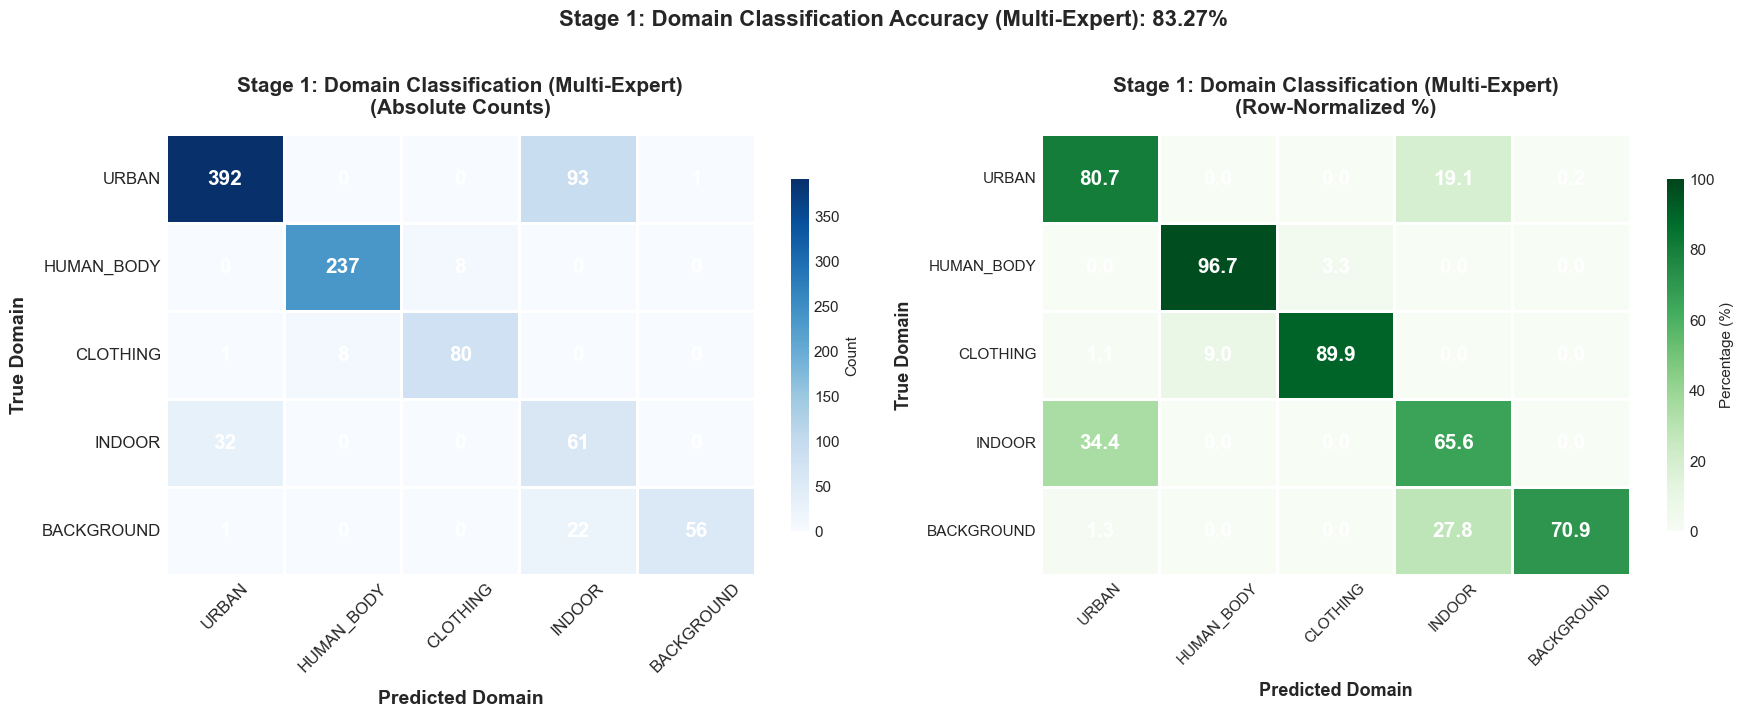

   ✅ Stage 1 confusion matrix kaydedildi

2️⃣ Stage 2 Confusion Matrices oluşturuluyor...


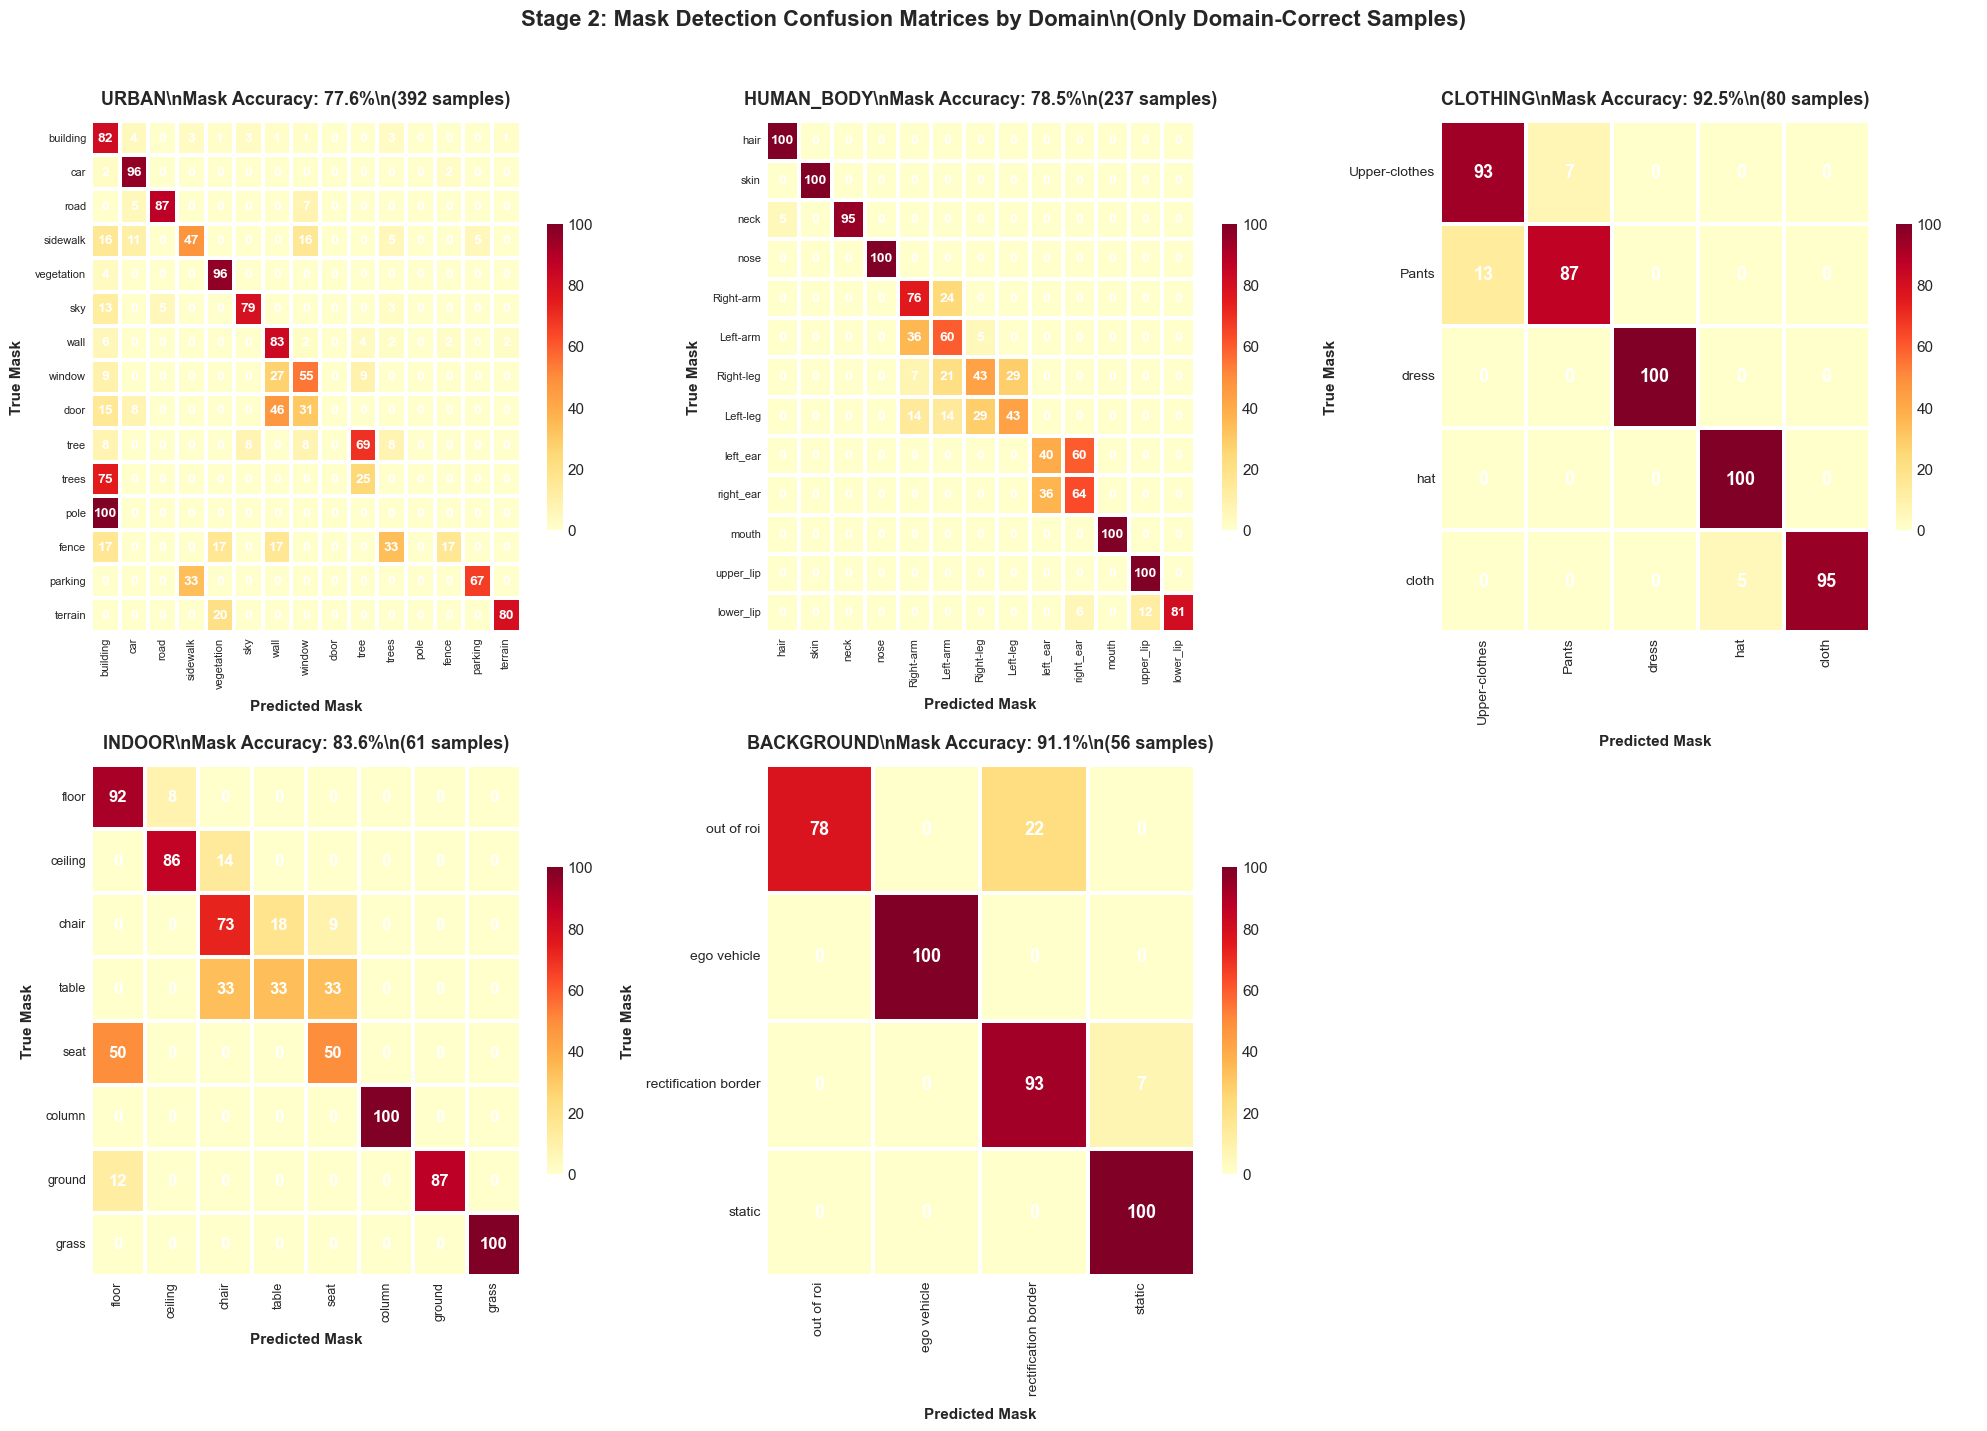

   ✅ Stage 2 confusion matrices kaydedildi

3️⃣ Per-domain accuracy chart oluşturuluyor...


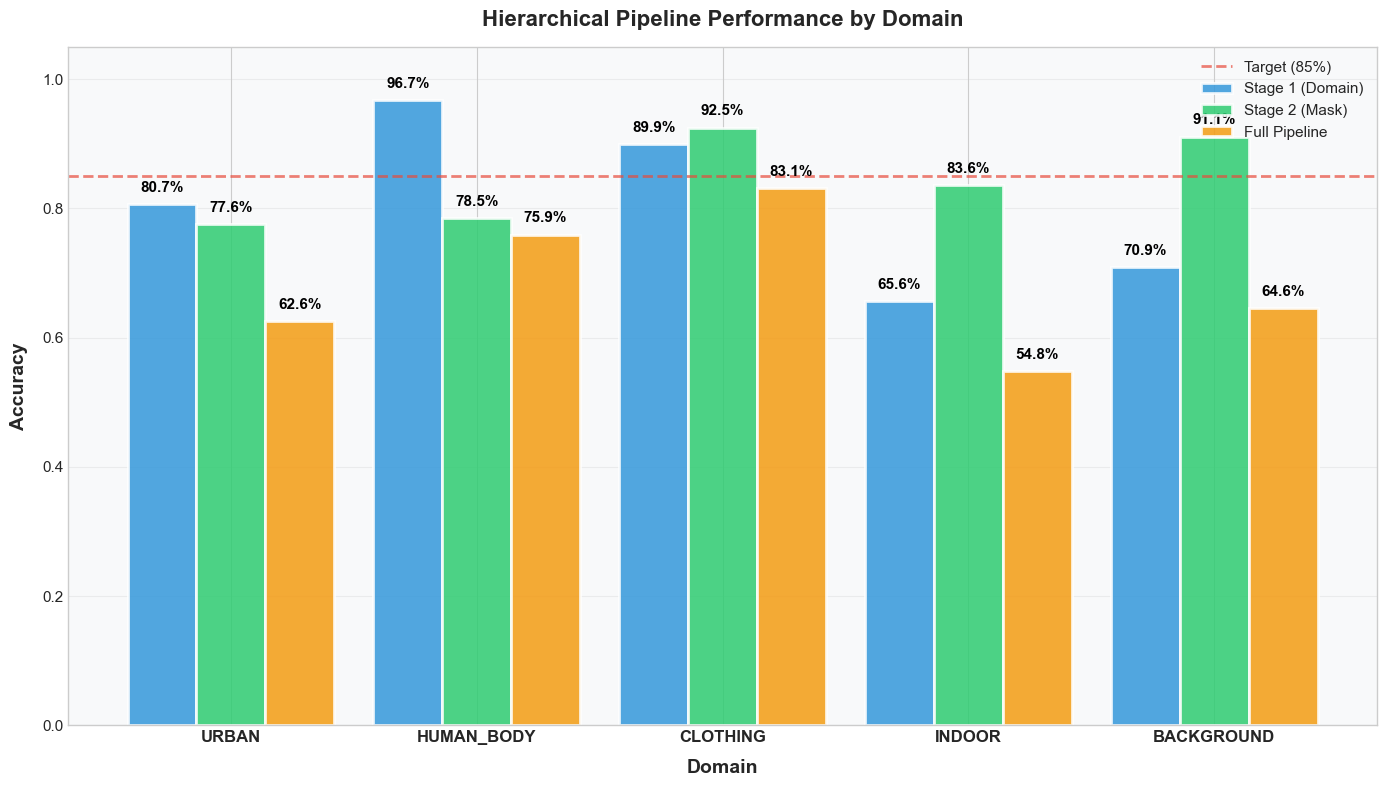

   ✅ Per-domain accuracy chart kaydedildi

✅ Stage 1 & 2 görselleştirmeleri tamamlandı!


In [43]:
"""
📊 STAGE 1 & 2 GÖRSELLEŞTİRMELERİ - BÖLÜM 1
Confusion Matrices ve Performance Charts
"""

print("\n" + "="*70)
print("📊 STAGE 1 & 2 GÖRSELLEŞTİRMELERİ")
print("="*70)

# Fake görüntüler için analiz
df_fake = df_results[df_results['pred_rf_name'] == 'fake'].copy()

if len(df_fake) == 0:
    print("\n⚠️  Fake görüntü bulunamadı, Stage 1 & 2 görselleştirmeleri atlanıyor")
else:
    # =============================================
    # 1. Stage 1 Domain Confusion Matrix
    # =============================================
    
    print("\n1️⃣ Stage 1 Domain Confusion Matrix oluşturuluyor...")
    
    true_domains = df_fake['true_domain_label'].values
    pred_domains = df_fake['final_pred_domain_label'].values
    
    cm_domain = confusion_matrix(true_domains, pred_domains, labels=range(NUM_DOMAINS))
    cm_domain_normalized = cm_domain.astype('float') / (cm_domain.sum(axis=1)[:, np.newaxis] + 1e-10) * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Sol: Raw counts - İyileştirilmiş annotation
    matrix_size = len(DOMAIN_NAMES)
    font_size = max(12, 16 - matrix_size // 3)
    sns.heatmap(cm_domain, annot=True, fmt='d', cmap='Blues',
                xticklabels=DOMAIN_NAMES, yticklabels=DOMAIN_NAMES,
                ax=axes[0], cbar_kws={'label': 'Count', 'shrink': 0.8},
                annot_kws={'size': font_size, 'weight': 'bold', 'color': 'white'},
                linewidths=2, linecolor='white')
    axes[0].set_xlabel('Predicted Domain', fontsize=14, fontweight='bold', labelpad=10)
    axes[0].set_ylabel('True Domain', fontsize=14, fontweight='bold', labelpad=10)
    axes[0].set_title('Stage 1: Domain Classification (Multi-Expert)\n(Absolute Counts)', 
                     fontsize=15, fontweight='bold', pad=15)
    axes[0].tick_params(axis='x', rotation=45, labelsize=12)
    axes[0].tick_params(axis='y', rotation=0, labelsize=12)
    
    # Sağ: Percentages - İyileştirilmiş annotation
    sns.heatmap(cm_domain_normalized, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=DOMAIN_NAMES, yticklabels=DOMAIN_NAMES,
                ax=axes[1], cbar_kws={'label': 'Percentage (%)', 'shrink': 0.8},
                annot_kws={'size': font_size, 'weight': 'bold', 'color': 'white'},
                linewidths=2, linecolor='white', vmin=0, vmax=100)
    axes[1].set_xlabel('Predicted Domain', fontsize=13, fontweight='bold', labelpad=10)
    axes[1].set_ylabel('True Domain', fontsize=13, fontweight='bold', labelpad=10)
    axes[1].set_title('Stage 1: Domain Classification (Multi-Expert)\n(Row-Normalized %)', 
                     fontsize=15, fontweight='bold', pad=15)
    axes[1].tick_params(axis='x', rotation=45, labelsize=11)
    axes[1].tick_params(axis='y', rotation=0, labelsize=11)
    
    overall_acc = np.trace(cm_domain) / cm_domain.sum() if cm_domain.sum() > 0 else 0
    fig.suptitle(f'Stage 1: Domain Classification Accuracy (Multi-Expert): {overall_acc*100:.2f}%', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'stage1_domain_confusion_matrix.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Stage 1 confusion matrix kaydedildi")
    
    # =============================================
    # 2. Stage 2 Confusion Matrices (Her domain için)
    # =============================================
    
    print("\n2️⃣ Stage 2 Confusion Matrices oluşturuluyor...")
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    axes = axes.flatten()
    
    for idx, domain in enumerate(DOMAIN_NAMES):
        ax = axes[idx]
        
        df_domain_correct = df_fake[(df_fake['true_domain_name'] == domain) & 
                                    (df_fake['domain_correct'] == True)]
        
        if len(df_domain_correct) == 0:
            ax.text(0.5, 0.5, f'{domain}\\nNo data', ha='center', va='center', fontsize=14)
            ax.set_title(f'{domain} - No Data')
            continue
        
        true_masks = df_domain_correct['true_mask_label'].values
        pred_masks = df_domain_correct['pred_mask_label'].values
        
        unique_labels = sorted(set(true_masks) | set(pred_masks))
        
        if len(unique_labels) == 0:
            ax.text(0.5, 0.5, f'{domain}\\nNo valid masks', ha='center', va='center', fontsize=14)
            continue
        
        l2m = label_to_mask.get(domain, {})
        mask_names = [l2m.get(l) or l2m.get(str(l), f"Mask{l}") for l in unique_labels]
        
        cm_mask = confusion_matrix(true_masks, pred_masks, labels=unique_labels)
        cm_mask_norm = cm_mask.astype('float') / (cm_mask.sum(axis=1)[:, np.newaxis] + 1e-10) * 100
        
        # Dinamik font size
        mask_font_size = max(10, 14 - len(unique_labels)//3)
        sns.heatmap(cm_mask_norm, annot=True, fmt='.0f', cmap='YlOrRd',
                   xticklabels=mask_names, yticklabels=mask_names,
                   ax=ax, cbar_kws={'shrink': 0.6},
                   annot_kws={'size': mask_font_size, 'weight': 'bold', 'color': 'white'},
                   linewidths=1.5, linecolor='white', vmin=0, vmax=100)
        
        domain_mask_acc = np.trace(cm_mask) / cm_mask.sum() if cm_mask.sum() > 0 else 0
        
        ax.set_xlabel('Predicted Mask', fontsize=11, fontweight='bold', labelpad=8)
        ax.set_ylabel('True Mask', fontsize=11, fontweight='bold', labelpad=8)
        ax.set_title(f'{domain}\\nMask Accuracy: {domain_mask_acc*100:.1f}%\\n({len(df_domain_correct):,} samples)', 
                    fontsize=13, fontweight='bold', pad=12)
        tick_font_size = max(8, 11 - len(unique_labels)//3)
        ax.tick_params(axis='x', rotation=90, labelsize=tick_font_size)
        ax.tick_params(axis='y', rotation=0, labelsize=tick_font_size)
    
    axes[5].axis('off')
    
    fig.suptitle('Stage 2: Mask Detection Confusion Matrices by Domain\\n(Only Domain-Correct Samples)', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'stage2_mask_confusion_matrices.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Stage 2 confusion matrices kaydedildi")
    
    # =============================================
    # 3. Per-Domain Accuracy Bar Chart
    # =============================================
    
    print("\n3️⃣ Per-domain accuracy chart oluşturuluyor...")
    
    # Domain bazında accuracy hesapla
    domain_analysis = []
    for domain in DOMAIN_NAMES:
        df_dom = df_fake[df_fake['true_domain_name'] == domain]
        if len(df_dom) == 0:
            continue
        
        s1_acc = df_dom['domain_correct'].mean()
        df_dom_correct = df_dom[df_dom['domain_correct'] == True]
        s2_acc = df_dom_correct['mask_correct'].mean() if len(df_dom_correct) > 0 else 0.0
        pipeline_acc = df_dom['pipeline_correct'].mean() if 'pipeline_correct' in df_dom.columns else 0.0
        
        domain_analysis.append({
            'domain': domain,
            'stage1_accuracy': s1_acc,
            'stage2_accuracy': s2_acc,
            'pipeline_accuracy': pipeline_acc
        })
    
    if domain_analysis:
        df_domain_analysis = pd.DataFrame(domain_analysis)
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        x = np.arange(len(df_domain_analysis))
        width = 0.28
        
        s1_accs = df_domain_analysis['stage1_accuracy'].values
        s2_accs = df_domain_analysis['stage2_accuracy'].values
        pipeline_accs = df_domain_analysis['pipeline_accuracy'].values
        
        bars1 = ax.bar(x - width, s1_accs, width, label='Stage 1 (Domain)', 
                      color=COLORS['real'], edgecolor='white', linewidth=2, alpha=0.85)
        bars2 = ax.bar(x, s2_accs, width, label='Stage 2 (Mask)', 
                      color=COLORS['correct'], edgecolor='white', linewidth=2, alpha=0.85)
        bars3 = ax.bar(x + width, pipeline_accs, width, label='Full Pipeline', 
                      color=COLORS['fake'], edgecolor='white', linewidth=2, alpha=0.85)
        
        ax.axhline(y=0.85, color=COLORS['wrong'], linestyle='--', linewidth=2, 
                  alpha=0.7, label='Target (85%)')
        
        ax.set_xlabel('Domain', fontsize=14, fontweight='bold', labelpad=10)
        ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold', labelpad=10)
        ax.set_title('Hierarchical Pipeline Performance by Domain', fontsize=16, fontweight='bold', pad=15)
        ax.set_xticks(x)
        ax.set_xticklabels(df_domain_analysis['domain'], fontsize=12, fontweight='bold')
        ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
        ax.set_ylim([0, 1.05])
        ax.grid(True, alpha=0.3, axis='y')
        
        # İyileştirilmiş bar labels
        max_value = max(s1_accs.max() if len(s1_accs) > 0 else 0, 
                       s2_accs.max() if len(s2_accs) > 0 else 0,
                       pipeline_accs.max() if len(pipeline_accs) > 0 else 0)
        
        for bars, values in [(bars1, s1_accs), (bars2, s2_accs), (bars3, pipeline_accs)]:
            for bar, val in zip(bars, values):
                height = bar.get_height()
                # Yeterli yükseklik kontrolü
                if height > max_value * 0.05:
                    text_y = height + max_value * 0.015
                    text_color = 'black'
                    va_pos = 'bottom'
                    bbox_props = None
                else:
                    text_y = height / 2
                    text_color = 'white'
                    va_pos = 'center'
                    bbox_props = dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7, edgecolor='none')
                
                ax.text(bar.get_x() + bar.get_width()/2., text_y,
                       f'{val*100:.1f}%',
                       ha='center', va=va_pos,
                       fontsize=11, fontweight='bold', color=text_color,
                       bbox=bbox_props)
        
        plt.tight_layout()
        plt.savefig(os.path.join(VIZ_FOLDER, 'per_domain_accuracy.png'), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        print(f"   ✅ Per-domain accuracy chart kaydedildi")

print(f"\n✅ Stage 1 & 2 görselleştirmeleri tamamlandı!")



📊 PIPELINE FLOW GÖRSELLEŞTİRMELERİ

1️⃣ Waterfall Chart oluşturuluyor...


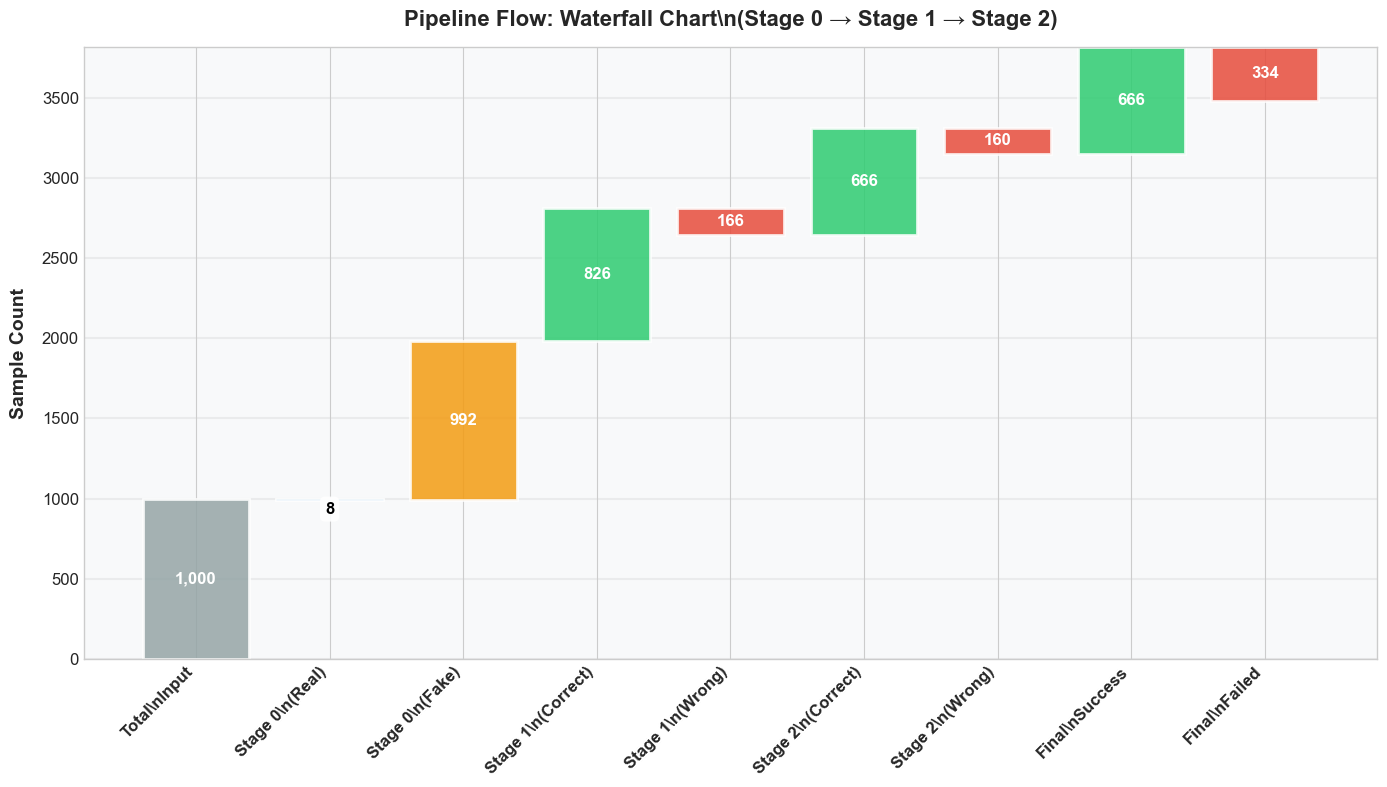

   ✅ Waterfall chart kaydedildi

2️⃣ Error Flow Diagram oluşturuluyor...


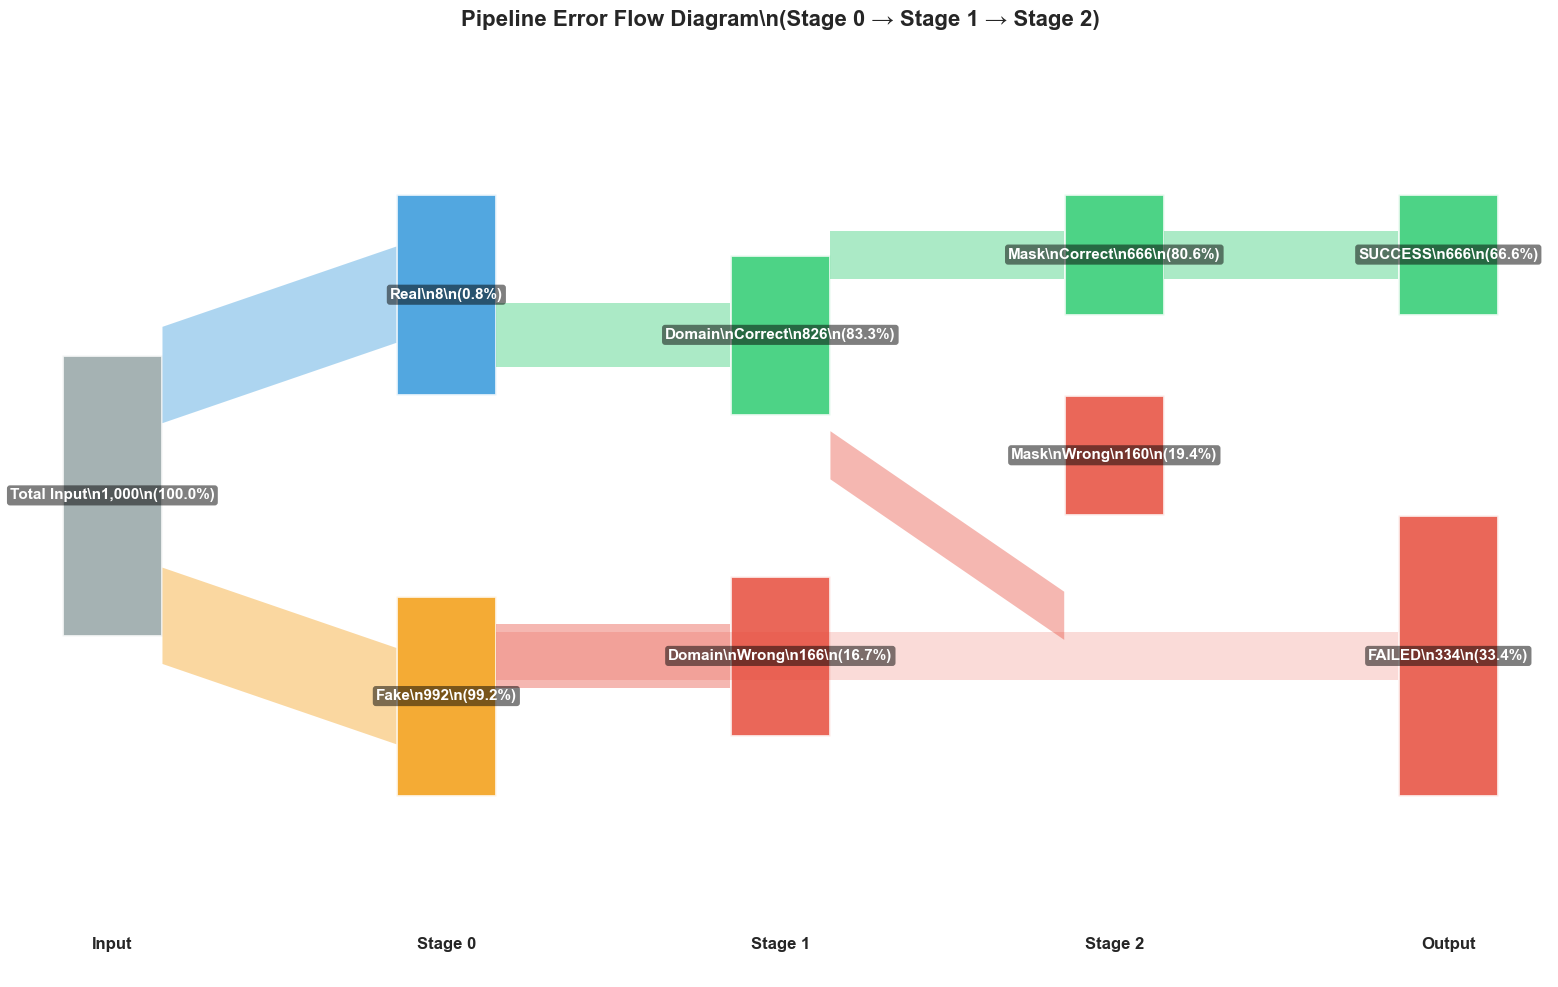

   ✅ Error flow diagram kaydedildi

3️⃣ Decision Tree oluşturuluyor...


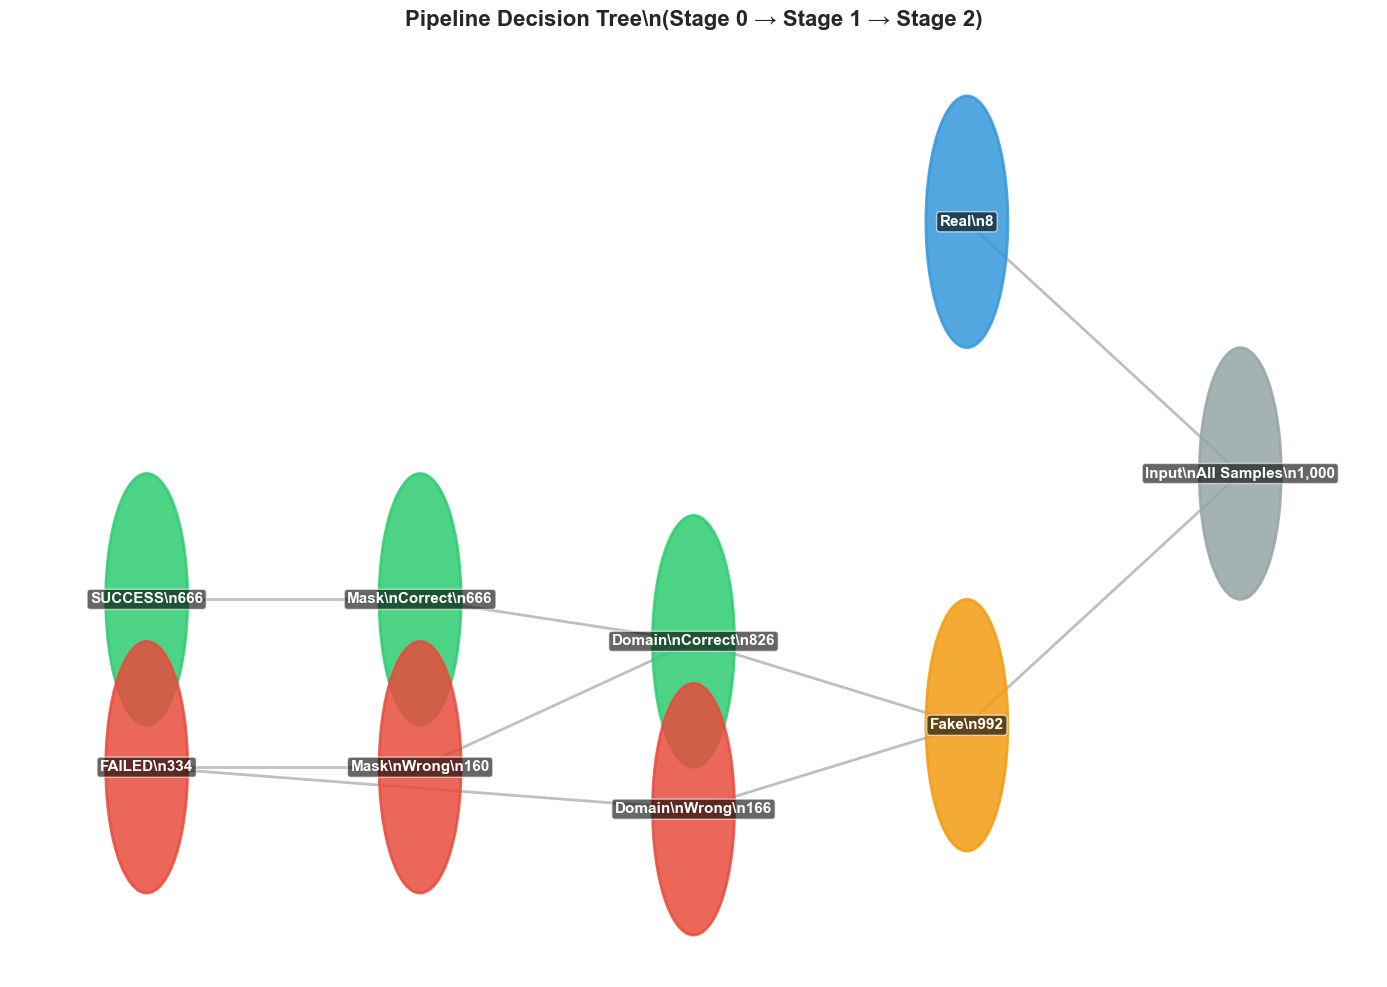

   ✅ Decision tree kaydedildi

✅ Pipeline flow görselleştirmeleri tamamlandı!


In [44]:
"""
📊 PIPELINE FLOW GÖRSELLEŞTİRMELERİ
Sankey Diagram, Waterfall Chart, Decision Tree
"""

print("\n" + "="*70)
print("📊 PIPELINE FLOW GÖRSELLEŞTİRMELERİ")
print("="*70)

# Hesaplamalar
n_total = len(df_results)
n_stage0_real = len(df_results[df_results['pred_rf_name'] == 'real'])
n_stage0_fake = len(df_results[df_results['pred_rf_name'] == 'fake'])

df_fake = df_results[df_results['pred_rf_name'] == 'fake'].copy()
if len(df_fake) > 0:
    n_stage1_correct = df_fake['domain_correct'].sum()
    n_stage1_wrong = len(df_fake) - n_stage1_correct
    
    df_stage1_correct = df_fake[df_fake['domain_correct'] == True].copy()
    if len(df_stage1_correct) > 0:
        n_stage2_correct = df_stage1_correct['mask_correct'].sum()
        n_stage2_wrong = len(df_stage1_correct) - n_stage2_correct
    else:
        n_stage2_correct = 0
        n_stage2_wrong = 0
else:
    n_stage1_correct = 0
    n_stage1_wrong = 0
    n_stage2_correct = 0
    n_stage2_wrong = 0

n_final_correct = n_stage2_correct  # Full pipeline success
n_final_wrong = n_stage0_real + n_stage1_wrong + n_stage2_wrong  # All errors

# =============================================
# 1. Waterfall Chart
# =============================================

print("\n1️⃣ Waterfall Chart oluşturuluyor...")

fig, ax = plt.subplots(figsize=(14, 8))

stages = ['Total\\nInput', 'Stage 0\\n(Real)', 'Stage 0\\n(Fake)', 
         'Stage 1\\n(Correct)', 'Stage 1\\n(Wrong)', 
         'Stage 2\\n(Correct)', 'Stage 2\\n(Wrong)', 'Final\\nSuccess', 'Final\\nFailed']
values = [n_total, -n_stage0_real, n_stage0_fake, 
         n_stage1_correct, -n_stage1_wrong,
         n_stage2_correct, -n_stage2_wrong,
         n_final_correct, -n_final_wrong]

colors_waterfall = [COLORS['neutral'], COLORS['real'], COLORS['fake'],
                   COLORS['correct'], COLORS['wrong'],
                   COLORS['correct'], COLORS['wrong'],
                   COLORS['correct'], COLORS['wrong']]

cumulative = np.cumsum([0] + values[:-1])
cumulative = np.append(cumulative, cumulative[-1] + values[-1])

# İyileştirilmiş waterfall chart - değerlerin net gözükmesi
max_abs_val = max(abs(v) for v in values)
for i, (stage, val, color, cum) in enumerate(zip(stages, values, colors_waterfall, cumulative[:-1])):
    abs_val = abs(val)
    bar_height = abs_val
    
    if val > 0:
        ax.bar(i, val, bottom=cum, color=color, alpha=0.85, edgecolor='white', linewidth=2)
        # Bar yeterince yüksekse içte, değilse üstte
        if bar_height > max_abs_val * 0.1:
            text_y = cum + val/2
            text_color = 'white'
            va_pos = 'center'
            bbox_props = None
        else:
            text_y = cum + val + max_abs_val * 0.01
            text_color = 'black'
            va_pos = 'bottom'
            bbox_props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='none')
    else:
        ax.bar(i, val, bottom=cum, color=color, alpha=0.85, edgecolor='white', linewidth=2)
        # Negatif bar'lar için
        if bar_height > max_abs_val * 0.1:
            text_y = cum + val/2
            text_color = 'white'
            va_pos = 'center'
            bbox_props = None
        else:
            text_y = cum + val - max_abs_val * 0.01
            text_color = 'black'
            va_pos = 'top'
            bbox_props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='none')
    
    ax.text(i, text_y, f'{abs_val:,}', 
           ha='center', va=va_pos,
           fontsize=12, fontweight='bold', color=text_color,
           bbox=bbox_props)

ax.set_xticks(range(len(stages)))
ax.set_xticklabels(stages, fontsize=12, fontweight='bold', rotation=45, ha='right')
ax.set_ylabel('Sample Count', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('Pipeline Flow: Waterfall Chart\\n(Stage 0 → Stage 1 → Stage 2)', 
            fontsize=16, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y', linewidth=1.5)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'pipeline_waterfall_chart.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Waterfall chart kaydedildi")

# =============================================
# 2. Error Flow Diagram (Sankey-style)
# =============================================

print("\n2️⃣ Error Flow Diagram oluşturuluyor...")

fig, ax = plt.subplots(figsize=(16, 10))

def draw_box(ax, x, y, width, height, color, label, count, pct):
    """Box çiz - İyileştirilmiş text"""
    rect = plt.Rectangle((x - width/2, y - height/2), width, height, 
                        facecolor=color, edgecolor='white', linewidth=2, alpha=0.85)
    ax.add_patch(rect)
    # Font size ve text iyileştirmesi
    ax.text(x, y, f'{label}\\n{count:,}\\n({pct:.1f}%)', 
           ha='center', va='center', fontsize=11, fontweight='bold', color='white',
           bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.5, edgecolor='none'))

def draw_flow(ax, x1, y1, x2, y2, width, color, alpha=0.4):
    """Akış çizgisi"""
    ax.fill([x1, x2, x2, x1], [y1-width/2, y2-width/2, y2+width/2, y1+width/2], 
           color=color, alpha=alpha, linewidth=0)

# Box'lar
draw_box(ax, 0, 0.5, 0.3, 0.35, COLORS['neutral'], 'Total Input', n_total, 100)

# Stage 0
s0_real_pct = n_stage0_real/n_total*100
s0_fake_pct = n_stage0_fake/n_total*100
draw_box(ax, 1, 0.75, 0.3, 0.25, COLORS['real'], 'Real', n_stage0_real, s0_real_pct)
draw_box(ax, 1, 0.25, 0.3, 0.25, COLORS['fake'], 'Fake', n_stage0_fake, s0_fake_pct)

# Stage 1 (sadece fake için)
if n_stage0_fake > 0:
    s1_correct_pct = n_stage1_correct/n_stage0_fake*100
    s1_wrong_pct = n_stage1_wrong/n_stage0_fake*100
    draw_box(ax, 2, 0.7, 0.3, 0.2, COLORS['correct'], 'Domain\\nCorrect', n_stage1_correct, s1_correct_pct)
    draw_box(ax, 2, 0.3, 0.3, 0.2, COLORS['wrong'], 'Domain\\nWrong', n_stage1_wrong, s1_wrong_pct)

# Stage 2 (sadece domain correct için)
if n_stage1_correct > 0:
    s2_correct_pct = n_stage2_correct/n_stage1_correct*100
    s2_wrong_pct = n_stage2_wrong/n_stage1_correct*100
    draw_box(ax, 3, 0.8, 0.3, 0.15, COLORS['correct'], 'Mask\\nCorrect', n_stage2_correct, s2_correct_pct)
    draw_box(ax, 3, 0.55, 0.3, 0.15, COLORS['wrong'], 'Mask\\nWrong', n_stage2_wrong, s2_wrong_pct)

# Final
final_correct_pct = n_final_correct/n_total*100
final_wrong_pct = n_final_wrong/n_total*100
draw_box(ax, 4, 0.8, 0.3, 0.15, COLORS['correct'], 'SUCCESS', n_final_correct, final_correct_pct)
draw_box(ax, 4, 0.3, 0.3, 0.35, COLORS['wrong'], 'FAILED', n_final_wrong, final_wrong_pct)

# Akış çizgileri
draw_flow(ax, 0.15, 0.65, 0.85, 0.75, 0.12, COLORS['real'])
draw_flow(ax, 0.15, 0.35, 0.85, 0.25, 0.12, COLORS['fake'])
if n_stage0_fake > 0:
    draw_flow(ax, 1.15, 0.7, 1.85, 0.7, 0.08, COLORS['correct'])
    draw_flow(ax, 1.15, 0.3, 1.85, 0.3, 0.08, COLORS['wrong'])
if n_stage1_correct > 0:
    draw_flow(ax, 2.15, 0.8, 2.85, 0.8, 0.06, COLORS['correct'])
    draw_flow(ax, 2.15, 0.55, 2.85, 0.35, 0.06, COLORS['wrong'])
draw_flow(ax, 3.15, 0.8, 3.85, 0.8, 0.06, COLORS['correct'])
draw_flow(ax, 1.15, 0.3, 3.85, 0.3, 0.06, COLORS['wrong'], alpha=0.2)

# Stage labels
for i, stage in enumerate(['Input', 'Stage 0', 'Stage 1', 'Stage 2', 'Output']):
    ax.text(i, -0.05, stage, ha='center', va='top', fontsize=12, fontweight='bold')

ax.set_xlim(-0.3, 4.3)
ax.set_ylim(-0.1, 1.05)
ax.axis('off')
ax.set_title('Pipeline Error Flow Diagram\\n(Stage 0 → Stage 1 → Stage 2)', 
            fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'pipeline_error_flow_diagram.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Error flow diagram kaydedildi")

# =============================================
# 3. Decision Tree (Basitleştirilmiş)
# =============================================

print("\n3️⃣ Decision Tree oluşturuluyor...")

fig, ax = plt.subplots(figsize=(14, 10))

# Decision tree yapısı
tree_nodes = {
    'root': (2, 0.5, 'Input\\nAll Samples', n_total),
    's0_real': (1, 0.8, 'Real', n_stage0_real),
    's0_fake': (1, 0.2, 'Fake', n_stage0_fake),
    's1_correct': (0, 0.3, 'Domain\\nCorrect', n_stage1_correct),
    's1_wrong': (0, 0.1, 'Domain\\nWrong', n_stage1_wrong),
    's2_correct': (-1, 0.35, 'Mask\\nCorrect', n_stage2_correct),
    's2_wrong': (-1, 0.15, 'Mask\\nWrong', n_stage2_wrong),
    'success': (-2, 0.35, 'SUCCESS', n_final_correct),
    'failed': (-2, 0.15, 'FAILED', n_final_wrong)
}

# Node'ları çiz
for node_id, (x, y, label, count) in tree_nodes.items():
    if 'correct' in node_id or node_id == 'success':
        color = COLORS['correct']
    elif 'wrong' in node_id or node_id == 'failed':
        color = COLORS['wrong']
    elif 'real' in node_id:
        color = COLORS['real']
    elif 'fake' in node_id:
        color = COLORS['fake']
    else:
        color = COLORS['neutral']
    
    circle = plt.Circle((x, y), 0.15, color=color, alpha=0.85, edgecolor='white', linewidth=2)
    ax.add_patch(circle)
    # İyileştirilmiş text gösterimi
    ax.text(x, y, f'{label}\\n{count:,}', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white',
           bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.6, edgecolor='white', linewidth=1))

# Bağlantılar
connections = [
    ('root', 's0_real'), ('root', 's0_fake'),
    ('s0_fake', 's1_correct'), ('s0_fake', 's1_wrong'),
    ('s1_correct', 's2_correct'), ('s1_correct', 's2_wrong'),
    ('s2_correct', 'success'), ('s1_wrong', 'failed'), ('s2_wrong', 'failed')
]

for start, end in connections:
    x1, y1, _, _ = tree_nodes[start]
    x2, y2, _, _ = tree_nodes[end]
    ax.plot([x1, x2], [y1, y2], color='gray', linewidth=2, alpha=0.5, zorder=0)

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-0.1, 1.0)
ax.axis('off')
ax.set_title('Pipeline Decision Tree\\n(Stage 0 → Stage 1 → Stage 2)', 
            fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'pipeline_decision_tree.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Decision tree kaydedildi")

print(f"\n✅ Pipeline flow görselleştirmeleri tamamlandı!")


## 🔟 Gelişmiş Hata Analizi

3D Error Heatmap, Error Sample Grids, Error Timeline



🔍 GELİŞMİŞ HATA ANALİZİ

1️⃣ 3D Error Heatmap oluşturuluyor...


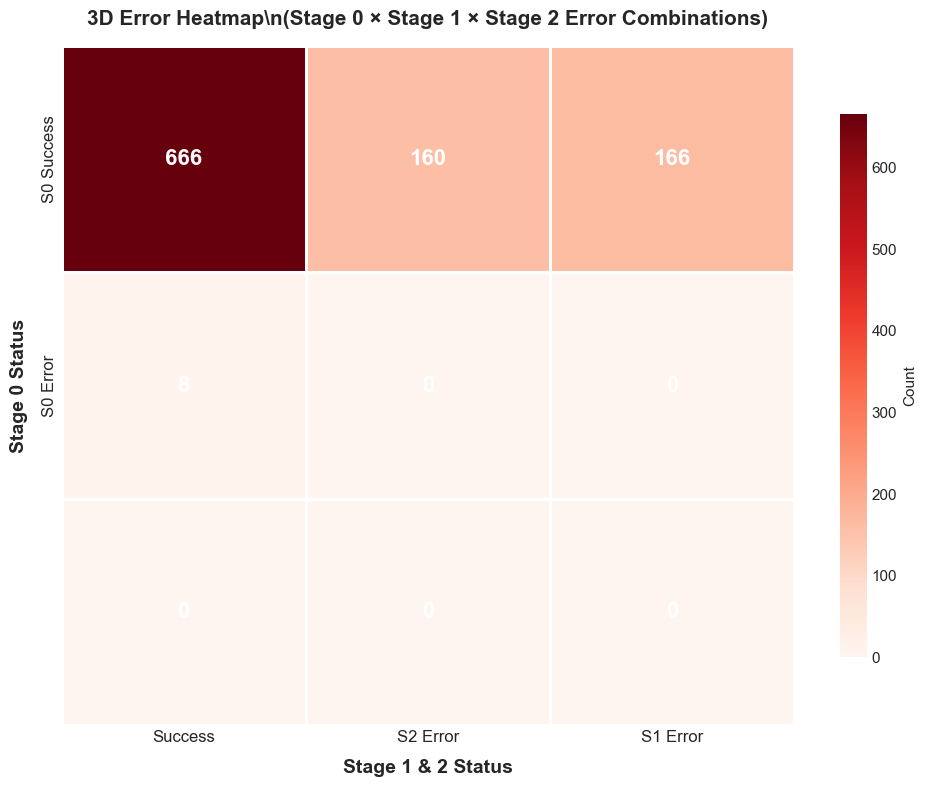

   ✅ 3D error heatmap kaydedildi

2️⃣ Error Timeline oluşturuluyor...


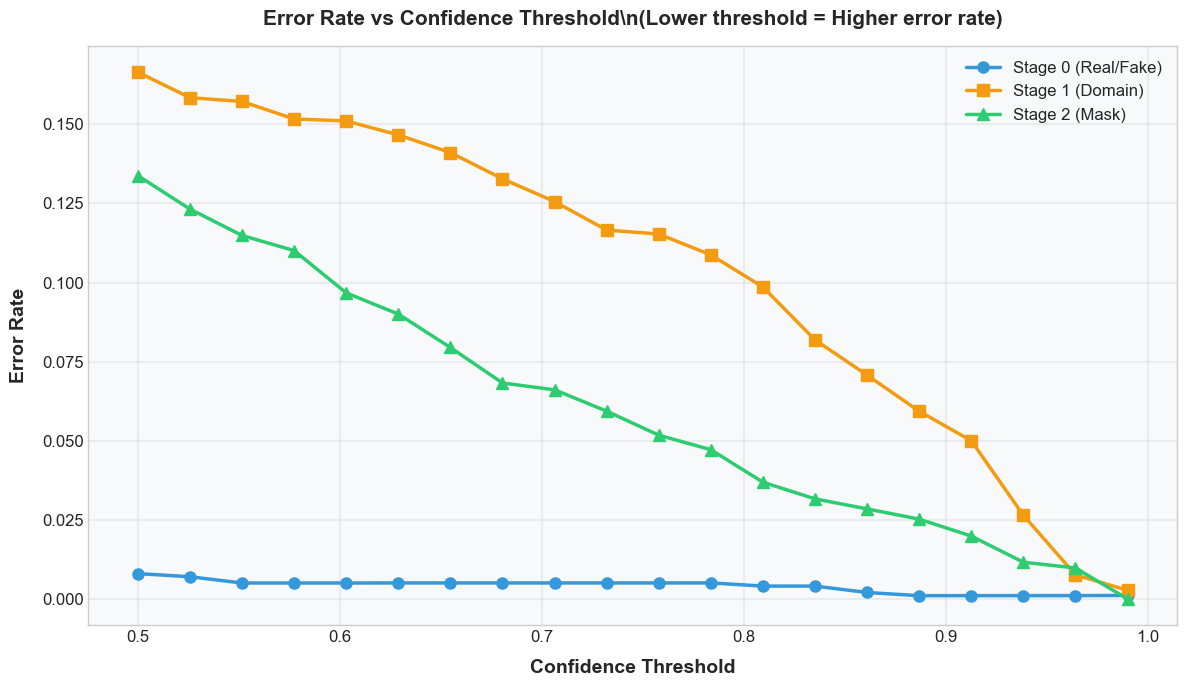

   ✅ Error timeline kaydedildi

3️⃣ Error Breakdown Pie Chart oluşturuluyor...


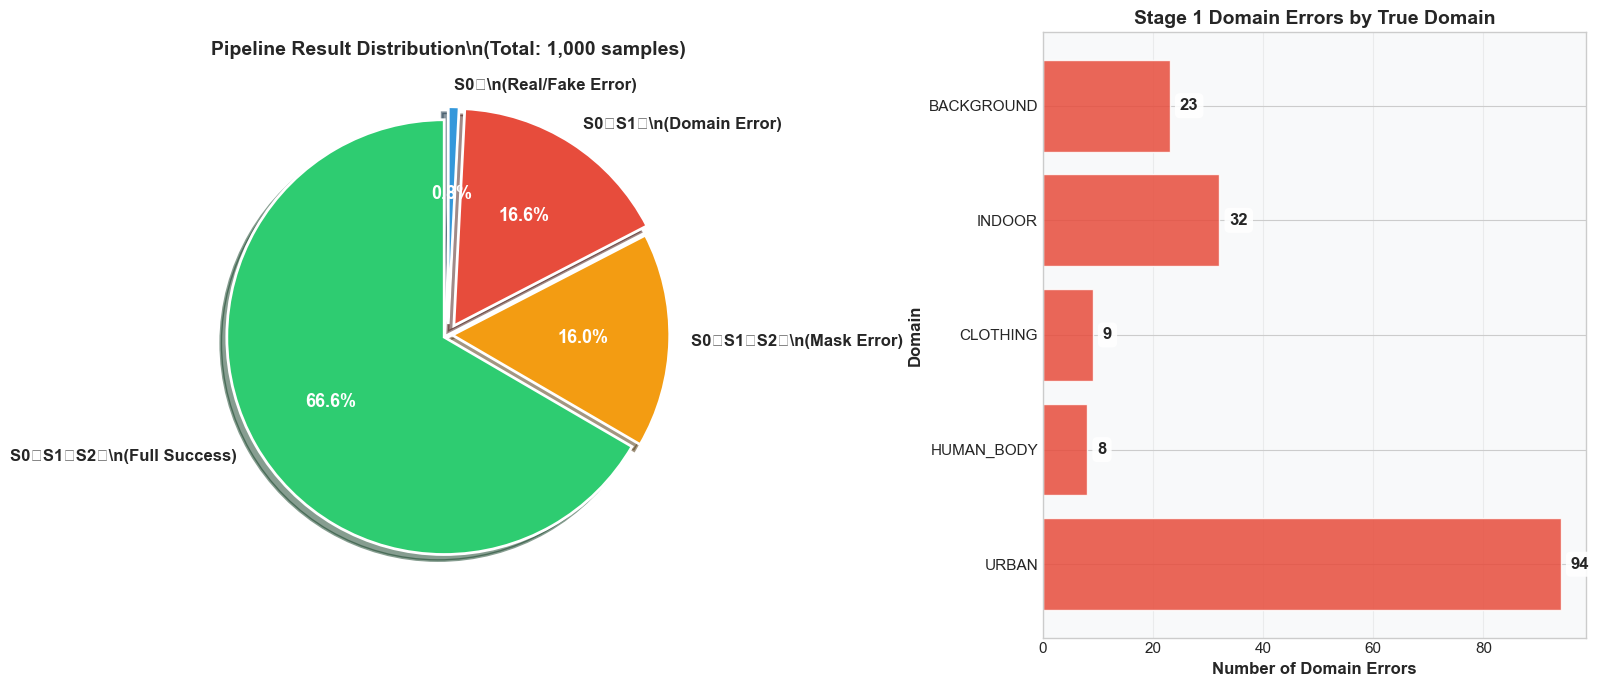

   ✅ Error breakdown kaydedildi

✅ Gelişmiş hata analizi tamamlandı!


In [45]:
"""
🔍 GELİŞMİŞ HATA ANALİZİ
3D Error Heatmap, Error Timeline, Hata kategorileri
"""

print("\n" + "="*70)
print("🔍 GELİŞMİŞ HATA ANALİZİ")
print("="*70)

# Hata kategorileri
df_stage0_correct = df_results[df_results['stage0_correct'] == True]
df_stage0_wrong = df_results[df_results['stage0_correct'] == False]

df_fake = df_results[df_results['pred_rf_name'] == 'fake'].copy()
if len(df_fake) > 0:
    df_stage1_correct = df_fake[df_fake['domain_correct'] == True]
    df_stage1_wrong = df_fake[df_fake['domain_correct'] == False]
    
    df_stage1_correct_s2_correct = df_stage1_correct[df_stage1_correct['mask_correct'] == True]
    df_stage1_correct_s2_wrong = df_stage1_correct[df_stage1_correct['mask_correct'] == False]
else:
    df_stage1_correct = pd.DataFrame()
    df_stage1_wrong = pd.DataFrame()
    df_stage1_correct_s2_correct = pd.DataFrame()
    df_stage1_correct_s2_wrong = pd.DataFrame()

# =============================================
# 1. 3D Error Heatmap (Stage 0 × Stage 1 × Stage 2)
# =============================================

print("\n1️⃣ 3D Error Heatmap oluşturuluyor...")

# Hata kombinasyonları
error_combinations = {
    'S0✓ S1✓ S2✓': len(df_stage1_correct_s2_correct),
    'S0✓ S1✓ S2✗': len(df_stage1_correct_s2_wrong),
    'S0✓ S1✗': len(df_stage1_wrong),
    'S0✗': len(df_stage0_wrong)
}

# 2D heatmap (3D yerine 2D matrix)
error_matrix = np.zeros((3, 3))  # Stage 0, Stage 1, Stage 2

# Matrix doldur
error_matrix[0, 0] = len(df_stage1_correct_s2_correct)  # S0✓ S1✓ S2✓
error_matrix[0, 1] = len(df_stage1_correct_s2_wrong)    # S0✓ S1✓ S2✗
error_matrix[0, 2] = len(df_stage1_wrong)                # S0✓ S1✗
error_matrix[1, 0] = len(df_stage0_wrong)                # S0✗
error_matrix[1, 1] = 0
error_matrix[1, 2] = 0
error_matrix[2, 0] = 0
error_matrix[2, 1] = 0
error_matrix[2, 2] = 0

fig, ax = plt.subplots(figsize=(10, 8))

labels = ['S0✓S1✓S2✓', 'S0✓S1✓S2✗', 'S0✓S1✗', 'S0✗', '', '', '', '', '']
labels_2d = np.array(labels).reshape(3, 3)

sns.heatmap(error_matrix, annot=True, fmt='.0f', cmap='Reds',
           xticklabels=['Success', 'S2 Error', 'S1 Error'],
           yticklabels=['S0 Success', 'S0 Error', ''],
           ax=ax, cbar_kws={'label': 'Count', 'shrink': 0.8},
           annot_kws={'size': 16, 'weight': 'bold', 'color': 'white'},
           linewidths=2, linecolor='white')

ax.set_xlabel('Stage 1 & 2 Status', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Stage 0 Status', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('3D Error Heatmap\\n(Stage 0 × Stage 1 × Stage 2 Error Combinations)', 
            fontsize=15, fontweight='bold', pad=15)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'error_3d_heatmap.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ 3D error heatmap kaydedildi")

# =============================================
# 2. Error Timeline (Confidence threshold'a göre)
# =============================================

print("\n2️⃣ Error Timeline oluşturuluyor...")

# Confidence threshold'ları
conf_thresholds = np.linspace(0.5, 0.99, 20)
stage0_error_rates = []
stage1_error_rates = []
stage2_error_rates = []

for threshold in conf_thresholds:
    # Stage 0
    df_above = df_results[df_results['rf_confidence'] >= threshold]
    if len(df_above) > 0:
        s0_err = 1 - df_above['stage0_correct'].mean()
    else:
        s0_err = 0
    stage0_error_rates.append(s0_err)
    
    # Stage 1
    df_fake_above = df_fake[df_fake['domain_confidence'] >= threshold] if len(df_fake) > 0 else pd.DataFrame()
    if len(df_fake_above) > 0:
        s1_err = 1 - df_fake_above['domain_correct'].mean()
    else:
        s1_err = 0
    stage1_error_rates.append(s1_err)
    
    # Stage 2
    df_s1_correct_above = df_stage1_correct[df_stage1_correct['mask_confidence'] >= threshold] if len(df_stage1_correct) > 0 else pd.DataFrame()
    if len(df_s1_correct_above) > 0:
        s2_err = 1 - df_s1_correct_above['mask_correct'].mean()
    else:
        s2_err = 0
    stage2_error_rates.append(s2_err)

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(conf_thresholds, stage0_error_rates, marker='o', linewidth=2.5, 
       label='Stage 0 (Real/Fake)', color=COLORS['real'], markersize=8)
if len(df_fake) > 0:
    ax.plot(conf_thresholds, stage1_error_rates, marker='s', linewidth=2.5, 
           label='Stage 1 (Domain)', color=COLORS['fake'], markersize=8)
if len(df_stage1_correct) > 0:
    ax.plot(conf_thresholds, stage2_error_rates, marker='^', linewidth=2.5, 
           label='Stage 2 (Mask)', color=COLORS['correct'], markersize=8)

ax.set_xlabel('Confidence Threshold', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Error Rate', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('Error Rate vs Confidence Threshold\\n(Lower threshold = Higher error rate)', 
            fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1.5)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'error_timeline.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Error timeline kaydedildi")

# =============================================
# 3. Error Breakdown Pie Chart
# =============================================

print("\n3️⃣ Error Breakdown Pie Chart oluşturuluyor...")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Sol: Genel breakdown
ax = axes[0]
labels = ['S0✓S1✓S2✓\\n(Full Success)', 'S0✓S1✓S2✗\\n(Mask Error)', 
         'S0✓S1✗\\n(Domain Error)', 'S0✗\\n(Real/Fake Error)']
sizes = [len(df_stage1_correct_s2_correct), len(df_stage1_correct_s2_wrong), 
        len(df_stage1_wrong), len(df_stage0_wrong)]
colors_pie = [COLORS['correct'], COLORS['fake'], COLORS['wrong'], COLORS['real']]
explode = (0.02, 0.02, 0.05, 0.05)

wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
                                 autopct='%1.1f%%', shadow=True, startangle=90,
                                 textprops={'fontsize': 12, 'fontweight': 'bold'},
                                 wedgeprops={'edgecolor': 'white', 'linewidth': 2})
# Autopct text'lerini iyileştir
for autotext in autotexts:
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')
    autotext.set_color('white')
ax.set_title(f'Pipeline Result Distribution\\n(Total: {n_total:,} samples)', 
            fontsize=14, fontweight='bold')

# Sağ: Domain bazında error breakdown
ax = axes[1]
domain_errors = []
for domain in DOMAIN_NAMES:
    df_dom = df_fake[df_fake['true_domain_name'] == domain] if len(df_fake) > 0 else pd.DataFrame()
    domain_errors.append(len(df_dom[df_dom['domain_correct'] == False]) if len(df_dom) > 0 else 0)

bars = ax.barh(DOMAIN_NAMES, domain_errors, color=COLORS['wrong'], 
              edgecolor='white', alpha=0.85)
ax.set_xlabel('Number of Domain Errors', fontsize=12, fontweight='bold')
ax.set_ylabel('Domain', fontsize=12, fontweight='bold')
ax.set_title('Stage 1 Domain Errors by True Domain', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for bar, err in zip(bars, domain_errors):
    width = bar.get_width()
    if width > 0:
        ax.text(width + max(domain_errors)*0.02, bar.get_y() + bar.get_height()/2.,
               f'{err:,}', ha='left', va='center', 
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='none'))

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'error_breakdown.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Error breakdown kaydedildi")

print(f"\n✅ Gelişmiş hata analizi tamamlandı!")


## 1️⃣1️⃣ Performans Metrikleri

ROC Curves, Precision-Recall Curves, F1-Score by Domain (tüm stage'ler için)



📊 PERFORMANS METRİKLERİ

1️⃣ Stage 0 ROC Curve oluşturuluyor...


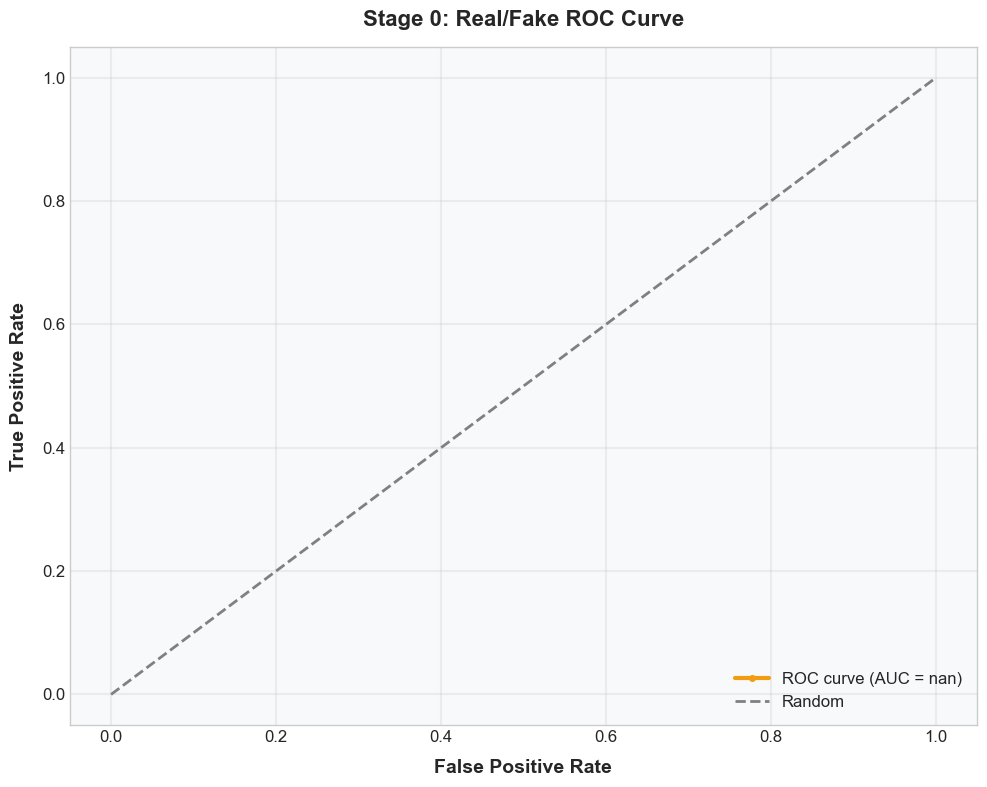

   ✅ Stage 0 ROC curve kaydedildi (AUC: nan)

2️⃣ Stage 1 ROC Curves oluşturuluyor...


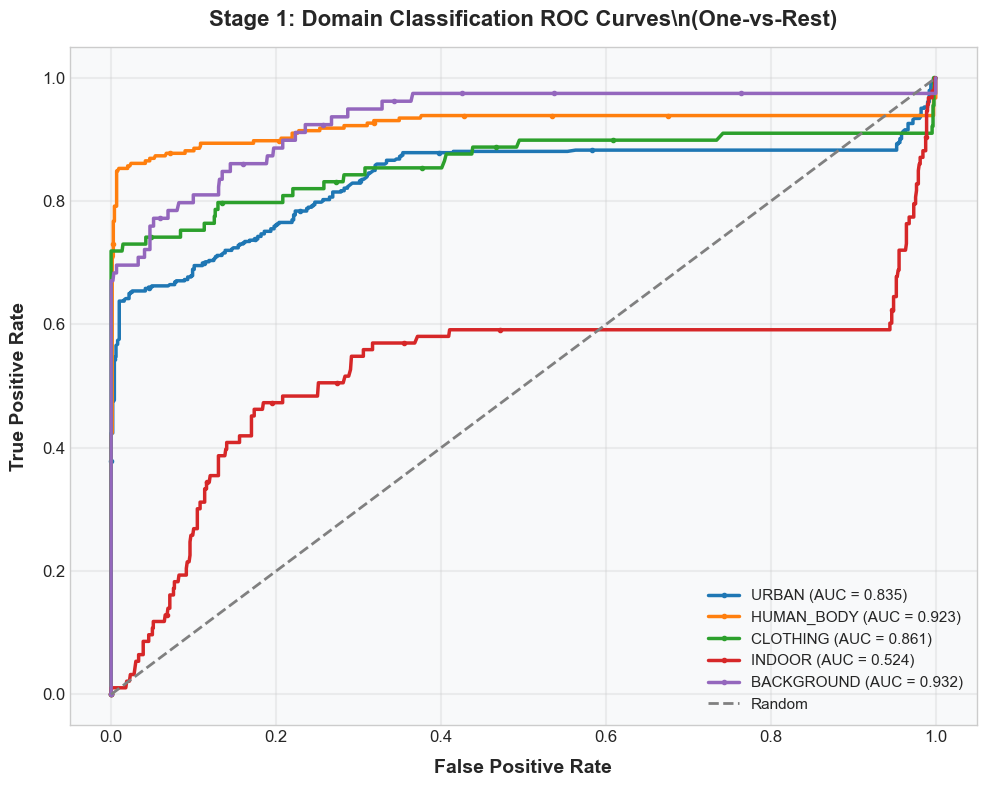

   ✅ Stage 1 ROC curves kaydedildi

3️⃣ Stage 2 ROC Curves oluşturuluyor...


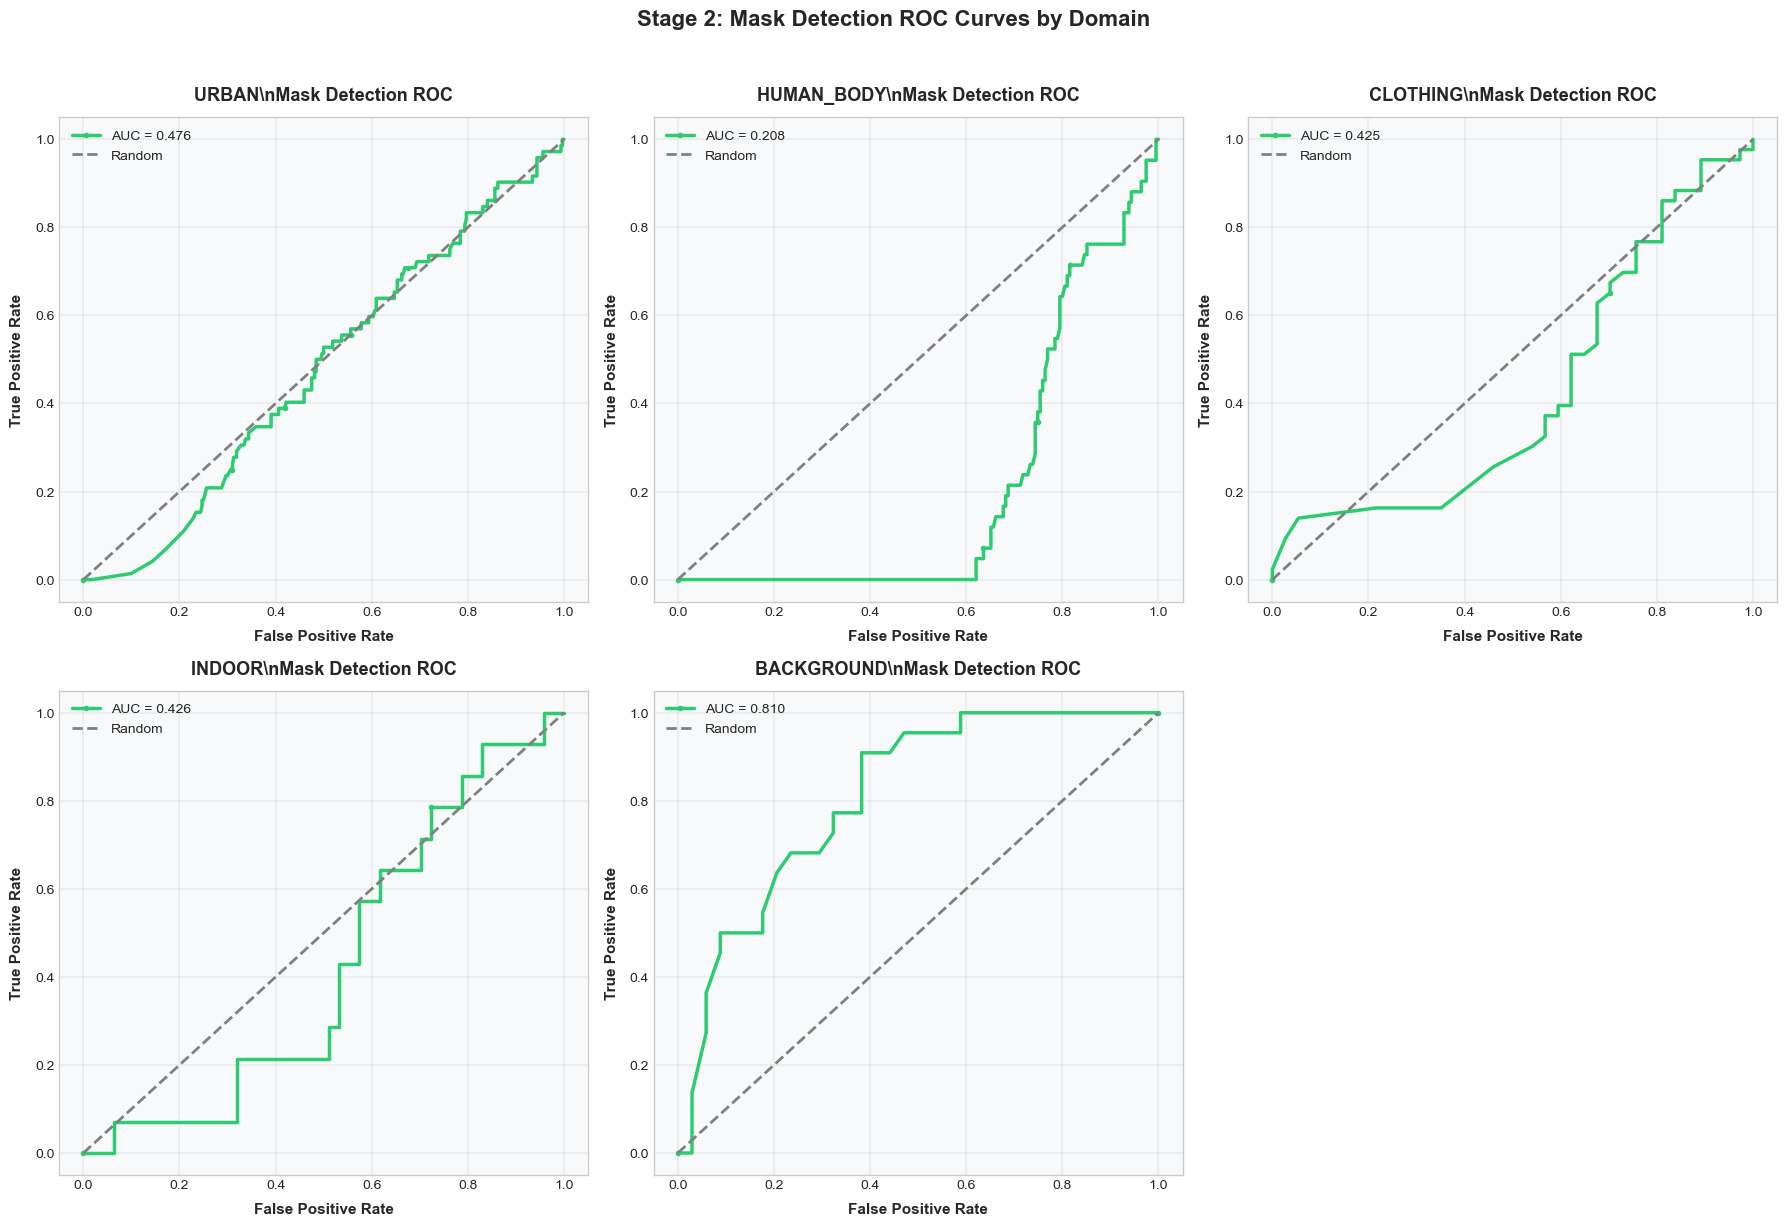

   ✅ Stage 2 ROC curves kaydedildi

4️⃣ Precision-Recall Curves oluşturuluyor...


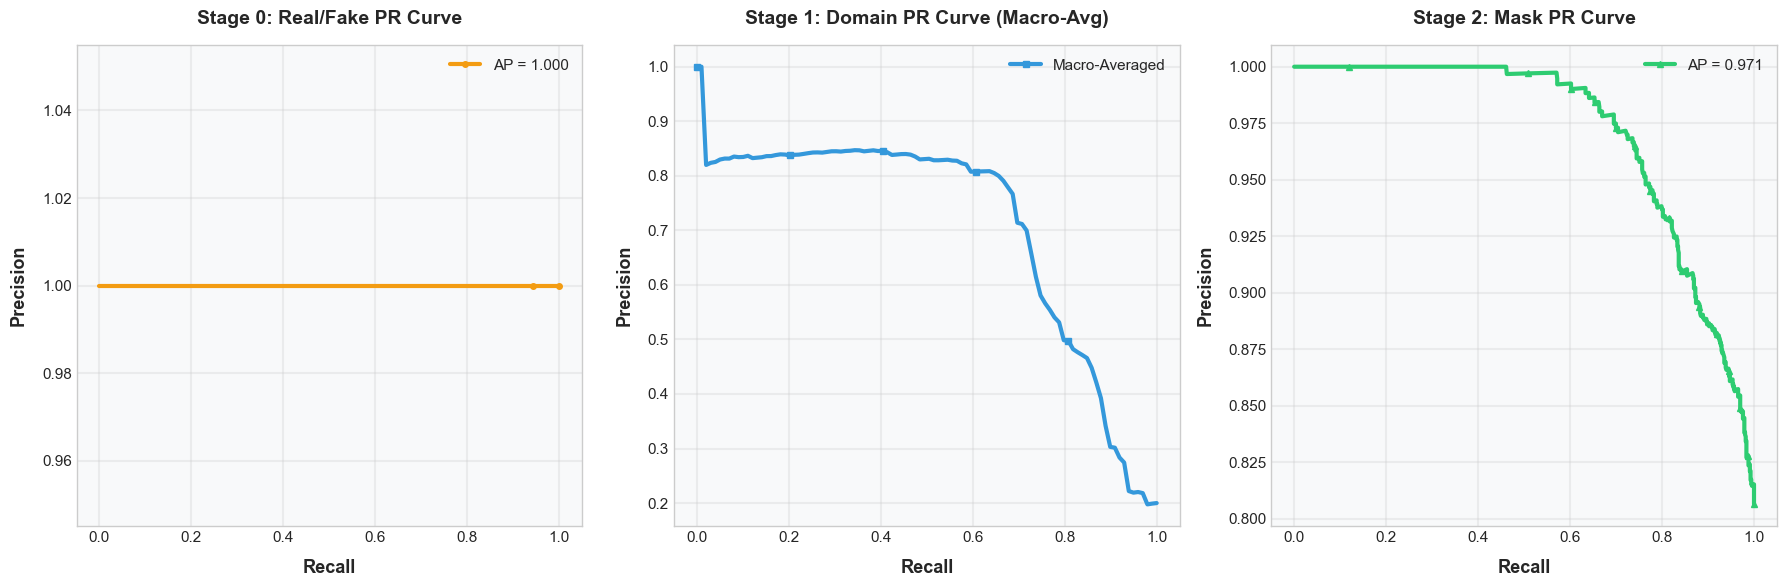

   ✅ Precision-Recall curves kaydedildi

5️⃣ F1-Score by Domain oluşturuluyor...


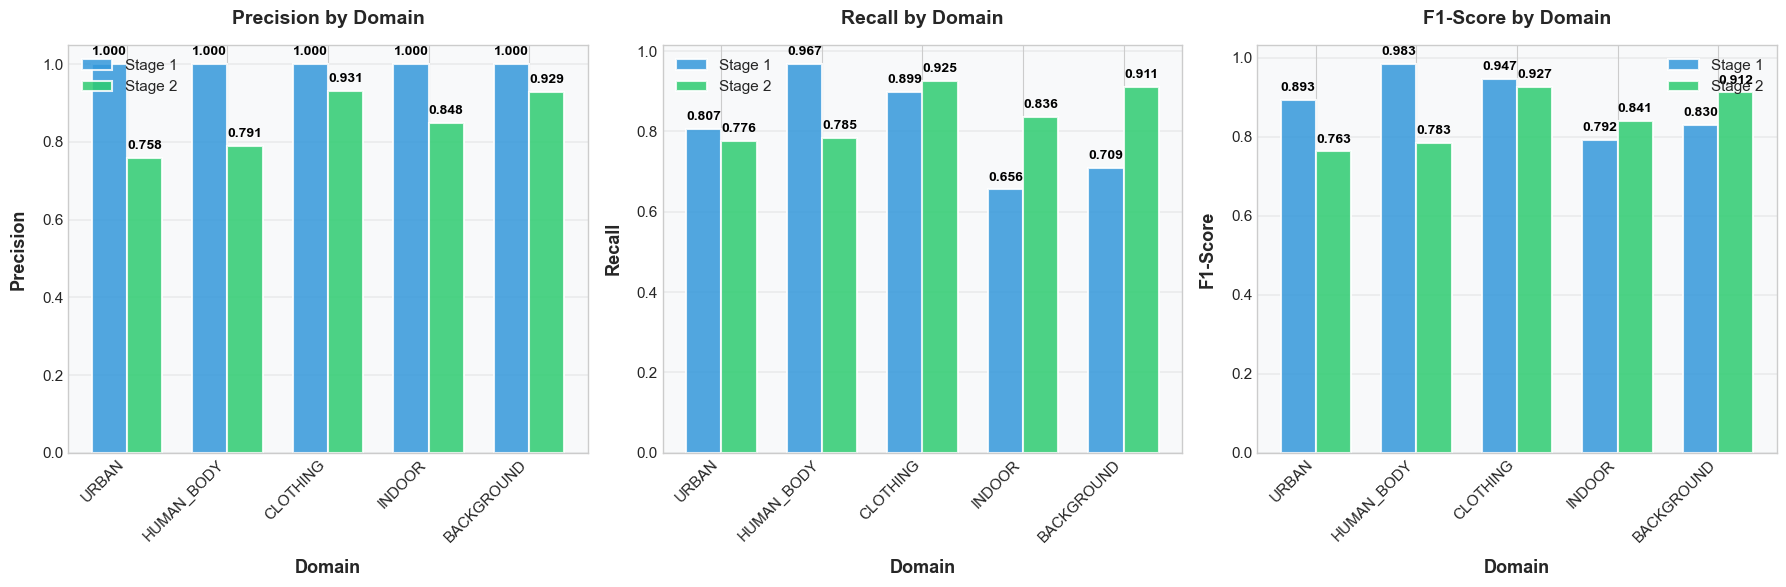

   ✅ F1-Score by domain kaydedildi

✅ Performans metrikleri tamamlandı!


In [46]:
"""
📊 PERFORMANS METRİKLERİ
ROC Curves, Precision-Recall Curves, F1-Score by Domain
"""

print("\n" + "="*70)
print("📊 PERFORMANS METRİKLERİ")
print("="*70)

# =============================================
# 1. Stage 0 ROC Curve (Binary: Real vs Fake)
# =============================================

print("\n1️⃣ Stage 0 ROC Curve oluşturuluyor...")

# Real/Fake için probability'leri al (fake class probability)
rf_probs_all = []
rf_labels_all = []

# Tüm batch'lerden probability'leri topla (şimdilik basit yaklaşım)
# Gerçek uygulamada test sırasında probability'leri kaydetmek gerekir
# Şimdilik confidence'ı probability olarak kullanıyoruz
rf_probs_all = df_results['rf_confidence'].values
rf_labels_all = df_results['true_rf_label'].values

# Fake class için probability (eğer pred fake ise confidence, değilse 1-confidence)
rf_probs_fake = np.where(df_results['pred_rf_label'] == 1, 
                        df_results['rf_confidence'].values,
                        1 - df_results['rf_confidence'].values)

fpr, tpr, thresholds = roc_curve(rf_labels_all, rf_probs_fake, pos_label=1)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color=COLORS['fake'], lw=3, 
       label=f'ROC curve (AUC = {roc_auc:.3f})', marker='o', markersize=4, markevery=50)
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('Stage 0: Real/Fake ROC Curve', fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=12, loc='lower right', framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1.5)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'stage0_roc_curve.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Stage 0 ROC curve kaydedildi (AUC: {roc_auc:.3f})")

# =============================================
# 2. Stage 1 ROC Curves (Multi-class: One-vs-Rest)
# =============================================

print("\n2️⃣ Stage 1 ROC Curves oluşturuluyor...")

if len(df_fake) > 0:
    # Domain probability'leri (şimdilik confidence kullanıyoruz)
    # Gerçek uygulamada tüm probability'leri kaydetmek gerekir
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Her domain için one-vs-rest ROC
    domain_aucs = {}
    for domain_idx, domain_name in enumerate(DOMAIN_NAMES):
        # Binary labels: bu domain mi değil mi?
        y_true_binary = (df_fake['true_domain_label'] == domain_idx).astype(int).values
        # Probability: bu domain'in confidence'ı (basitleştirilmiş)
        y_score = np.where(df_fake['final_pred_domain_label'] == domain_idx,
                          df_fake['domain_confidence'].values,
                          1 - df_fake['domain_confidence'].values / NUM_DOMAINS)
        
        if len(np.unique(y_true_binary)) > 1:  # En az bir positive ve negative var
            fpr, tpr, _ = roc_curve(y_true_binary, y_score)
            auc_score = auc(fpr, tpr)
            domain_aucs[domain_name] = auc_score
            
            ax.plot(fpr, tpr, lw=2.5, label=f'{domain_name} (AUC = {auc_score:.3f})', marker='o', markersize=3, markevery=30)
    
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_title('Stage 1: Domain Classification ROC Curves\\n(One-vs-Rest)', 
                fontsize=16, fontweight='bold', pad=15)
    ax.legend(fontsize=11, loc='lower right', framealpha=0.9)
    ax.grid(True, alpha=0.3, linewidth=1.5)
    ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'stage1_roc_curves.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Stage 1 ROC curves kaydedildi")
else:
    print(f"   ⚠️  Fake görüntü yok, Stage 1 ROC atlandı")

# =============================================
# 3. Stage 2 ROC Curves (Domain-specific)
# =============================================

print("\n3️⃣ Stage 2 ROC Curves oluşturuluyor...")

if len(df_stage1_correct) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, domain in enumerate(DOMAIN_NAMES):
        ax = axes[idx]
        
        df_dom = df_stage1_correct[df_stage1_correct['true_domain_name'] == domain]
        if len(df_dom) == 0:
            ax.text(0.5, 0.5, f'{domain}\\nNo data', ha='center', va='center', fontsize=12)
            ax.set_title(f'{domain}')
            continue
        
        # Her mask için one-vs-rest ROC (basitleştirilmiş)
        # Gerçek uygulamada tüm mask probability'lerini kaydetmek gerekir
        true_masks = df_dom['true_mask_label'].values
        mask_confs = df_dom['mask_confidence'].values
        
        # En yaygın mask için binary ROC
        if len(np.unique(true_masks)) > 1:
            most_common_mask = int(np.bincount(true_masks.astype(int)).argmax())
            y_true_binary = (true_masks == most_common_mask).astype(int)
            y_score = mask_confs
            
            if len(np.unique(y_true_binary)) > 1:
                fpr, tpr, _ = roc_curve(y_true_binary, y_score)
                auc_score = auc(fpr, tpr)
                
                ax.plot(fpr, tpr, lw=2.5, color=COLORS['correct'], 
                       label=f'AUC = {auc_score:.3f}', marker='o', markersize=3, markevery=20)
                ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
                ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold', labelpad=8)
                ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold', labelpad=8)
                ax.set_title(f'{domain}\\nMask Detection ROC', fontsize=13, fontweight='bold', pad=12)
                ax.legend(fontsize=10, framealpha=0.9)
                ax.grid(True, alpha=0.3, linewidth=1.2)
                ax.tick_params(labelsize=10)
            else:
                ax.text(0.5, 0.5, f'{domain}\\nInsufficient data', ha='center', va='center', fontsize=12)
        else:
            ax.text(0.5, 0.5, f'{domain}\\nSingle class', ha='center', va='center', fontsize=12)
    
    axes[5].axis('off')
    
    fig.suptitle('Stage 2: Mask Detection ROC Curves by Domain', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'stage2_roc_curves.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Stage 2 ROC curves kaydedildi")
else:
    print(f"   ⚠️  Domain correct örnek yok, Stage 2 ROC atlandı")

# =============================================
# 4. Precision-Recall Curves
# =============================================

print("\n4️⃣ Precision-Recall Curves oluşturuluyor...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Stage 0 PR Curve
rf_probs_fake = np.where(df_results['pred_rf_label'] == 1, 
                        df_results['rf_confidence'].values,
                        1 - df_results['rf_confidence'].values)
precision, recall, _ = precision_recall_curve(rf_labels_all, rf_probs_fake, pos_label=1)
ap = average_precision_score(rf_labels_all, rf_probs_fake, pos_label=1)

axes[0].plot(recall, precision, lw=3, color=COLORS['fake'], label=f'AP = {ap:.3f}', marker='o', markersize=4, markevery=50)
axes[0].set_xlabel('Recall', fontsize=13, fontweight='bold', labelpad=10)
axes[0].set_ylabel('Precision', fontsize=13, fontweight='bold', labelpad=10)
axes[0].set_title('Stage 0: Real/Fake PR Curve', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=11, framealpha=0.9)
axes[0].grid(True, alpha=0.3, linewidth=1.5)
axes[0].tick_params(labelsize=11)

# Stage 1 PR Curve (macro-averaged)
if len(df_fake) > 0:
    precisions = []
    recalls = []
    for domain_idx in range(NUM_DOMAINS):
        y_true_binary = (df_fake['true_domain_label'] == domain_idx).astype(int).values
        y_score = np.where(df_fake['final_pred_domain_label'] == domain_idx,
                          df_fake['domain_confidence'].values,
                          1 - df_fake['domain_confidence'].values / NUM_DOMAINS)
        
        if len(np.unique(y_true_binary)) > 1:
            prec, rec, _ = precision_recall_curve(y_true_binary, y_score)
            precisions.append(prec)
            recalls.append(rec)
    
    if precisions:
        # Interpolate to common recall values
        recall_common = np.linspace(0, 1, 100)
        precisions_interp = []
        for prec, rec in zip(precisions, recalls):
            prec_interp = np.interp(recall_common, rec[::-1], prec[::-1])
            precisions_interp.append(prec_interp)
        
        prec_mean = np.mean(precisions_interp, axis=0)
        axes[1].plot(recall_common, prec_mean, lw=3, color=COLORS['real'], label='Macro-Averaged', marker='s', markersize=4, markevery=20)
        axes[1].set_xlabel('Recall', fontsize=13, fontweight='bold', labelpad=10)
        axes[1].set_ylabel('Precision', fontsize=13, fontweight='bold', labelpad=10)
        axes[1].set_title('Stage 1: Domain PR Curve (Macro-Avg)', fontsize=14, fontweight='bold', pad=15)
        axes[1].legend(fontsize=11, framealpha=0.9)
        axes[1].grid(True, alpha=0.3, linewidth=1.5)
        axes[1].tick_params(labelsize=11)
    else:
        axes[1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=12)
        axes[1].set_title('Stage 1: Domain PR Curve', fontsize=13, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No fake images', ha='center', va='center', fontsize=12)
    axes[1].set_title('Stage 1: Domain PR Curve', fontsize=13, fontweight='bold')

# Stage 2 PR Curve (basitleştirilmiş)
if len(df_stage1_correct) > 0:
    mask_confs = df_stage1_correct['mask_confidence'].values
    mask_correct = df_stage1_correct['mask_correct'].astype(int).values
    
    if len(np.unique(mask_correct)) > 1:
        prec, rec, _ = precision_recall_curve(mask_correct, mask_confs)
        ap = average_precision_score(mask_correct, mask_confs)
        
        axes[2].plot(rec, prec, lw=3, color=COLORS['correct'], label=f'AP = {ap:.3f}', marker='^', markersize=4, markevery=30)
        axes[2].set_xlabel('Recall', fontsize=13, fontweight='bold', labelpad=10)
        axes[2].set_ylabel('Precision', fontsize=13, fontweight='bold', labelpad=10)
        axes[2].set_title('Stage 2: Mask PR Curve', fontsize=14, fontweight='bold', pad=15)
        axes[2].legend(fontsize=11, framealpha=0.9)
        axes[2].grid(True, alpha=0.3, linewidth=1.5)
        axes[2].tick_params(labelsize=11)
    else:
        axes[2].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=12)
        axes[2].set_title('Stage 2: Mask PR Curve', fontsize=13, fontweight='bold')
else:
    axes[2].text(0.5, 0.5, 'No domain-correct samples', ha='center', va='center', fontsize=12)
    axes[2].set_title('Stage 2: Mask PR Curve', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'precision_recall_curves.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Precision-Recall curves kaydedildi")

# =============================================
# 5. F1-Score by Domain
# =============================================

print("\n5️⃣ F1-Score by Domain oluşturuluyor...")

if len(df_fake) > 0:
    domain_metrics = []
    
    for domain in DOMAIN_NAMES:
        df_dom = df_fake[df_fake['true_domain_name'] == domain]
        if len(df_dom) == 0:
            continue
        
        # Stage 1 metrics
        y_true_s1 = df_dom['true_domain_label'].values
        y_pred_s1 = df_dom['final_pred_domain_label'].values
        s1_precision = precision_score(y_true_s1, y_pred_s1, average='weighted', zero_division=0)
        s1_recall = recall_score(y_true_s1, y_pred_s1, average='weighted', zero_division=0)
        s1_f1 = f1_score(y_true_s1, y_pred_s1, average='weighted', zero_division=0)
        
        # Stage 2 metrics
        df_dom_correct = df_dom[df_dom['domain_correct'] == True]
        if len(df_dom_correct) > 0:
            y_true_s2 = df_dom_correct['true_mask_label'].values
            y_pred_s2 = df_dom_correct['pred_mask_label'].values
            s2_precision = precision_score(y_true_s2, y_pred_s2, average='weighted', zero_division=0)
            s2_recall = recall_score(y_true_s2, y_pred_s2, average='weighted', zero_division=0)
            s2_f1 = f1_score(y_true_s2, y_pred_s2, average='weighted', zero_division=0)
        else:
            s2_precision = s2_recall = s2_f1 = 0.0
        
        domain_metrics.append({
            'domain': domain,
            'stage1_precision': s1_precision,
            'stage1_recall': s1_recall,
            'stage1_f1': s1_f1,
            'stage2_precision': s2_precision,
            'stage2_recall': s2_recall,
            'stage2_f1': s2_f1
        })
    
    if domain_metrics:
        df_metrics = pd.DataFrame(domain_metrics)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        x = np.arange(len(df_metrics))
        width = 0.35
        
        # Precision - İyileştirilmiş bar labels
        bars1_p = axes[0].bar(x - width/2, df_metrics['stage1_precision'], width, 
                   label='Stage 1', color=COLORS['real'], alpha=0.85, edgecolor='white', linewidth=1.5)
        bars2_p = axes[0].bar(x + width/2, df_metrics['stage2_precision'], width, 
                   label='Stage 2', color=COLORS['correct'], alpha=0.85, edgecolor='white', linewidth=1.5)
        max_val_p = max(df_metrics['stage1_precision'].max(), df_metrics['stage2_precision'].max())
        for bars, values in [(bars1_p, df_metrics['stage1_precision']), (bars2_p, df_metrics['stage2_precision'])]:
            for bar, val in zip(bars, values):
                height = bar.get_height()
                if height > max_val_p * 0.05:
                    text_y = height + max_val_p * 0.015
                    text_color = 'black'
                    bbox_props = None
                else:
                    text_y = height / 2
                    text_color = 'white'
                    bbox_props = dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7, edgecolor='none')
                axes[0].text(bar.get_x() + bar.get_width()/2., text_y,
                           f'{val:.3f}', ha='center', va='bottom' if height > max_val_p * 0.05 else 'center',
                           fontsize=10, fontweight='bold', color=text_color, bbox=bbox_props)
        axes[0].set_xlabel('Domain', fontsize=13, fontweight='bold', labelpad=10)
        axes[0].set_ylabel('Precision', fontsize=13, fontweight='bold', labelpad=10)
        axes[0].set_title('Precision by Domain', fontsize=14, fontweight='bold', pad=15)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(df_metrics['domain'], rotation=45, ha='right', fontsize=11)
        axes[0].legend(fontsize=11, framealpha=0.9)
        axes[0].grid(True, alpha=0.3, axis='y', linewidth=1.2)
        axes[0].tick_params(labelsize=11)
        
        # Recall - İyileştirilmiş bar labels
        bars1_r = axes[1].bar(x - width/2, df_metrics['stage1_recall'], width, 
                   label='Stage 1', color=COLORS['real'], alpha=0.85, edgecolor='white', linewidth=1.5)
        bars2_r = axes[1].bar(x + width/2, df_metrics['stage2_recall'], width, 
                   label='Stage 2', color=COLORS['correct'], alpha=0.85, edgecolor='white', linewidth=1.5)
        max_val_r = max(df_metrics['stage1_recall'].max(), df_metrics['stage2_recall'].max())
        for bars, values in [(bars1_r, df_metrics['stage1_recall']), (bars2_r, df_metrics['stage2_recall'])]:
            for bar, val in zip(bars, values):
                height = bar.get_height()
                if height > max_val_r * 0.05:
                    text_y = height + max_val_r * 0.015
                    text_color = 'black'
                    bbox_props = None
                else:
                    text_y = height / 2
                    text_color = 'white'
                    bbox_props = dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7, edgecolor='none')
                axes[1].text(bar.get_x() + bar.get_width()/2., text_y,
                           f'{val:.3f}', ha='center', va='bottom' if height > max_val_r * 0.05 else 'center',
                           fontsize=10, fontweight='bold', color=text_color, bbox=bbox_props)
        axes[1].set_xlabel('Domain', fontsize=13, fontweight='bold', labelpad=10)
        axes[1].set_ylabel('Recall', fontsize=13, fontweight='bold', labelpad=10)
        axes[1].set_title('Recall by Domain', fontsize=14, fontweight='bold', pad=15)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(df_metrics['domain'], rotation=45, ha='right', fontsize=11)
        axes[1].legend(fontsize=11, framealpha=0.9)
        axes[1].grid(True, alpha=0.3, axis='y', linewidth=1.2)
        axes[1].tick_params(labelsize=11)
        
        # F1-Score - İyileştirilmiş bar labels
        bars1_f = axes[2].bar(x - width/2, df_metrics['stage1_f1'], width, 
                   label='Stage 1', color=COLORS['real'], alpha=0.85, edgecolor='white', linewidth=1.5)
        bars2_f = axes[2].bar(x + width/2, df_metrics['stage2_f1'], width, 
                   label='Stage 2', color=COLORS['correct'], alpha=0.85, edgecolor='white', linewidth=1.5)
        max_val_f = max(df_metrics['stage1_f1'].max(), df_metrics['stage2_f1'].max())
        for bars, values in [(bars1_f, df_metrics['stage1_f1']), (bars2_f, df_metrics['stage2_f1'])]:
            for bar, val in zip(bars, values):
                height = bar.get_height()
                if height > max_val_f * 0.05:
                    text_y = height + max_val_f * 0.015
                    text_color = 'black'
                    bbox_props = None
                else:
                    text_y = height / 2
                    text_color = 'white'
                    bbox_props = dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7, edgecolor='none')
                axes[2].text(bar.get_x() + bar.get_width()/2., text_y,
                           f'{val:.3f}', ha='center', va='bottom' if height > max_val_f * 0.05 else 'center',
                           fontsize=10, fontweight='bold', color=text_color, bbox=bbox_props)
        axes[2].set_xlabel('Domain', fontsize=13, fontweight='bold', labelpad=10)
        axes[2].set_ylabel('F1-Score', fontsize=13, fontweight='bold', labelpad=10)
        axes[2].set_title('F1-Score by Domain', fontsize=14, fontweight='bold', pad=15)
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(df_metrics['domain'], rotation=45, ha='right', fontsize=11)
        axes[2].legend(fontsize=11, framealpha=0.9)
        axes[2].grid(True, alpha=0.3, axis='y', linewidth=1.2)
        axes[2].tick_params(labelsize=11)
        
        plt.tight_layout()
        plt.savefig(os.path.join(VIZ_FOLDER, 'f1_score_by_domain.png'), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        print(f"   ✅ F1-Score by domain kaydedildi")
    else:
        print(f"   ⚠️  Domain metrikleri hesaplanamadı")
else:
    print(f"   ⚠️  Fake görüntü yok, F1-Score atlandı")

print(f"\n✅ Performans metrikleri tamamlandı!")


In [47]:
"""
💾 THRESHOLD POOL EXPORT
Tüm threshold'lar için sonuçları CSV ve JSON formatında export etme
"""

print("\n" + "="*70)
print("💾 THRESHOLD POOL EXPORT")
print("="*70)

# =============================================
# 1. Tüm Threshold'lar için Birleşik CSV
# =============================================

print("\n1️⃣ Tüm threshold'lar için birleşik CSV kaydediliyor...")

# Tüm threshold'ların sonuçlarını birleştir
all_combined_results = []
for threshold in ROUTING_THRESHOLDS:
    if threshold in all_threshold_dfs:
        all_combined_results.append(all_threshold_dfs[threshold])

if all_combined_results:
    df_all_thresholds = pd.concat(all_combined_results, ignore_index=True)
    csv_filename = f'threshold_pool_all_results_{TIMESTAMP}.csv'
    csv_path = os.path.join(OUTPUT_FOLDER, csv_filename)
    df_all_thresholds.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"   ✅ Birleşik sonuçlar kaydedildi: {csv_path}")
    print(f"      Toplam {len(df_all_thresholds):,} satır, {len(df_all_thresholds.columns)} sütun")
else:
    print("   ⚠️  Threshold sonuçları bulunamadı")

# =============================================
# 2. Threshold Metrikleri CSV
# =============================================

print("\n2️⃣ Threshold metrikleri CSV'ye kaydediliyor...")

if len(df_threshold_metrics) > 0:
    metrics_csv_filename = f'threshold_pool_metrics_{TIMESTAMP}.csv'
    metrics_csv_path = os.path.join(OUTPUT_FOLDER, metrics_csv_filename)
    df_threshold_metrics.to_csv(metrics_csv_path, index=False, encoding='utf-8-sig')
    print(f"   ✅ Threshold metrikleri kaydedildi: {metrics_csv_path}")
    print(f"      Toplam {len(df_threshold_metrics)} threshold")
else:
    print("   ⚠️  Threshold metrikleri bulunamadı")

# =============================================
# 3. Threshold Pool Özet JSON
# =============================================

print("\n3️⃣ Threshold pool özet JSON'a kaydediliyor...")

threshold_pool_summary = {
    'test_info': {
        'total_samples': int(len(df_all_thresholds) / len(ROUTING_THRESHOLDS)) if all_combined_results else 0,
        'test_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'num_thresholds': len(ROUTING_THRESHOLDS),
        'thresholds_tested': ROUTING_THRESHOLDS,
        'batch_size': BATCH_SIZE,
        'use_multi_expert_routing': USE_MULTI_EXPERT_ROUTING
    },
    'best_thresholds': {}
}

if len(df_threshold_metrics) > 0:
    best_pipeline = df_threshold_metrics.loc[df_threshold_metrics['pipeline_accuracy'].idxmax()]
    best_stage1 = df_threshold_metrics.loc[df_threshold_metrics['stage1_accuracy'].idxmax()]
    best_stage2 = df_threshold_metrics.loc[df_threshold_metrics['stage2_accuracy'].idxmax()]
    
    threshold_pool_summary['best_thresholds'] = {
        'pipeline': {
            'threshold': float(best_pipeline['threshold']),
            'accuracy': float(best_pipeline['pipeline_accuracy'])
        },
        'stage1': {
            'threshold': float(best_stage1['threshold']),
            'accuracy': float(best_stage1['stage1_accuracy'])
        },
        'stage2': {
            'threshold': float(best_stage2['threshold']),
            'accuracy': float(best_stage2['stage2_accuracy'])
        }
    }
    
    # Her threshold için detaylı metrikler
    threshold_pool_summary['threshold_details'] = df_threshold_metrics.to_dict('records')

# JSON'a kaydet
json_filename = f'threshold_pool_summary_{TIMESTAMP}.json'
json_path = os.path.join(OUTPUT_FOLDER, json_filename)
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(threshold_pool_summary, f, indent=2, ensure_ascii=False)

print(f"   ✅ Threshold pool özeti kaydedildi: {json_path}")

# =============================================
# 4. Her Threshold için Ayrı CSV (opsiyonel)
# =============================================

print("\n4️⃣ Her threshold için ayrı CSV kaydediliyor...")

for threshold in ROUTING_THRESHOLDS:
    if threshold in all_threshold_dfs:
        threshold_str = f"{threshold:.2f}".replace('.', '_')
        threshold_csv_filename = f'threshold_{threshold_str}_results_{TIMESTAMP}.csv'
        threshold_csv_path = os.path.join(OUTPUT_FOLDER, threshold_csv_filename)
        all_threshold_dfs[threshold].to_csv(threshold_csv_path, index=False, encoding='utf-8-sig')
        print(f"   ✅ Threshold {threshold:.2f} sonuçları: {threshold_csv_filename}")

print(f"\n✅ Threshold pool export tamamlandı!")
print(f"   📁 Tüm çıktılar: {OUTPUT_FOLDER}")



💾 THRESHOLD POOL EXPORT

1️⃣ Tüm threshold'lar için birleşik CSV kaydediliyor...
   ✅ Birleşik sonuçlar kaydedildi: combined_pipeline_test_results\20251224_140610\threshold_pool_all_results_20251224_140610.csv
      Toplam 6,000 satır, 27 sütun

2️⃣ Threshold metrikleri CSV'ye kaydediliyor...
   ✅ Threshold metrikleri kaydedildi: combined_pipeline_test_results\20251224_140610\threshold_pool_metrics_20251224_140610.csv
      Toplam 6 threshold

3️⃣ Threshold pool özet JSON'a kaydediliyor...
   ✅ Threshold pool özeti kaydedildi: combined_pipeline_test_results\20251224_140610\threshold_pool_summary_20251224_140610.json

4️⃣ Her threshold için ayrı CSV kaydediliyor...
   ✅ Threshold 0.70 sonuçları: threshold_0_70_results_20251224_140610.csv
   ✅ Threshold 0.75 sonuçları: threshold_0_75_results_20251224_140610.csv
   ✅ Threshold 0.80 sonuçları: threshold_0_80_results_20251224_140610.csv
   ✅ Threshold 0.85 sonuçları: threshold_0_85_results_20251224_140610.csv
   ✅ Threshold 0.90 sonuçları:

## 1️⃣2️⃣ İleri Düzey Analizler

Confidence Calibration, Domain Transition Matrix, Mask Distribution, Real vs Fake Statistics



🔬 İLERİ DÜZEY ANALİZLER

1️⃣ Confidence Calibration Plot oluşturuluyor...


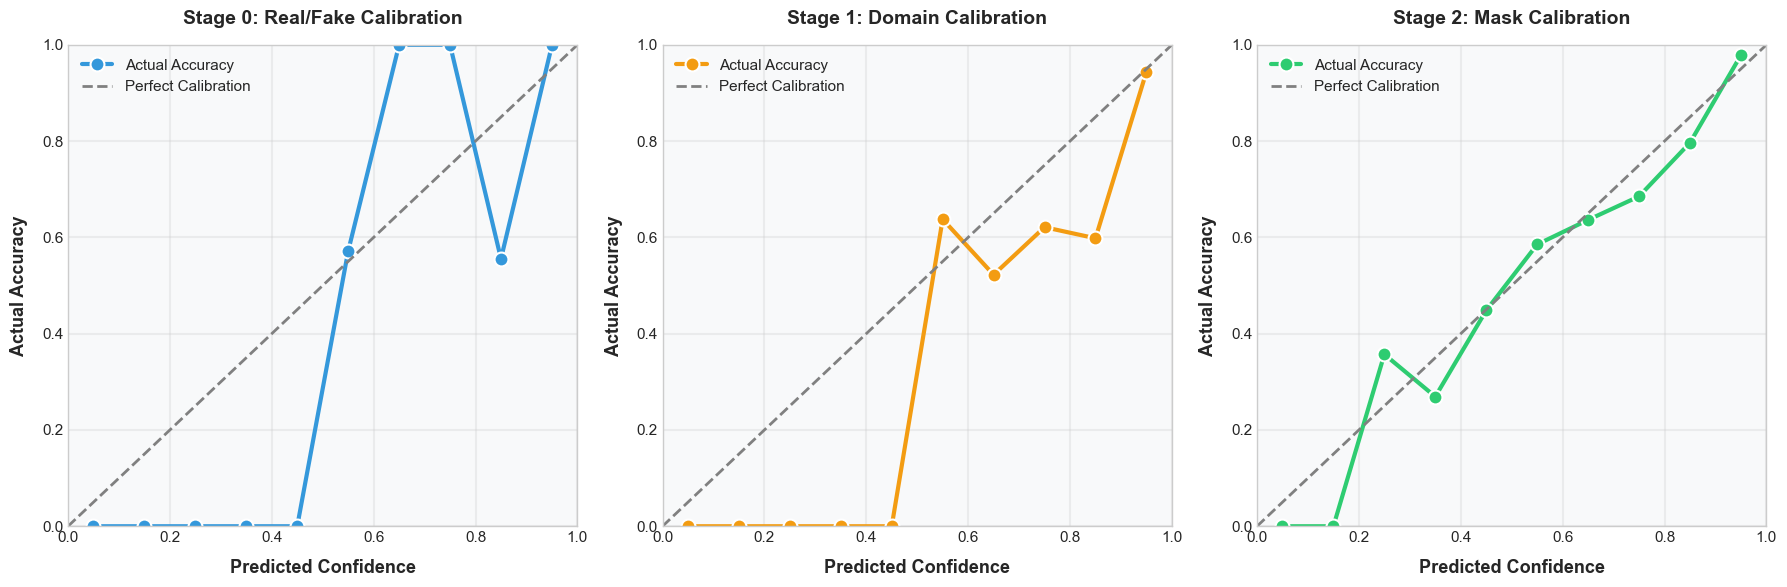

   ✅ Confidence calibration plot kaydedildi

2️⃣ Domain Transition Matrix oluşturuluyor...


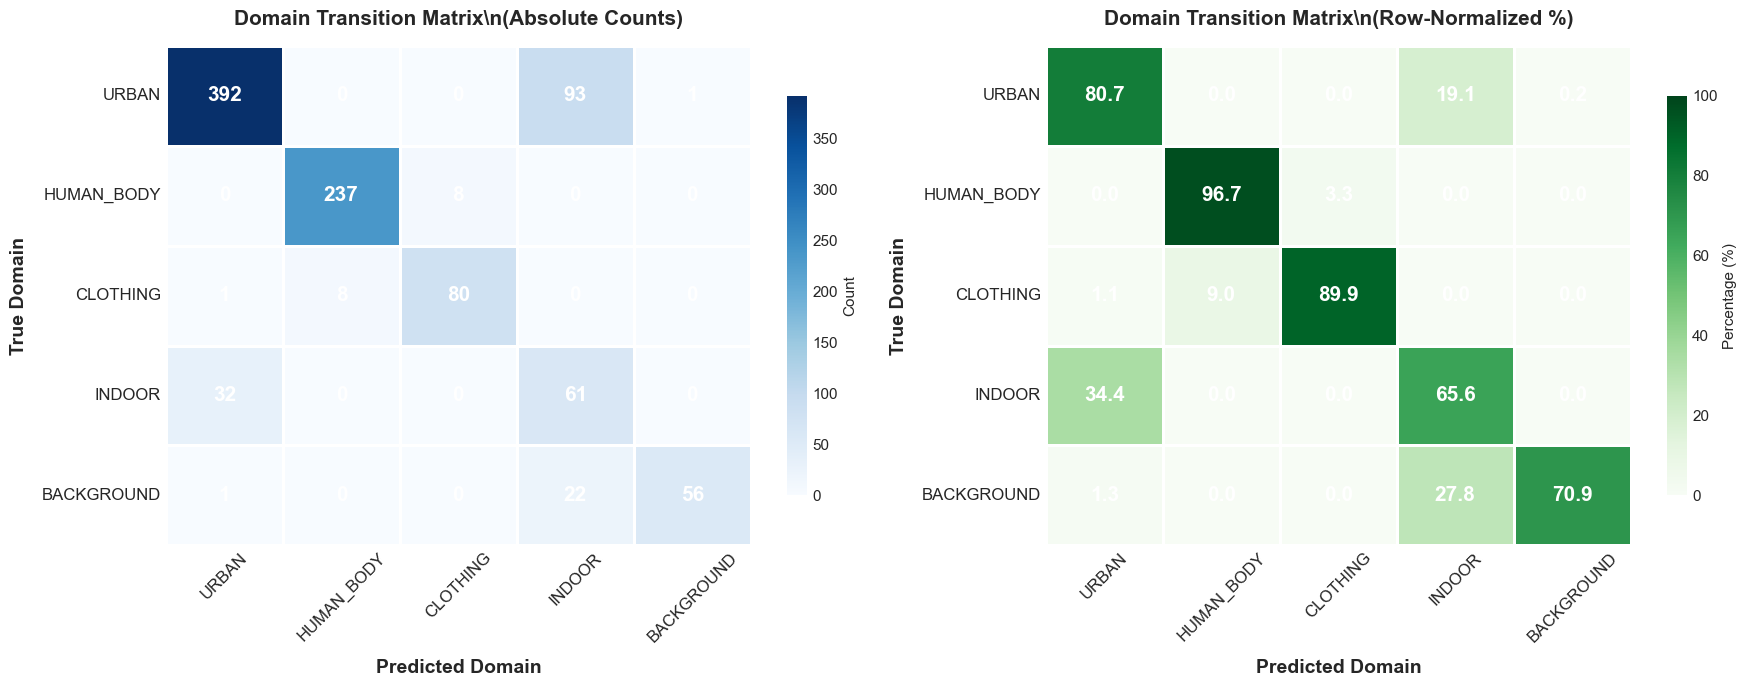

   ✅ Domain transition matrix kaydedildi

3️⃣ Mask Distribution Analysis oluşturuluyor...


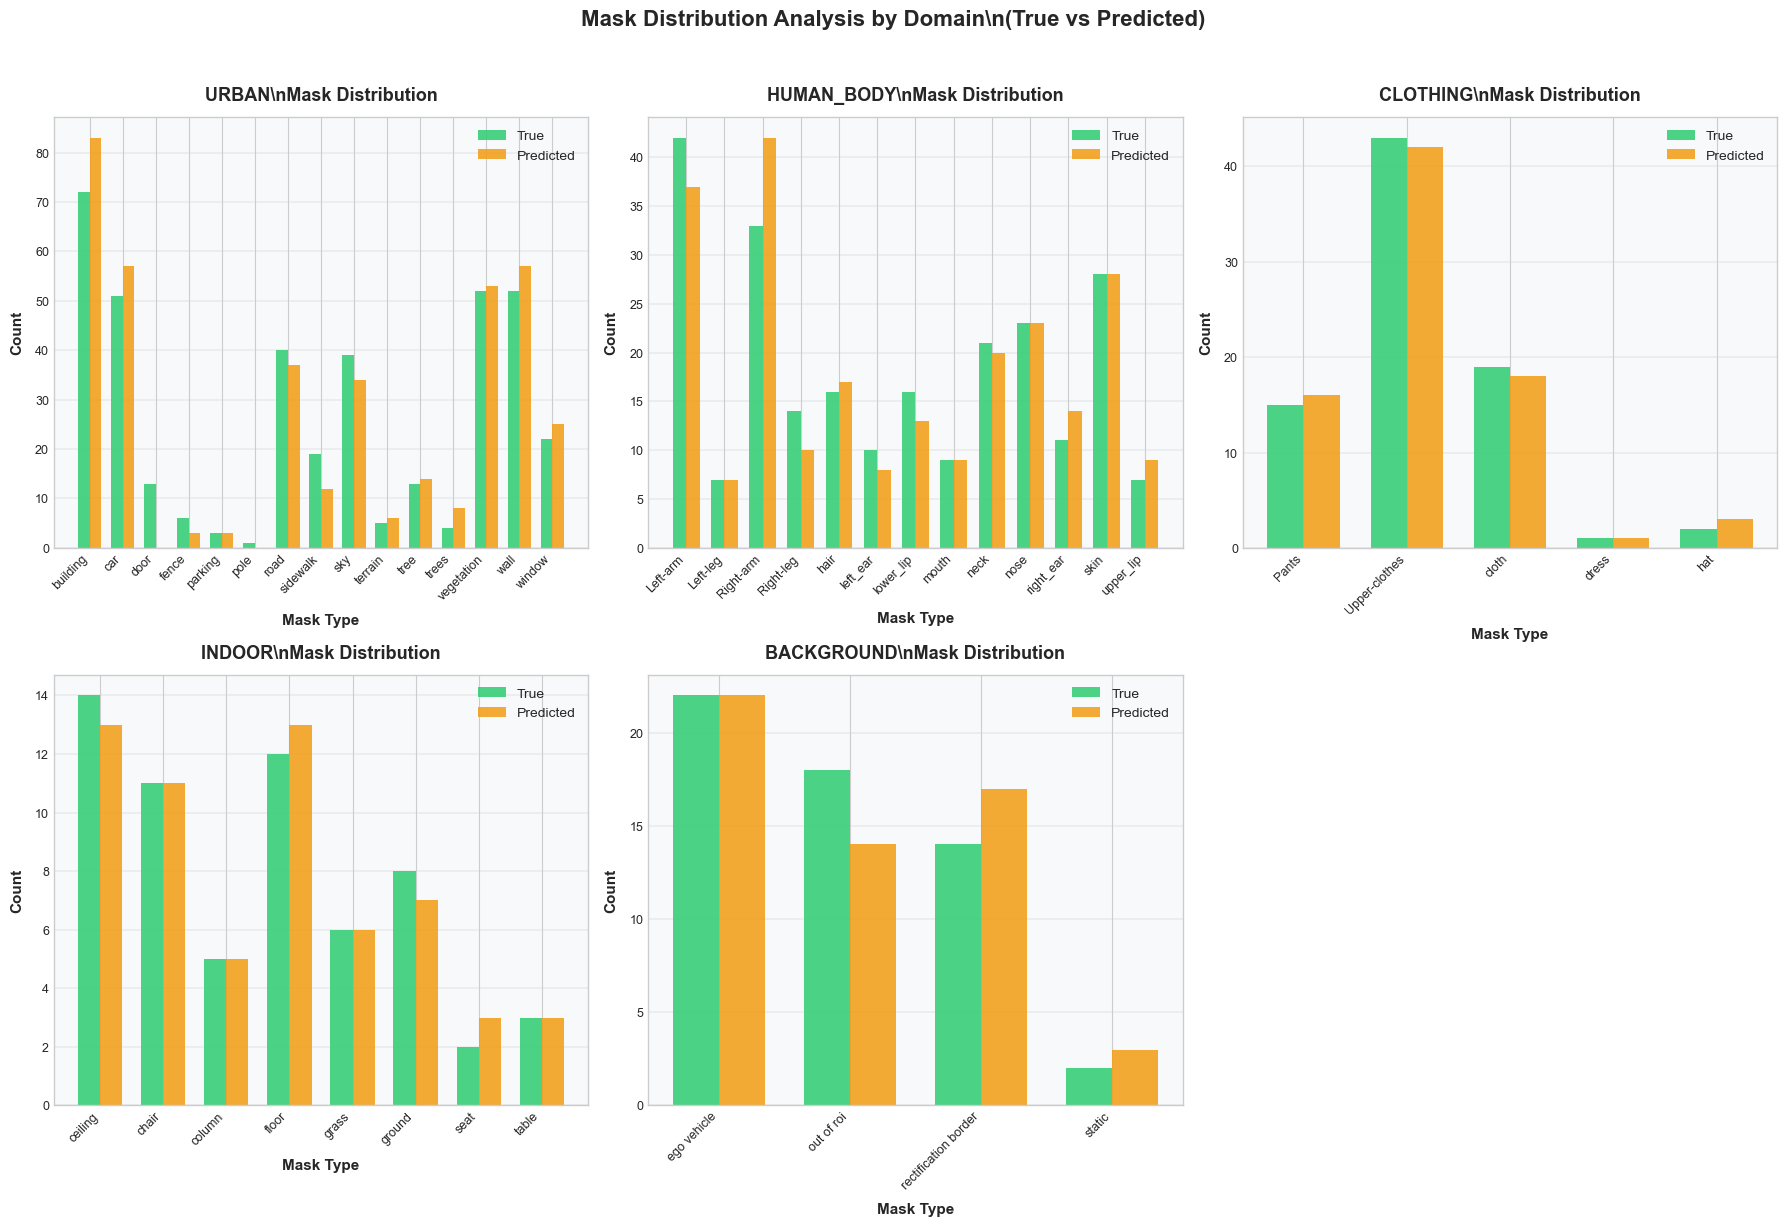

   ✅ Mask distribution analysis kaydedildi

4️⃣ Real vs Fake Statistics oluşturuluyor...


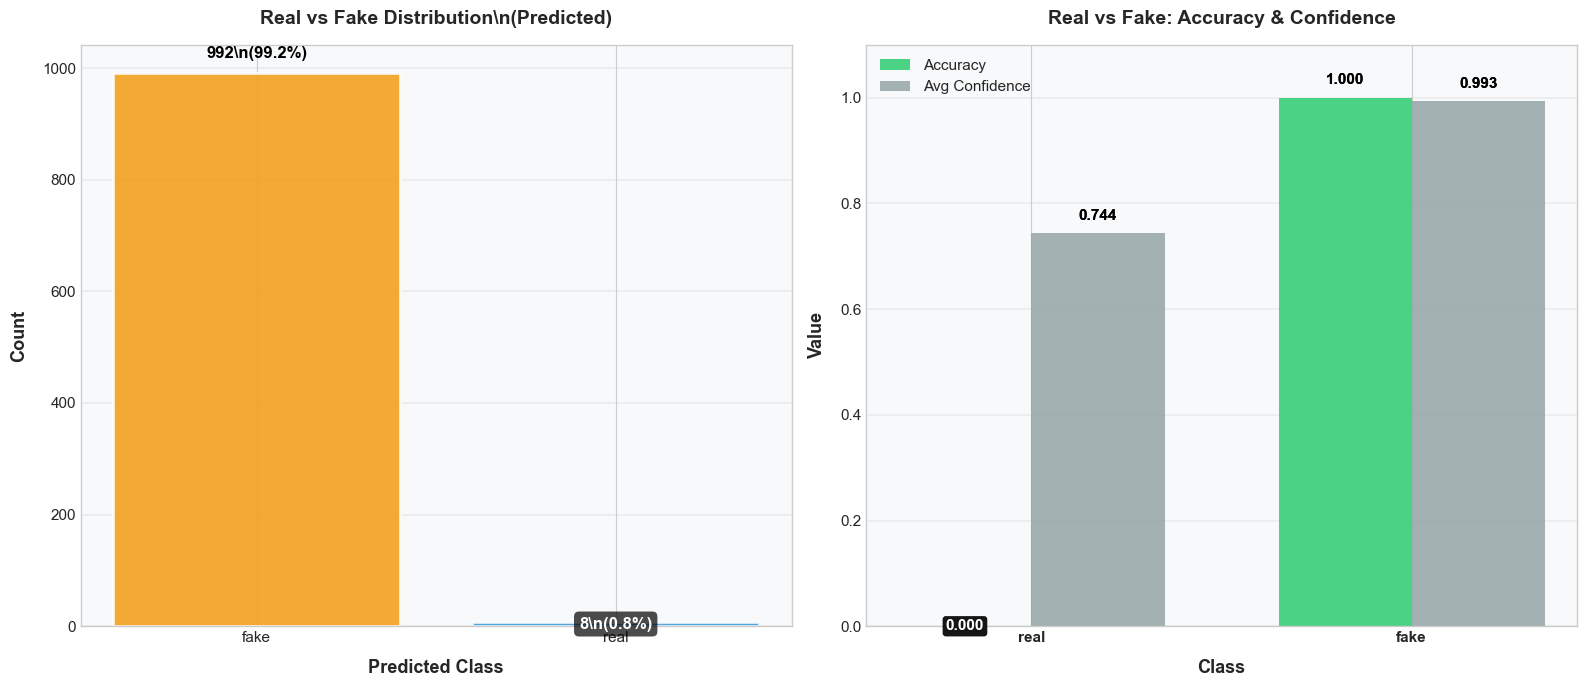

   ✅ Real vs Fake statistics kaydedildi

✅ İleri düzey analizler tamamlandı!


In [48]:
"""
🔬 İLERİ DÜZEY ANALİZLER
Confidence Calibration, Domain Transition Matrix, Mask Distribution, Real vs Fake Statistics
"""

print("\n" + "="*70)
print("🔬 İLERİ DÜZEY ANALİZLER")
print("="*70)

# =============================================
# 1. Confidence Calibration Plot
# =============================================

print("\n1️⃣ Confidence Calibration Plot oluşturuluyor...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Stage 0 Calibration
bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2

rf_confs = df_results['rf_confidence'].values
rf_correct = df_results['stage0_correct'].astype(int).values

bin_indices = np.digitize(rf_confs, bins) - 1
bin_indices = np.clip(bin_indices, 0, len(bins)-2)

calibrated_acc = []
for i in range(len(bins)-1):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        calibrated_acc.append(rf_correct[mask].mean())
    else:
        calibrated_acc.append(0)

axes[0].plot(bin_centers, calibrated_acc, 'o-', linewidth=3, markersize=10, 
            color=COLORS['real'], label='Actual Accuracy', markeredgecolor='white', markeredgewidth=1.5)
axes[0].plot([0, 1], [0, 1], '--', color='gray', linewidth=2, label='Perfect Calibration')
axes[0].set_xlabel('Predicted Confidence', fontsize=13, fontweight='bold', labelpad=10)
axes[0].set_ylabel('Actual Accuracy', fontsize=13, fontweight='bold', labelpad=10)
axes[0].set_title('Stage 0: Real/Fake Calibration', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=11, framealpha=0.9)
axes[0].grid(True, alpha=0.3, linewidth=1.5)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].tick_params(labelsize=11)

# Stage 1 Calibration
if len(df_fake) > 0:
    domain_confs = df_fake['domain_confidence'].values
    domain_correct = df_fake['domain_correct'].astype(int).values
    
    bin_indices = np.digitize(domain_confs, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(bins)-2)
    
    calibrated_acc = []
    for i in range(len(bins)-1):
        mask = (bin_indices == i)
        if mask.sum() > 0:
            calibrated_acc.append(domain_correct[mask].mean())
        else:
            calibrated_acc.append(0)
    
    axes[1].plot(bin_centers, calibrated_acc, 'o-', linewidth=3, markersize=10, 
                color=COLORS['fake'], label='Actual Accuracy', markeredgecolor='white', markeredgewidth=1.5)
    axes[1].plot([0, 1], [0, 1], '--', color='gray', linewidth=2, label='Perfect Calibration')
    axes[1].set_xlabel('Predicted Confidence', fontsize=13, fontweight='bold', labelpad=10)
    axes[1].set_ylabel('Actual Accuracy', fontsize=13, fontweight='bold', labelpad=10)
    axes[1].set_title('Stage 1: Domain Calibration', fontsize=14, fontweight='bold', pad=15)
    axes[1].legend(fontsize=11, framealpha=0.9)
    axes[1].grid(True, alpha=0.3, linewidth=1.5)
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])
    axes[1].tick_params(labelsize=11)
else:
    axes[1].text(0.5, 0.5, 'No fake images', ha='center', va='center', fontsize=12)
    axes[1].set_title('Stage 1: Domain Calibration', fontsize=13, fontweight='bold')

# Stage 2 Calibration
if len(df_stage1_correct) > 0:
    mask_confs = df_stage1_correct['mask_confidence'].values
    mask_correct = df_stage1_correct['mask_correct'].astype(int).values
    
    bin_indices = np.digitize(mask_confs, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(bins)-2)
    
    calibrated_acc = []
    for i in range(len(bins)-1):
        mask = (bin_indices == i)
        if mask.sum() > 0:
            calibrated_acc.append(mask_correct[mask].mean())
        else:
            calibrated_acc.append(0)
    
    axes[2].plot(bin_centers, calibrated_acc, 'o-', linewidth=3, markersize=10, 
                color=COLORS['correct'], label='Actual Accuracy', markeredgecolor='white', markeredgewidth=1.5)
    axes[2].plot([0, 1], [0, 1], '--', color='gray', linewidth=2, label='Perfect Calibration')
    axes[2].set_xlabel('Predicted Confidence', fontsize=13, fontweight='bold', labelpad=10)
    axes[2].set_ylabel('Actual Accuracy', fontsize=13, fontweight='bold', labelpad=10)
    axes[2].set_title('Stage 2: Mask Calibration', fontsize=14, fontweight='bold', pad=15)
    axes[2].legend(fontsize=11, framealpha=0.9)
    axes[2].grid(True, alpha=0.3, linewidth=1.5)
    axes[2].set_xlim([0, 1])
    axes[2].set_ylim([0, 1])
    axes[2].tick_params(labelsize=11)
else:
    axes[2].text(0.5, 0.5, 'No domain-correct samples', ha='center', va='center', fontsize=12)
    axes[2].set_title('Stage 2: Mask Calibration', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'confidence_calibration.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Confidence calibration plot kaydedildi")

# =============================================
# 2. Domain Transition Matrix
# =============================================

print("\n2️⃣ Domain Transition Matrix oluşturuluyor...")

if len(df_fake) > 0:
    transition_matrix = np.zeros((NUM_DOMAINS, NUM_DOMAINS))
    
    for i in range(NUM_DOMAINS):
        for j in range(NUM_DOMAINS):
            count = len(df_fake[(df_fake['true_domain_label'] == i) & 
                               (df_fake['final_pred_domain_label'] == j)])
            transition_matrix[i, j] = count
    
    # Normalize by row
    transition_matrix_norm = transition_matrix / (transition_matrix.sum(axis=1, keepdims=True) + 1e-10) * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Raw counts - İyileştirilmiş
    matrix_size = len(DOMAIN_NAMES)
    font_size = max(12, 16 - matrix_size // 3)
    sns.heatmap(transition_matrix, annot=True, fmt='.0f', cmap='Blues',
               xticklabels=DOMAIN_NAMES, yticklabels=DOMAIN_NAMES,
               ax=axes[0], cbar_kws={'label': 'Count', 'shrink': 0.8},
               annot_kws={'size': font_size, 'weight': 'bold', 'color': 'white'},
               linewidths=2, linecolor='white')
    axes[0].set_xlabel('Predicted Domain', fontsize=14, fontweight='bold', labelpad=10)
    axes[0].set_ylabel('True Domain', fontsize=14, fontweight='bold', labelpad=10)
    axes[0].set_title('Domain Transition Matrix\\n(Absolute Counts)', 
                     fontsize=15, fontweight='bold', pad=15)
    axes[0].tick_params(axis='x', rotation=45, labelsize=12)
    axes[0].tick_params(axis='y', rotation=0, labelsize=12)
    
    # Normalized percentages - İyileştirilmiş
    sns.heatmap(transition_matrix_norm, annot=True, fmt='.1f', cmap='Greens',
               xticklabels=DOMAIN_NAMES, yticklabels=DOMAIN_NAMES,
               ax=axes[1], cbar_kws={'label': 'Percentage (%)', 'shrink': 0.8},
               annot_kws={'size': font_size, 'weight': 'bold', 'color': 'white'},
               linewidths=2, linecolor='white', vmin=0, vmax=100)
    axes[1].set_xlabel('Predicted Domain', fontsize=14, fontweight='bold', labelpad=10)
    axes[1].set_ylabel('True Domain', fontsize=14, fontweight='bold', labelpad=10)
    axes[1].set_title('Domain Transition Matrix\\n(Row-Normalized %)', 
                     fontsize=15, fontweight='bold', pad=15)
    axes[1].tick_params(axis='x', rotation=45, labelsize=12)
    axes[1].tick_params(axis='y', rotation=0, labelsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'domain_transition_matrix.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Domain transition matrix kaydedildi")
else:
    print(f"   ⚠️  Fake görüntü yok, transition matrix atlandı")

# =============================================
# 3. Mask Distribution Analysis
# =============================================

print("\n3️⃣ Mask Distribution Analysis oluşturuluyor...")

if len(df_stage1_correct) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, domain in enumerate(DOMAIN_NAMES):
        ax = axes[idx]
        
        df_dom = df_stage1_correct[df_stage1_correct['true_domain_name'] == domain]
        if len(df_dom) == 0:
            ax.text(0.5, 0.5, f'{domain}\\nNo data', ha='center', va='center', fontsize=12)
            ax.set_title(f'{domain}')
            continue
        
        # True mask distribution
        true_mask_counts = df_dom['true_mask_name'].value_counts()
        pred_mask_counts = df_dom['pred_mask_name'].value_counts()
        
        # Combine all masks
        all_masks = sorted(set(true_mask_counts.index) | set(pred_mask_counts.index))
        
        true_counts = [true_mask_counts.get(m, 0) for m in all_masks]
        pred_counts = [pred_mask_counts.get(m, 0) for m in all_masks]
        
        x = np.arange(len(all_masks))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, true_counts, width, label='True', 
                      color=COLORS['correct'], alpha=0.85)
        bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted', 
                      color=COLORS['fake'], alpha=0.85)
        
        ax.set_xlabel('Mask Type', fontsize=11, fontweight='bold', labelpad=8)
        ax.set_ylabel('Count', fontsize=11, fontweight='bold', labelpad=8)
        ax.set_title(f'{domain}\\nMask Distribution', fontsize=13, fontweight='bold', pad=12)
        ax.set_xticks(x)
        ax.set_xticklabels(all_masks, rotation=45, ha='right', fontsize=9)
        ax.legend(fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3, axis='y', linewidth=1.2)
        ax.tick_params(labelsize=9)
    
    axes[5].axis('off')
    
    fig.suptitle('Mask Distribution Analysis by Domain\\n(True vs Predicted)', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_FOLDER, 'mask_distribution_analysis.png'), 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Mask distribution analysis kaydedildi")
else:
    print(f"   ⚠️  Domain correct örnek yok, mask distribution atlandı")

# =============================================
# 4. Real vs Fake Statistics
# =============================================

print("\n4️⃣ Real vs Fake Statistics oluşturuluyor...")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Sol: Real/Fake distribution
ax = axes[0]
rf_counts = df_results['pred_rf_name'].value_counts()
colors_rf = [COLORS['real'] if name == 'real' else COLORS['fake'] for name in rf_counts.index]

bars = ax.bar(rf_counts.index, rf_counts.values, color=colors_rf, 
             edgecolor='white', linewidth=2, alpha=0.85)
ax.set_xlabel('Predicted Class', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('Count', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Real vs Fake Distribution\\n(Predicted)', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y', linewidth=1.2)
ax.tick_params(labelsize=11)

max_count = rf_counts.values.max()
for bar, count in zip(bars, rf_counts.values):
    height = bar.get_height()
    pct = count/len(df_results)*100
    if height > max_count * 0.1:
        text_y = height + max_count * 0.02
        text_color = 'black'
        bbox_props = None
    else:
        text_y = height / 2
        text_color = 'white'
        bbox_props = dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7, edgecolor='none')
    ax.text(bar.get_x() + bar.get_width()/2., text_y,
           f'{count:,}\\n({pct:.1f}%)',
           ha='center', va='bottom' if height > max_count * 0.1 else 'center',
           fontsize=12, fontweight='bold', color=text_color, bbox=bbox_props)

# Sağ: Real/Fake accuracy comparison
ax = axes[1]
rf_stats = []
for rf_name in ['real', 'fake']:
    df_rf = df_results[df_results['pred_rf_name'] == rf_name]
    if len(df_rf) > 0:
        accuracy = df_rf['stage0_correct'].mean() if 'stage0_correct' in df_rf.columns else 0.0
        avg_conf = df_rf['rf_confidence'].mean()
        rf_stats.append({
            'class': rf_name,
            'count': len(df_rf),
            'accuracy': accuracy,
            'avg_confidence': avg_conf
        })

if rf_stats:
    df_rf_stats = pd.DataFrame(rf_stats)
    
    x = np.arange(len(df_rf_stats))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, df_rf_stats['accuracy'], width, 
                  label='Accuracy', color=COLORS['correct'], alpha=0.85)
    bars2 = ax.bar(x + width/2, df_rf_stats['avg_confidence'], width, 
                  label='Avg Confidence', color=COLORS['neutral'], alpha=0.85)
    
    ax.set_xlabel('Class', fontsize=13, fontweight='bold', labelpad=10)
    ax.set_ylabel('Value', fontsize=13, fontweight='bold', labelpad=10)
    ax.set_title('Real vs Fake: Accuracy & Confidence', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(df_rf_stats['class'], fontsize=12, fontweight='bold')
    ax.legend(fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y', linewidth=1.2)
    ax.set_ylim([0, 1.1])
    ax.tick_params(labelsize=11)
    
    for bars, values in [(bars1, df_rf_stats['accuracy']), (bars2, df_rf_stats['avg_confidence'])]:
        max_val = max(df_rf_stats['accuracy'].max(), df_rf_stats['avg_confidence'].max())
        for bars, values in [(bars1, df_rf_stats['accuracy']), (bars2, df_rf_stats['avg_confidence'])]:
            for bar, val in zip(bars, values):
                height = bar.get_height()
                if height > max_val * 0.05:
                    text_y = height + max_val * 0.02
                    text_color = 'black'
                    bbox_props = None
                else:
                    text_y = height / 2
                    text_color = 'white'
                    bbox_props = dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7, edgecolor='none')
                ax.text(bar.get_x() + bar.get_width()/2., text_y,
                       f'{val:.3f}',
                       ha='center', va='bottom' if height > max_val * 0.05 else 'center',
                       fontsize=11, fontweight='bold', color=text_color, bbox=bbox_props)
else:
    ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
    ax.set_title('Real vs Fake: Accuracy & Confidence', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(VIZ_FOLDER, 'real_vs_fake_statistics.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"   ✅ Real vs Fake statistics kaydedildi")

print(f"\n✅ İleri düzey analizler tamamlandı!")


## 1️⃣3️⃣ Export: CSV ve JSON

Tüm sonuçları CSV ve JSON formatında export etme


In [49]:
"""
💾 EXPORT: CSV ve JSON
Tüm sonuçları ve metrikleri export etme
"""

print("\n" + "="*70)
print("💾 EXPORT: CSV ve JSON")
print("="*70)

# =============================================
# 0. Metrikleri Hesapla (Eğer henüz hesaplanmadıysa)
# =============================================

# Stage 0 accuracy
if 'stage0_accuracy' not in locals():
    stage0_correct = df_results['stage0_correct'].sum()
    total_samples = len(df_results)
    stage0_accuracy = stage0_correct / total_samples if total_samples > 0 else 0.0

# Stage 1 accuracy (fake görüntüler için)
df_fake = df_results[df_results['pred_rf_name'] == 'fake'].copy()
if len(df_fake) > 0:
    if 'domain_accuracy' not in locals():
        domain_correct = df_fake['domain_correct'].sum()
        domain_accuracy = domain_correct / len(df_fake) if len(df_fake) > 0 else 0.0
else:
    domain_accuracy = 0.0

# Stage 2 accuracy (domain-correct fake görüntüler için)
df_stage1_correct = df_fake[df_fake['domain_correct'] == True].copy() if len(df_fake) > 0 else pd.DataFrame()
if len(df_stage1_correct) > 0:
    if 'mask_accuracy_on_correct' not in locals():
        mask_correct = df_stage1_correct['mask_correct'].sum()
        mask_accuracy_on_correct = mask_correct / len(df_stage1_correct) if len(df_stage1_correct) > 0 else 0.0
else:
    mask_accuracy_on_correct = 0.0

# Pipeline accuracy
if 'pipeline_accuracy' not in locals():
    pipeline_correct = df_results['pipeline_correct'].sum() if 'pipeline_correct' in df_results.columns else 0
    total_samples = len(df_results)
    pipeline_accuracy = pipeline_correct / total_samples if total_samples > 0 else 0.0

# =============================================
# 1. Detaylı Sonuçlar CSV
# =============================================

print("\n1️⃣ Detaylı sonuçlar CSV'ye kaydediliyor...")

# df_results zaten hazır, sadece export et (timestamp ile)
csv_filename = f'detailed_results_{TIMESTAMP}.csv'
csv_path = os.path.join(OUTPUT_FOLDER, csv_filename)
df_results.to_csv(csv_path, index=False, encoding='utf-8-sig')
print(f"   ✅ Detaylı sonuçlar kaydedildi: {csv_path}")
print(f"      Toplam {len(df_results):,} satır, {len(df_results.columns)} sütun")
print(f"      Oluşturulma zamanı: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# =============================================
# 2. Özet Metrikler JSON
# =============================================

print("\n2️⃣ Özet metrikler JSON'a kaydediliyor...")

# Özet metrikler
summary_metrics = {
    'test_info': {
        'total_samples': int(len(df_results)),
        'test_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS,
        'use_amp': USE_AMP,
        'use_multi_expert_routing': USE_MULTI_EXPERT_ROUTING,
        'routing_threshold': ROUTING_THRESHOLD if USE_MULTI_EXPERT_ROUTING else None
    },
    'stage0_metrics': {
        'accuracy': float(stage0_accuracy),
        'total_samples': int(len(df_results)),
        'real_count': int(len(df_results[df_results['pred_rf_name'] == 'real'])),
        'fake_count': int(len(df_results[df_results['pred_rf_name'] == 'fake'])),
        'real_accuracy': float(df_results[df_results['pred_rf_name'] == 'real']['stage0_correct'].mean()) if len(df_results[df_results['pred_rf_name'] == 'real']) > 0 else 0.0,
        'fake_accuracy': float(df_results[df_results['pred_rf_name'] == 'fake']['stage0_correct'].mean()) if len(df_results[df_results['pred_rf_name'] == 'fake']) > 0 else 0.0,
        'avg_confidence': float(df_results['rf_confidence'].mean())
    }
}

# Stage 1 metrikleri
# df_fake zaten yukarıda tanımlandı
if len(df_fake) > 0:
    summary_metrics['stage1_metrics'] = {
        'accuracy': float(domain_accuracy),
        'total_samples': int(len(df_fake)),
        'avg_confidence': float(df_fake['domain_confidence'].mean()),
        'multi_expert_usage': int(df_fake['used_multi_expert'].sum()) if 'used_multi_expert' in df_fake.columns else 0,
        'multi_expert_usage_pct': float(df_fake['used_multi_expert'].mean() * 100) if 'used_multi_expert' in df_fake.columns else 0.0
    }
    
    # Domain bazında metrikler
    domain_metrics = {}
    for domain in DOMAIN_NAMES:
        df_dom = df_fake[df_fake['true_domain_name'] == domain]
        if len(df_dom) > 0:
            domain_metrics[domain] = {
                'count': int(len(df_dom)),
                'accuracy': float(df_dom['domain_correct'].mean()),
                'avg_confidence': float(df_dom['domain_confidence'].mean())
            }
    summary_metrics['stage1_metrics']['by_domain'] = domain_metrics
else:
    summary_metrics['stage1_metrics'] = {
        'accuracy': 0.0,
        'total_samples': 0,
        'avg_confidence': 0.0
    }

# Stage 2 metrikleri
# df_stage1_correct zaten yukarıda tanımlandı
if len(df_stage1_correct) > 0:
    summary_metrics['stage2_metrics'] = {
        'accuracy': float(mask_accuracy_on_correct),
        'total_samples': int(len(df_stage1_correct)),
        'avg_confidence': float(df_stage1_correct['mask_confidence'].mean())
    }
    
    # Domain bazında Stage 2 metrikleri
    domain_s2_metrics = {}
    for domain in DOMAIN_NAMES:
        df_dom = df_stage1_correct[df_stage1_correct['true_domain_name'] == domain]
        if len(df_dom) > 0:
            domain_s2_metrics[domain] = {
                'count': int(len(df_dom)),
                'accuracy': float(df_dom['mask_correct'].mean()),
                'avg_confidence': float(df_dom['mask_confidence'].mean())
            }
    summary_metrics['stage2_metrics']['by_domain'] = domain_s2_metrics
else:
    summary_metrics['stage2_metrics'] = {
        'accuracy': 0.0,
        'total_samples': 0,
        'avg_confidence': 0.0
    }

# Full pipeline metrikleri
summary_metrics['pipeline_metrics'] = {
    'full_pipeline_accuracy': float(pipeline_accuracy),
    'stage0_accuracy': float(stage0_accuracy),
    'stage1_accuracy': float(domain_accuracy) if len(df_fake) > 0 else 0.0,
    'stage2_accuracy': float(mask_accuracy_on_correct) if len(df_stage1_correct) > 0 else 0.0
}

# Hata analizi
error_breakdown = {
    'stage0_errors': int(len(df_results[df_results['stage0_correct'] == False])),
    'stage1_errors': int(len(df_fake[df_fake['domain_correct'] == False])) if len(df_fake) > 0 else 0,
    'stage2_errors': int(len(df_stage1_correct[df_stage1_correct['mask_correct'] == False])) if len(df_stage1_correct) > 0 else 0,
    'full_success': int(len(df_stage1_correct[df_stage1_correct['mask_correct'] == True])) if len(df_stage1_correct) > 0 else 0
}
summary_metrics['error_breakdown'] = error_breakdown

# JSON'a kaydet (timestamp ile)
json_filename = f'summary_metrics_{TIMESTAMP}.json'
json_path = os.path.join(OUTPUT_FOLDER, json_filename)
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(summary_metrics, f, indent=2, ensure_ascii=False)

print(f"   ✅ Özet metrikler kaydedildi: {json_path}")
print(f"      Oluşturulma zamanı: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# =============================================
# 3. Domain Bazında Özet CSV
# =============================================

print("\n3️⃣ Domain bazında özet CSV'ye kaydediliyor...")

if len(df_fake) > 0:
    domain_summary = []
    for domain in DOMAIN_NAMES:
        df_dom = df_fake[df_fake['true_domain_name'] == domain]
        if len(df_dom) == 0:
            continue
        
        df_dom_correct = df_dom[df_dom['domain_correct'] == True]
        
        domain_summary.append({
            'domain': domain,
            'total_samples': len(df_dom),
            'stage1_accuracy': df_dom['domain_correct'].mean(),
            'stage1_avg_confidence': df_dom['domain_confidence'].mean(),
            'stage2_samples': len(df_dom_correct),
            'stage2_accuracy': df_dom_correct['mask_correct'].mean() if len(df_dom_correct) > 0 else 0.0,
            'stage2_avg_confidence': df_dom_correct['mask_confidence'].mean() if len(df_dom_correct) > 0 else 0.0,
            'pipeline_accuracy': df_dom['pipeline_correct'].mean() if 'pipeline_correct' in df_dom.columns else 0.0
        })
    
    if domain_summary:
        df_domain_summary = pd.DataFrame(domain_summary)
        domain_csv_filename = f'domain_summary_{TIMESTAMP}.csv'
        domain_csv_path = os.path.join(OUTPUT_FOLDER, domain_csv_filename)
        df_domain_summary.to_csv(domain_csv_path, index=False, encoding='utf-8-sig')
        print(f"   ✅ Domain özeti kaydedildi: {domain_csv_path}")
        print(f"      Oluşturulma zamanı: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    else:
        print(f"   ⚠️  Domain özeti oluşturulamadı")
else:
    print(f"   ⚠️  Fake görüntü yok, domain özeti atlandı")

# =============================================
# 4. Export Özeti
# =============================================

print("\n" + "="*70)
print("📊 EXPORT ÖZETİ")
print("="*70)
print(f"✅ Detaylı sonuçlar: {csv_filename}")
print(f"✅ Özet metrikler: {json_filename}")
if len(df_fake) > 0 and 'domain_summary' in locals():
    print(f"✅ Domain özeti: {domain_csv_filename}")
print(f"✅ Görselleştirmeler: {VIZ_FOLDER}")
print(f"\\n📁 Tüm çıktılar: {OUTPUT_FOLDER}")
print(f"📅 Test zamanı: {TIMESTAMP}")

print(f"\n✅ Export tamamlandı!")



💾 EXPORT: CSV ve JSON

1️⃣ Detaylı sonuçlar CSV'ye kaydediliyor...
   ✅ Detaylı sonuçlar kaydedildi: combined_pipeline_test_results\20251224_140610\detailed_results_20251224_140610.csv
      Toplam 1,000 satır, 27 sütun
      Oluşturulma zamanı: 2025-12-24 14:13:45

2️⃣ Özet metrikler JSON'a kaydediliyor...
   ✅ Özet metrikler kaydedildi: combined_pipeline_test_results\20251224_140610\summary_metrics_20251224_140610.json
      Oluşturulma zamanı: 2025-12-24 14:13:45

3️⃣ Domain bazında özet CSV'ye kaydediliyor...
   ✅ Domain özeti kaydedildi: combined_pipeline_test_results\20251224_140610\domain_summary_20251224_140610.csv
      Oluşturulma zamanı: 2025-12-24 14:13:45

📊 EXPORT ÖZETİ
✅ Detaylı sonuçlar: detailed_results_20251224_140610.csv
✅ Özet metrikler: summary_metrics_20251224_140610.json
✅ Domain özeti: domain_summary_20251224_140610.csv
✅ Görselleştirmeler: combined_pipeline_test_results\20251224_140610\visualizations
\n📁 Tüm çıktılar: combined_pipeline_test_results\20251224_14

## ✅ Test Tamamlandı!

Tüm analizler, görselleştirmeler ve export işlemleri tamamlandı.


In [50]:
"""
✅ TEST TAMAMLANDI - ÖZET
"""

print("\n" + "="*70)
print("✅ COMBINED PIPELINE FULL TEST TAMAMLANDI!")
print("="*70)

print("\n📊 ÖZET METRİKLER:")
print(f"   Toplam Test Örneği: {len(df_results):,}")
print(f"   Stage 0 (Real/Fake) Accuracy: {stage0_accuracy*100:.2f}%")
if len(df_results[df_results['pred_rf_name'] == 'fake']) > 0:
    print(f"   Stage 1 (Domain) Accuracy: {domain_accuracy*100:.2f}%")
    df_stage1_correct = df_results[(df_results['pred_rf_name'] == 'fake') & 
                                   (df_results['domain_correct'] == True)]
    if len(df_stage1_correct) > 0:
        print(f"   Stage 2 (Mask) Accuracy: {mask_accuracy_on_correct*100:.2f}%")
print(f"   Full Pipeline Accuracy: {pipeline_accuracy*100:.2f}%")

print("\n📁 ÇIKTILAR:")
print(f"   📂 Ana Klasör: {OUTPUT_FOLDER}")
print(f"   📅 Test Zamanı: {TIMESTAMP}")
print(f"   📊 Detaylı Sonuçlar: detailed_results_{TIMESTAMP}.csv")
print(f"   📈 Özet Metrikler: summary_metrics_{TIMESTAMP}.json")
print(f"   🎨 Görselleştirmeler: {len(os.listdir(VIZ_FOLDER)) if os.path.exists(VIZ_FOLDER) else 0} dosya")

print("\n🎯 ÖZELLİKLER:")
print("   ✅ Stage 0: Real/Fake sınıflandırması")
print("   ✅ Stage 1: Domain tespiti (Multi-Expert Routing ile)")
print("   ✅ Stage 2: Mask tespiti (Domain-specific)")
print("   ✅ Kapsamlı görselleştirmeler ve analizler")
print("   ✅ ROC/PR curves, F1-scores, confusion matrices")
print("   ✅ Confidence calibration, error analysis")
print("   ✅ CSV ve JSON export")

print("\n" + "="*70)
print("🎉 TÜM İŞLEMLER BAŞARIYLA TAMAMLANDI!")
print("="*70)



✅ COMBINED PIPELINE FULL TEST TAMAMLANDI!

📊 ÖZET METRİKLER:
   Toplam Test Örneği: 1,000
   Stage 0 (Real/Fake) Accuracy: 99.20%
   Stage 1 (Domain) Accuracy: 0.05%
   Stage 2 (Mask) Accuracy: 79.72%
   Full Pipeline Accuracy: 66.60%

📁 ÇIKTILAR:
   📂 Ana Klasör: combined_pipeline_test_results\20251224_140610
   📅 Test Zamanı: 20251224_140610
   📊 Detaylı Sonuçlar: detailed_results_20251224_140610.csv
   📈 Özet Metrikler: summary_metrics_20251224_140610.json
   🎨 Görselleştirmeler: 24 dosya

🎯 ÖZELLİKLER:
   ✅ Stage 0: Real/Fake sınıflandırması
   ✅ Stage 1: Domain tespiti (Multi-Expert Routing ile)
   ✅ Stage 2: Mask tespiti (Domain-specific)
   ✅ Kapsamlı görselleştirmeler ve analizler
   ✅ ROC/PR curves, F1-scores, confusion matrices
   ✅ Confidence calibration, error analysis
   ✅ CSV ve JSON export

🎉 TÜM İŞLEMLER BAŞARIYLA TAMAMLANDI!
